# Development Notebook for Cortical Crowding Project

## Dependencies

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize
from scipy.optimize import minimize
from scipy.stats import gmean
from scipy.optimize import curve_fit

/home/lindazelinzhou/.conda/envs/neuro/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.family'] = 'HelveticaNeue'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'light'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.dpi'] = 576  # 72*8
mpl.rcParams['hatch.color'] = 'white'

In [3]:
# We want to be able to load in libraries that are in this repository's src directory,
# so we add src to the system path:
try:
    import corticalcrodwing as cc
except ModuleNotFoundError:
    # This probably happens because the corticalcrowding library hasn't been
    # installed yet; we can add the src directory to the path to work around
    # this here.
    sys.path.append('../src')
    # Now we can import corticalcrowding from the src directory:
    import corticalcrowding as cc

## Configuration

In [4]:
# The root path where data is stored:
data_path = Path('/data/crowding')

# The crowding data CSV file:
crowding_data_filename = data_path / 'crowding_data_withID.csv'

In [5]:
# The list of subjects:
sids_NYU = [
    'sub-wlsubj070',
    'sub-wlsubj114',
    'sub-wlsubj121',
    'sub-wlsubj135']

# 36 is used
sids_NEI = [ 
    'sub-wlsubj119',
    'sub-wlsubj127',
    'sub-wlsubj136',
    'sub-wlsubj137',
    'sub-wlsubj143',
    'sub-wlsubj144',
    'sub-wlsubj145',
    'sub-wlsubj146',
    'sub-wlsubj147',
    'sub-wlsubj148',
    'sub-wlsubj149',
    'sub-wlsubj150',
    'sub-wlsubj151',
    'sub-wlsubj152',
    'sub-wlsubj153',
    'sub-wlsubj154',
    'sub-wlsubj155',
    'sub-wlsubj156',
    'sub-wlsubj157',
    'sub-wlsubj158',
    'sub-wlsubj159',
    'sub-wlsubj160',
    'sub-wlsubj161',
    'sub-wlsubj162',
    'sub-wlsubj163',
    'sub-wlsubj164',
    'sub-wlsubj165',
    'sub-wlsubj166',
    'sub-wlsubj167',
    'sub-wlsubj168',
    'sub-wlsubj170',
    'sub-wlsubj171',
    'sub-wlsubj172',
    'sub-wlsubj173',
    'sub-wlsubj174',
    'sub-wlsubj175',
    'sub-wlsubj176']

sids_orig = sids_NYU + sids_NEI

## Crowding Distance Calculations

In [6]:
crowding_data = pd.read_csv(crowding_data_filename)

In [7]:
# each subject has 1 crowding distance value at each eccentricity
mean_cd = (
    crowding_data
    .groupby(['ID','RadialEccentricity'])
    ['CrowdingDistance']
    .apply(gmean)
    .reset_index())

In [8]:
cd_list = crowding_data['CrowdingDistance'].tolist()
mean_cd_list = mean_cd['CrowdingDistance'].tolist()

In [9]:
# create 3 dfs based on the eccentricities in the dataframe:
crowding_eccens = np.unique(crowding_data['RadialEccentricity'])
assert len(crowding_eccens) == 3
(ecc_1, ecc_2, ecc_3) = crowding_eccens

mean_1 = mean_cd[mean_cd['RadialEccentricity'] == ecc_1]
n_1 = len(mean_1)
m_1 = mean_1['CrowdingDistance'].mean()
st_1 = mean_1['CrowdingDistance'].std()

mean_2 = mean_cd[mean_cd['RadialEccentricity'] == ecc_2]
n_2 = len(mean_2)
m_2 = mean_2['CrowdingDistance'].mean()
st_2 = mean_2['CrowdingDistance'].std()

mean_3 = mean_cd[mean_cd['RadialEccentricity'] == ecc_3]
n_3 = len(mean_3)
m_3 = mean_3['CrowdingDistance'].mean()
st_3 = mean_3['CrowdingDistance'].std()

In [10]:
x_ecc = crowding_data['RadialEccentricity'].tolist()
mean_x_ecc = mean_cd['RadialEccentricity'].tolist()

In [11]:
# The crowding distance function in terms of eccentricity function described
# by Kurzawski et al. (2023):
Kurzawski2023_cd = cc.crowding.Kurzawski2023_cd

# Fit the b parameter using this function by minimizing log error.
b, _ = curve_fit(cc.crowding.log_Kurzawski2023_cd, x_ecc, np.log10(cd_list), p0=0.15)
b = b[0]
b

0.19811346275888986

In [12]:
mean_values = [m_1, m_2, m_3]
std_values = [st_1, st_2, st_3]
sem_values = np.array([st_1, st_2, st_3]) / np.sqrt([n_1, n_2, n_3])
eccentricities = [ecc_1, ecc_2, ecc_3]

In [13]:
# calculate the bouma factor
[val / div for val, div in zip(mean_values, eccentricities)]

[0.27543237749636423, 0.27932364527017073, 0.3422964015001243]

### bootstrap on crowding distance fit

In [14]:
num_bootstrap_samples = 10000
x = np.linspace(0.5,11,1000)
eccentricities = [2.5, 5, 10]

sid_df = crowding_data['ID'].values
x_ecc = np.array(x_ecc)
cd = np.array(cd_list)

bootstrapped = cc.crowding.bootstrap_fit(sid_df, x_ecc, cd, x, num_bootstrap_samples)

# Calculate confidence interval
confidence_interval_cd = np.percentile(bootstrapped, [2.5, 97.5], axis=0)

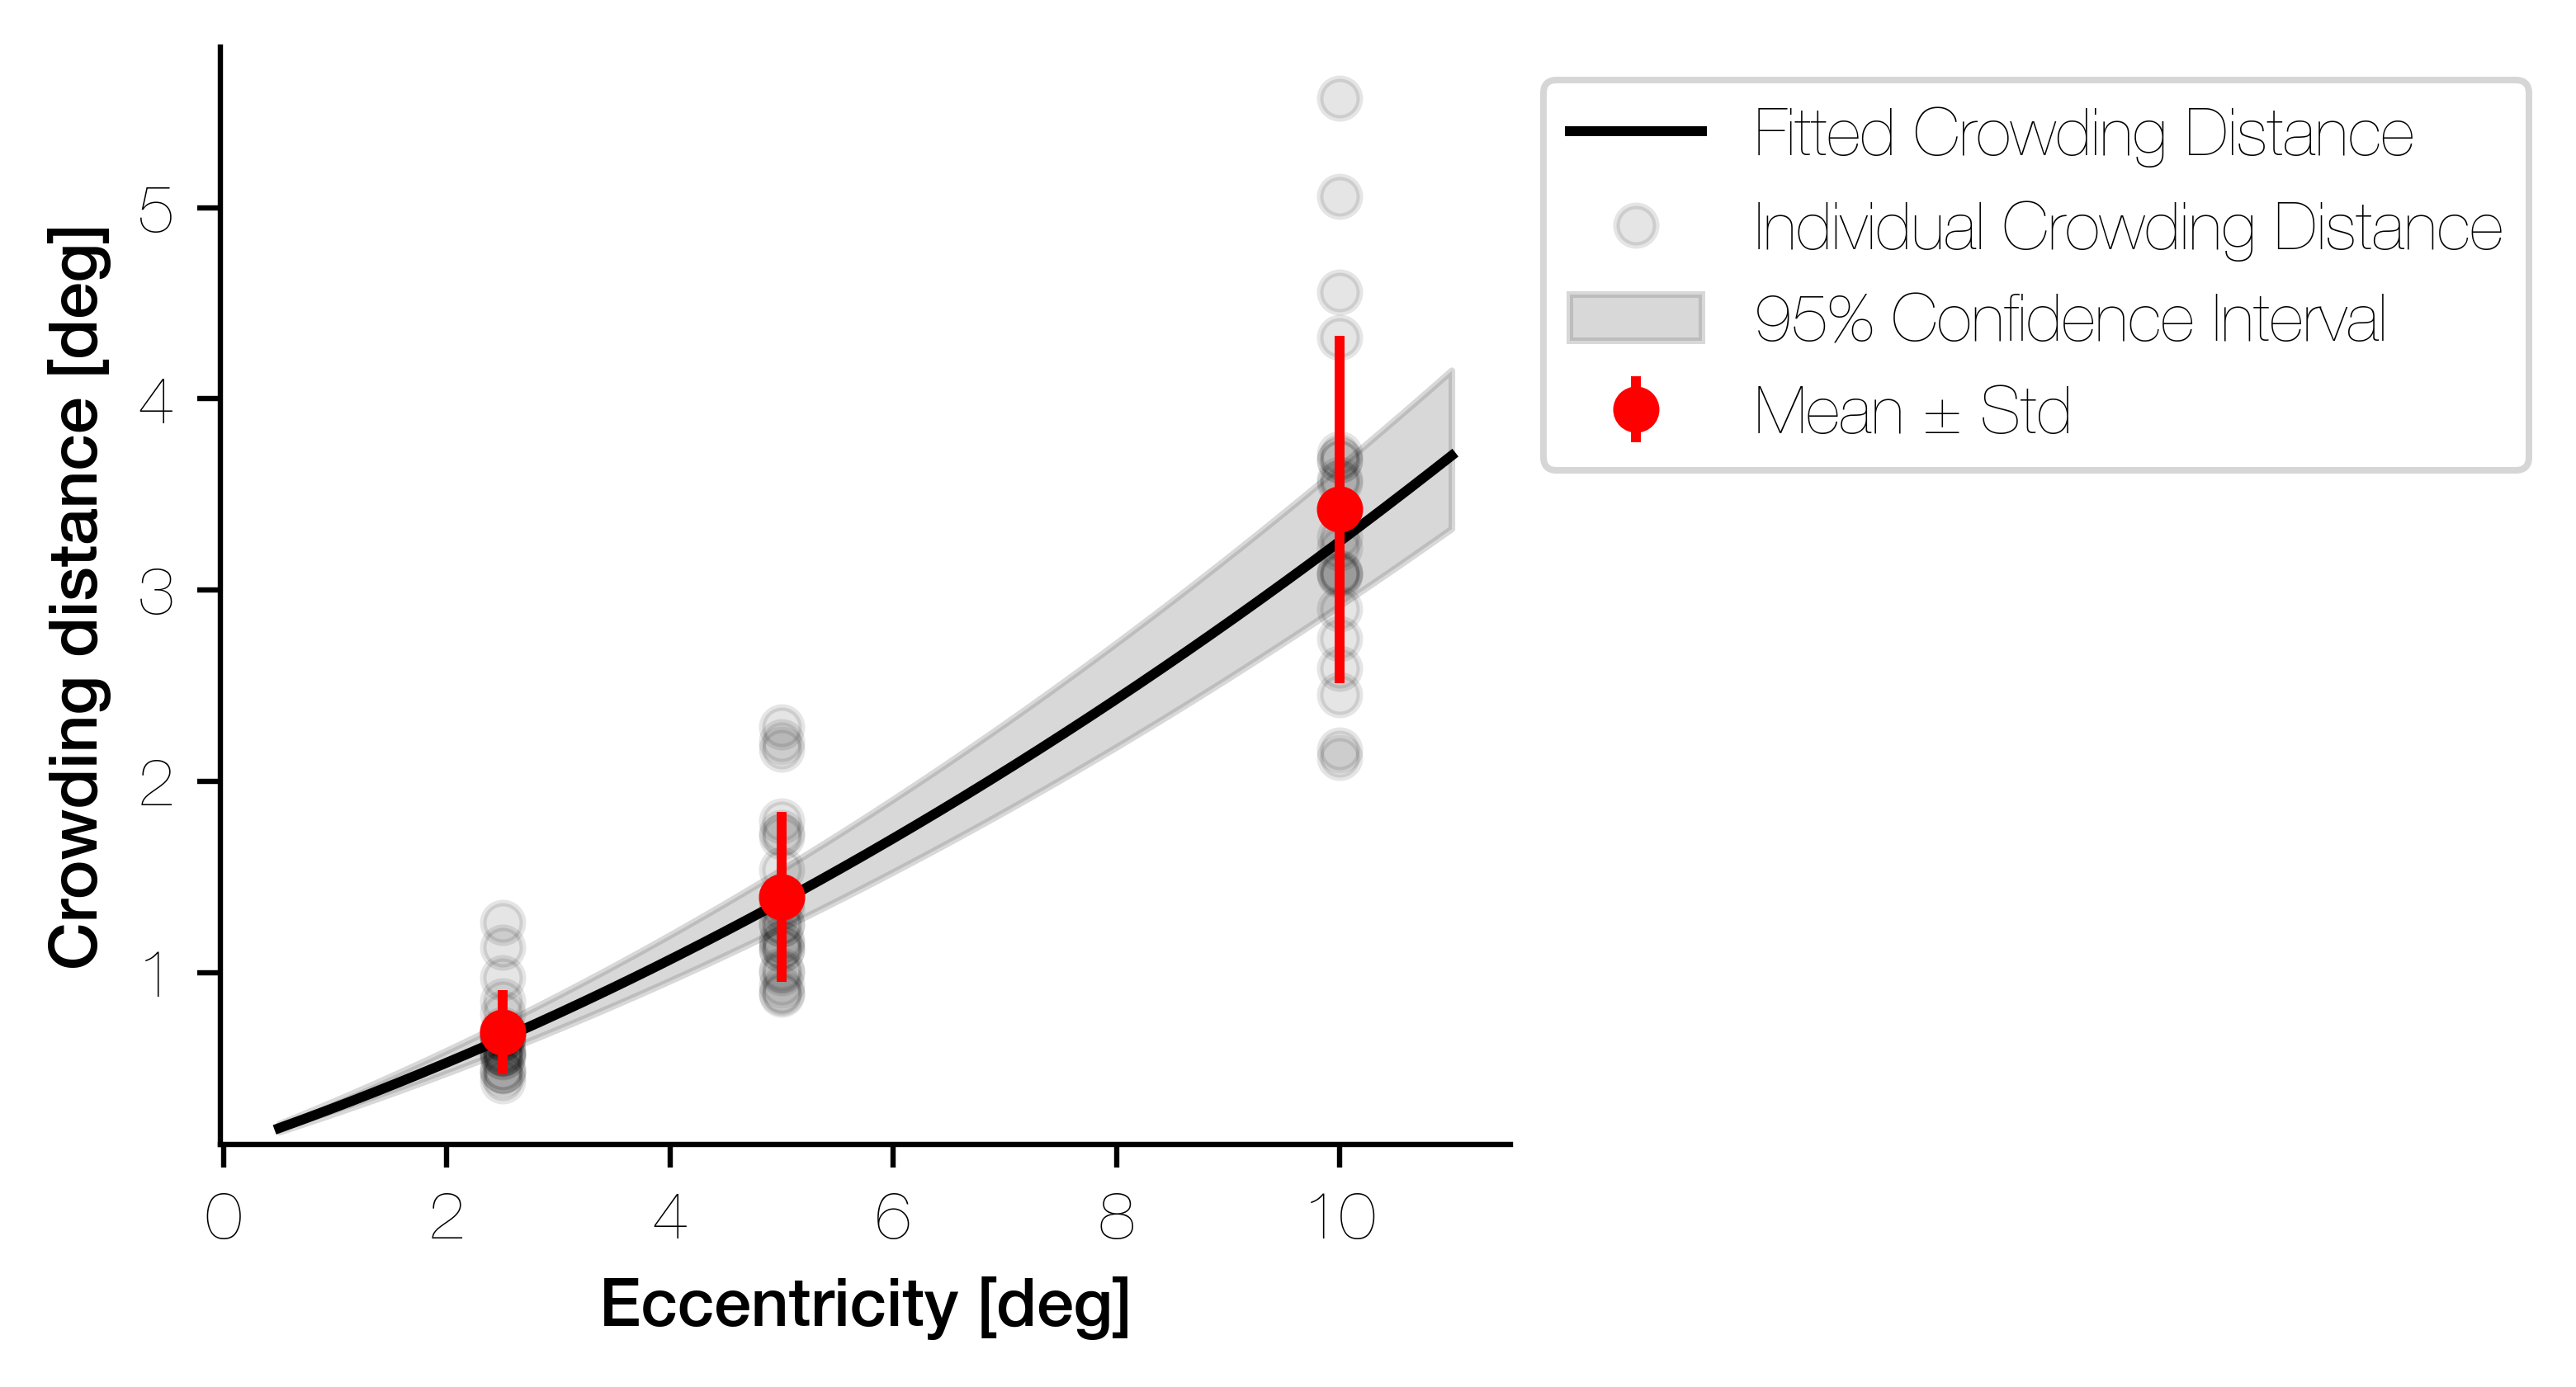

In [15]:
plt.figure(figsize=(3.5, 3))

# Fitted value without bootstrap
plt.plot(x, (0.43 + x + 0.06*(x**2)) * b, 'k-', label='Fitted Crowding Distance')

# Plot individual data
plt.plot(mean_x_ecc, mean_cd_list, 'ko', alpha=0.1, label='Individual Crowding Distance')

# Plot error bars
plt.errorbar(eccentricities, mean_values, yerr=std_values, fmt='o', color='red', label='Mean ± Std')
plt.fill_between(x, confidence_interval_cd[0], confidence_interval_cd[1], color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Eccentricity [deg]')
plt.ylabel('Crowding distance [deg]')

plt.ylim(bottom=0.1)  # Set lower limit to 0.1 (10^-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## Fit Cortical Magnification

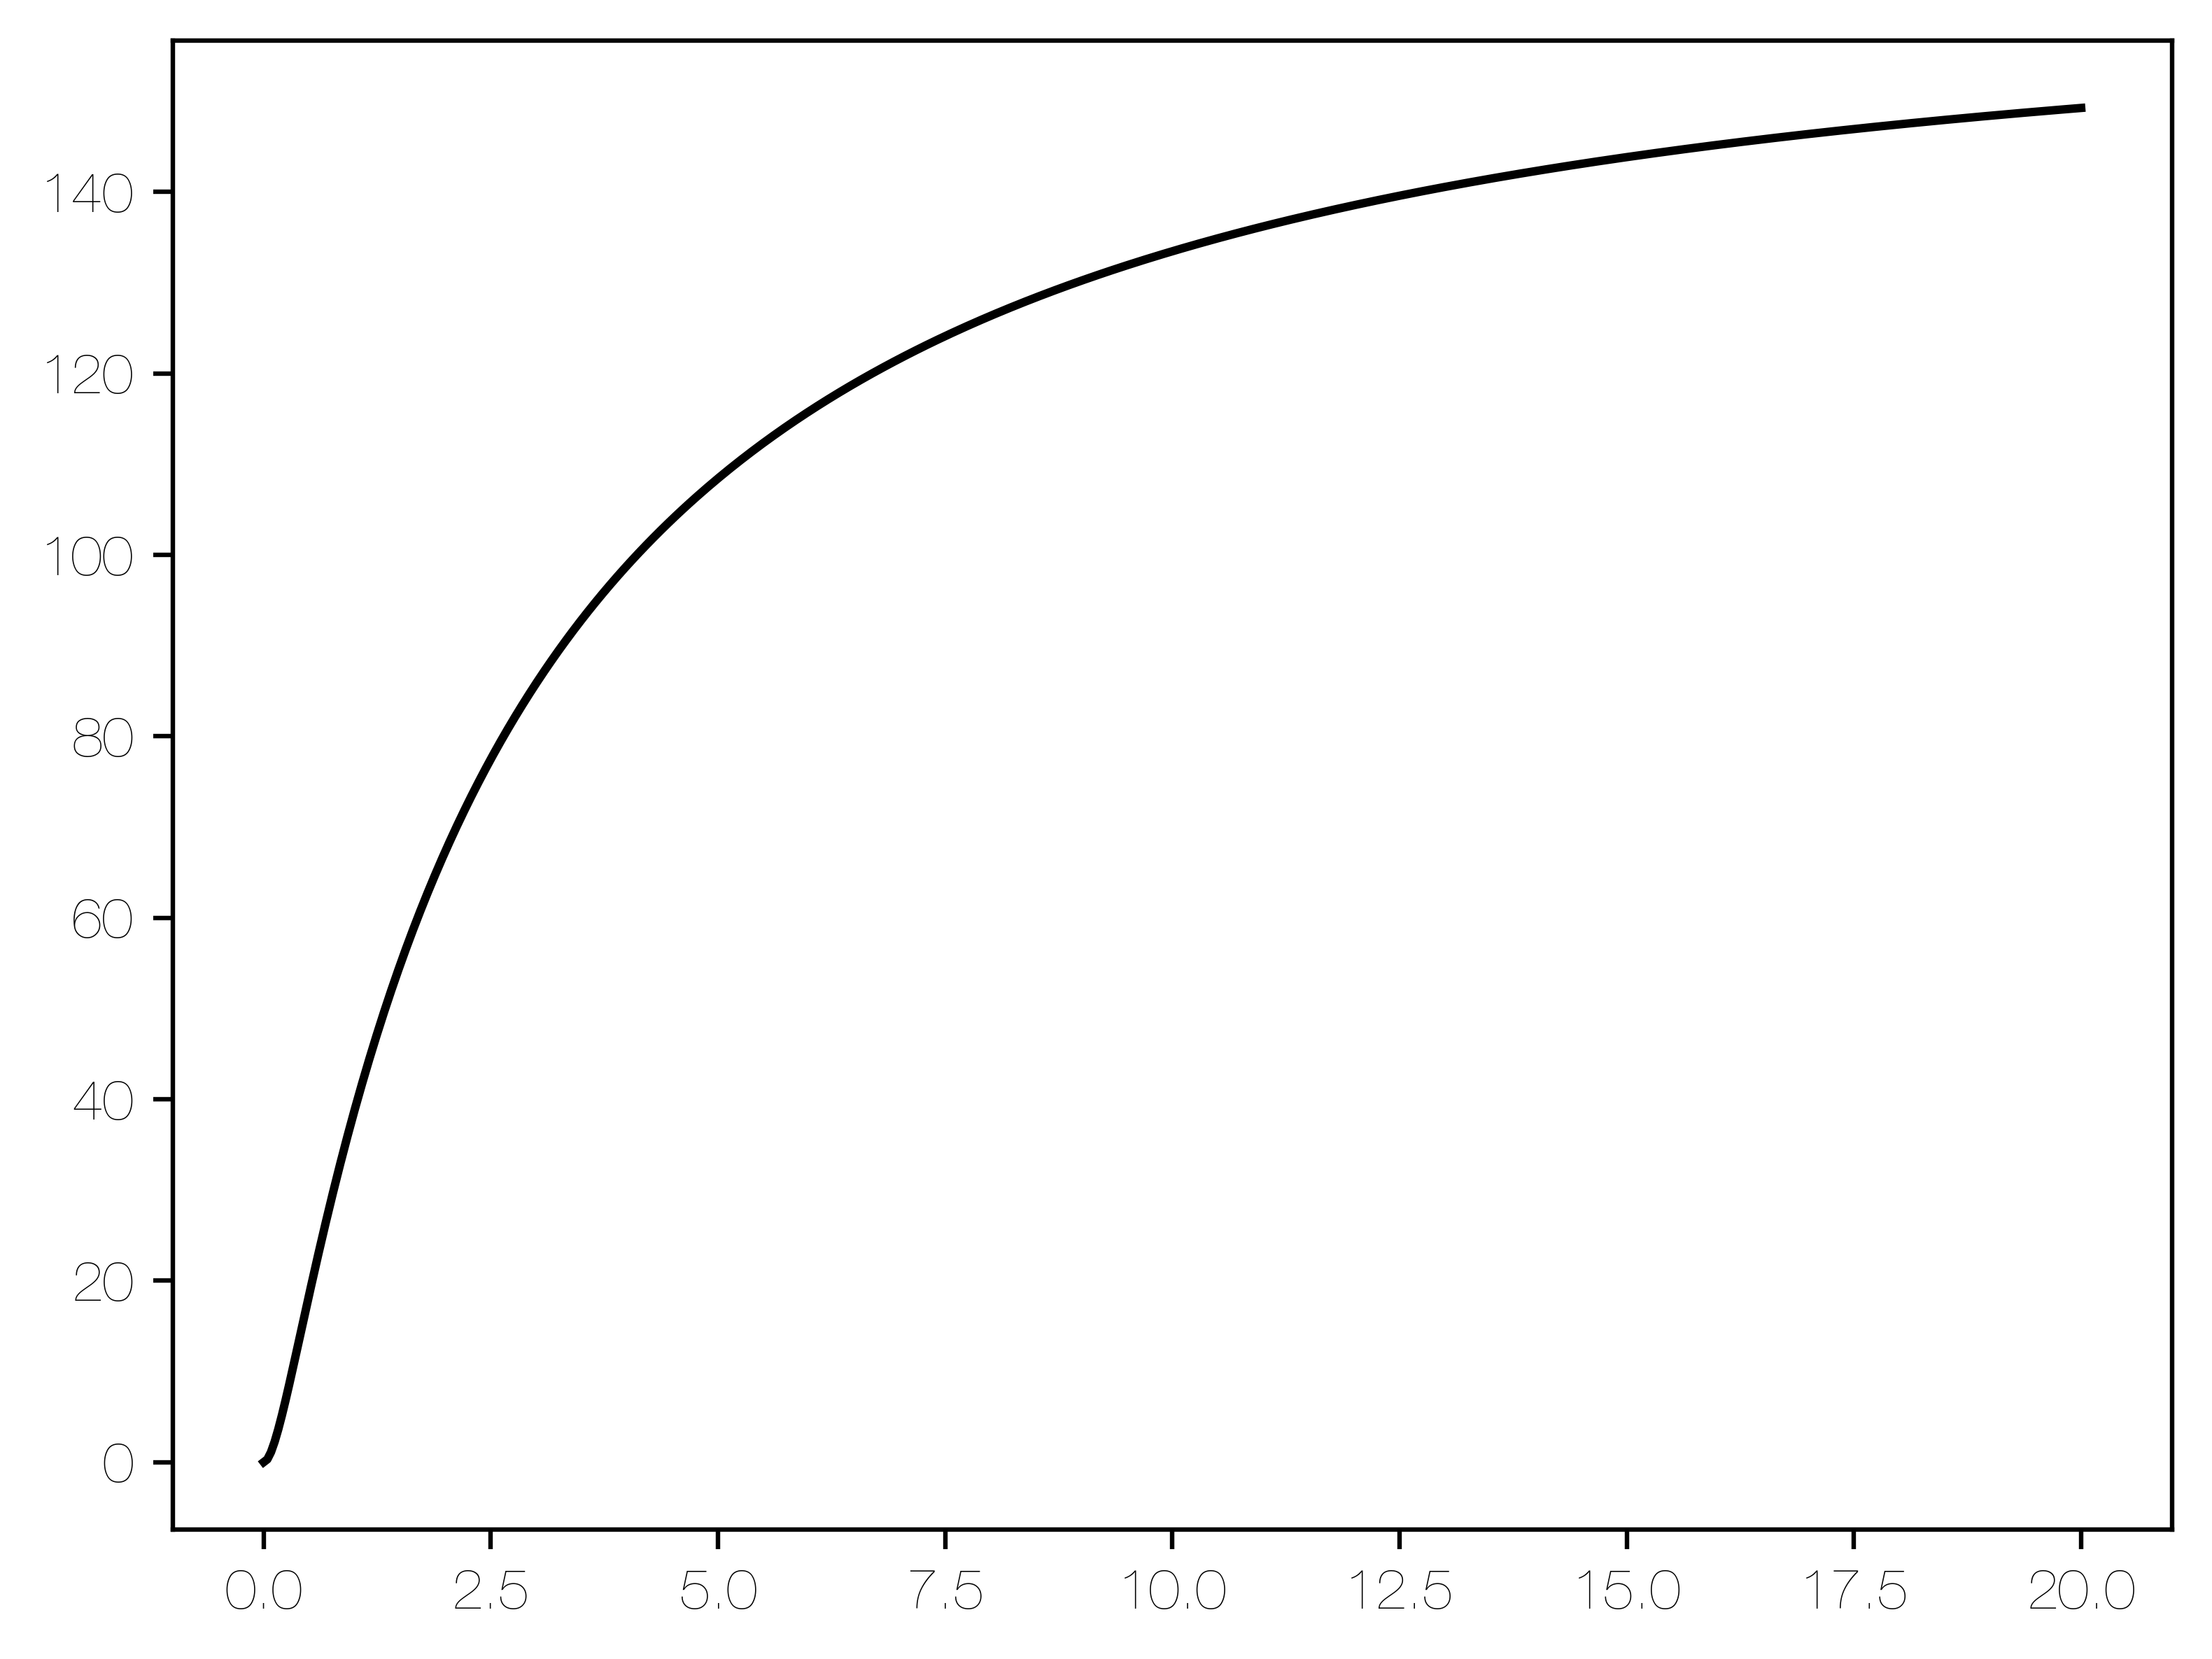

In [6]:
r = np.linspace(0, 20, 500)
m = cc.cmag.invsuplin_integral(r)

plt.plot(r, m, 'k-')
plt.show()

In [19]:
cc.cmag

<module 'corticalcrowding.cmag' from '/home/lindazelinzhou/cortical-crowding/notebooks/../src/corticalcrowding/cmag.py'>

In [7]:
df = dict(sid=[], h=[], label=[], g=[], h_param=[], q=[], loss=[])
for sid in sids_orig:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = cc.cmag.fit_cumarea(sid, h, lbl)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['g'].append(r.x[0])
            df['h_param'].append(r.x[1])
            df['q'].append(r.x[2])
            df['loss'].append(r.fun)  

invsuplin_params = pd.DataFrame(df)

sub-wlsubj070
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
sub-wlsubj114
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._exceptions._UFuncOutputCastingError'>
  - Skipping: <class 'numpy.core._ex

KeyboardInterrupt: 

## hh91 way

In [16]:
df = dict(sid=[], h=[], label=[], a=[], b=[], loss=[])
for sid in sids_orig:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = cc.cmag.fit_cumarea(sid, h, lbl, ecc_fit_min=1, ecc_fit_max=10)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['a'].append(r.x[0])
            df['b'].append(r.x[1])
            df['loss'].append(r.fun)

HH91_params = pd.DataFrame(df)

sub-wlsubj070
sub-wlsubj114
sub-wlsubj121
sub-wlsubj135
sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
sub-wlsubj161
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
sub-wlsubj171
sub-wlsubj172
sub-wlsubj173
sub-wlsubj174
sub-wlsubj175
sub-wlsubj176


In [17]:
HH91_params

sid   h  label          a         b         loss
0    sub-wlsubj070  lh      1  16.433999  0.635602  7825.896200
1    sub-wlsubj070  lh      2  15.366061  0.812214  6454.470282
2    sub-wlsubj070  lh      3  11.499850  0.242905  2013.901801
3    sub-wlsubj070  lh      4   3.917473  0.015798    38.757518
4    sub-wlsubj070  rh      1  17.045827  1.176327  2875.710725
..             ...  ..    ...        ...       ...          ...
315  sub-wlsubj176  lh      4   4.794755  0.010039   206.149643
316  sub-wlsubj176  rh      1  13.555829  0.482374  9239.216394
317  sub-wlsubj176  rh      2  10.487229  0.256624  6096.206761
318  sub-wlsubj176  rh      3   9.244560  0.260841   731.862404
319  sub-wlsubj176  rh      4   6.402033  0.161560   560.436982

[320 rows x 6 columns]

## gain params for cmag with respect to inv crowding

In [18]:
def Bouma(r, /, b=0.198, *, a=0.43, c=0.06):
    """Returns the visual crowding distance according to Kurzawski et al. (2025)."""
    return b * (a + r + c*r**2)
def inverse_Bouma_cumarea(r, /, a=0.43, b=0.198, c=0.06):
    """Returns the cumulative area predicted by the inverse-Bouma cortical 
    magnification model."""
    from numpy import pi, arctan, real_if_close
    from numpy.lib.scimath import sqrt as csqrt
    # The formula:
    const = (2*pi) / b**2
    ac4_1 = 4*a*c - 1
    sqrt_ac4_1 = csqrt(ac4_1)
    formula = (
        (r + 2*c*r**2)/(ac4_1 * (a + r + c*r**2)) +
        2*(arctan(1/sqrt_ac4_1) - arctan((2*c*r + 1)/sqrt_ac4_1)) / sqrt_ac4_1**3)
    return const * real_if_close(formula)

In [19]:
def fit_gain_inv_bouma(ecc, cum_area, b=0.198):
    pred = inverse_Bouma_cumarea(ecc, a=0.43, b=0.198, c=0.06)
    def mse_loss(g):
        return np.mean((cum_area - g*pred) ** 2)

    # initial guess for gain=1
    result = minimize(mse_loss, x0=[1.0])
    gain = result.x[0]

    return gain


In [63]:
# labels = ['V1', 'V2', 'V3', 'V4']
# plt.figure(figsize=(3.5, 3.5))
# for i, lbl in enumerate(labels):
#     hemi_rs = np.array(rsquareds['lh'][i] + rsquareds['rh'][i])
#     plt.hist(hemi_rs, bins=15, alpha=0.6, label=lbl)
#     print(np.mean(hemi_rs))
# plt.xlabel("r2")
# plt.ylabel("Count")
# plt.title("r2 distribution by visual area (LH + RH)")
# plt.legend()
# plt.show()

### test the HH91_integral r2

In [20]:
def fit_gain_hh91(ecc, cum_area, b=0.198):
    pred = cc.cmag.HH91_integral(ecc, a, b)
    def mse_loss(g):
        return np.mean((cum_area - g * pred) ** 2)

    # initial guess for gain=1
    result = minimize(mse_loss, x0=[1.0])
    gain = result.x[0]

    return gain

In [75]:
rsquareds_hh91 = {'lh': [[],[],[],[]], 'rh': [[],[],[],[]]}

for sid in sids_orig:
    hh91_fits = HH91_params[HH91_params['sid'] == sid]
    for i, lbl in enumerate([1, 2, 3, 4]):
        for hemi in ['lh','rh']:
            hfit_row = hh91_fits[(hh91_fits['label']==lbl) & (hh91_fits['h']==hemi)]
            if len(hfit_row)==0:
                continue
              
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]

            ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
            ii = np.argsort(ecc)
            ecc, srf = ecc[ii], srf[ii]
            cum_area = np.cumsum(srf)
            
            cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
            rsquareds_hh91[hemi][i].append(model_rsquared(cumarea_fit, cum_area))
          


In [22]:
def model_rsquared(pred, gold):
    var_gold = np.var(gold)
    error = (gold - pred)
    mean_sse = np.mean(error**2)
    return 1 - mean_sse / var_gold

In [23]:
rows_gain = []
rows_hh91 = []

for sid in sids_orig:
    hh91_fits = HH91_params[HH91_params['sid'] == sid]

    for i, lbl in enumerate([1, 2, 3, 4]):   
        for hemi in ['lh', 'rh']:

            hfit_row = hh91_fits[
                (hh91_fits['label'] == lbl) &
                (hh91_fits['h'] == hemi)
            ]
            if len(hfit_row) == 0:
                continue

            # HH91 parameters
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]

            # empirical ecc + surface area
            ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
            ii = np.argsort(ecc)
            ecc = ecc[ii]
            srf = srf[ii]
            cum_area = np.cumsum(srf)

            # ---- Bouma gain (for crowding-derived model) ----
            gain = fit_gain_inv_bouma(ecc, cum_area)
            rsq_bouma = model_rsquared(gain*inverse_Bouma_cumarea(ecc), cum_area)
            rows_gain.append({
                'sid': sid,
                'hemi': hemi,
                'label': lbl,
                'gain': gain,
                'rsq':rsq_bouma
            })

            # ---- HH91 R² (for classical model) ----
            cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
            rsq_hh91 = model_rsquared(cumarea_fit, cum_area)

            rows_hh91.append({
                'sid': sid,
                'hemi': hemi,
                'label': lbl,
                'rsq_hh91': rsq_hh91
            })

gain_df  = pd.DataFrame(rows_gain)
hh91_df  = pd.DataFrame(rows_hh91)


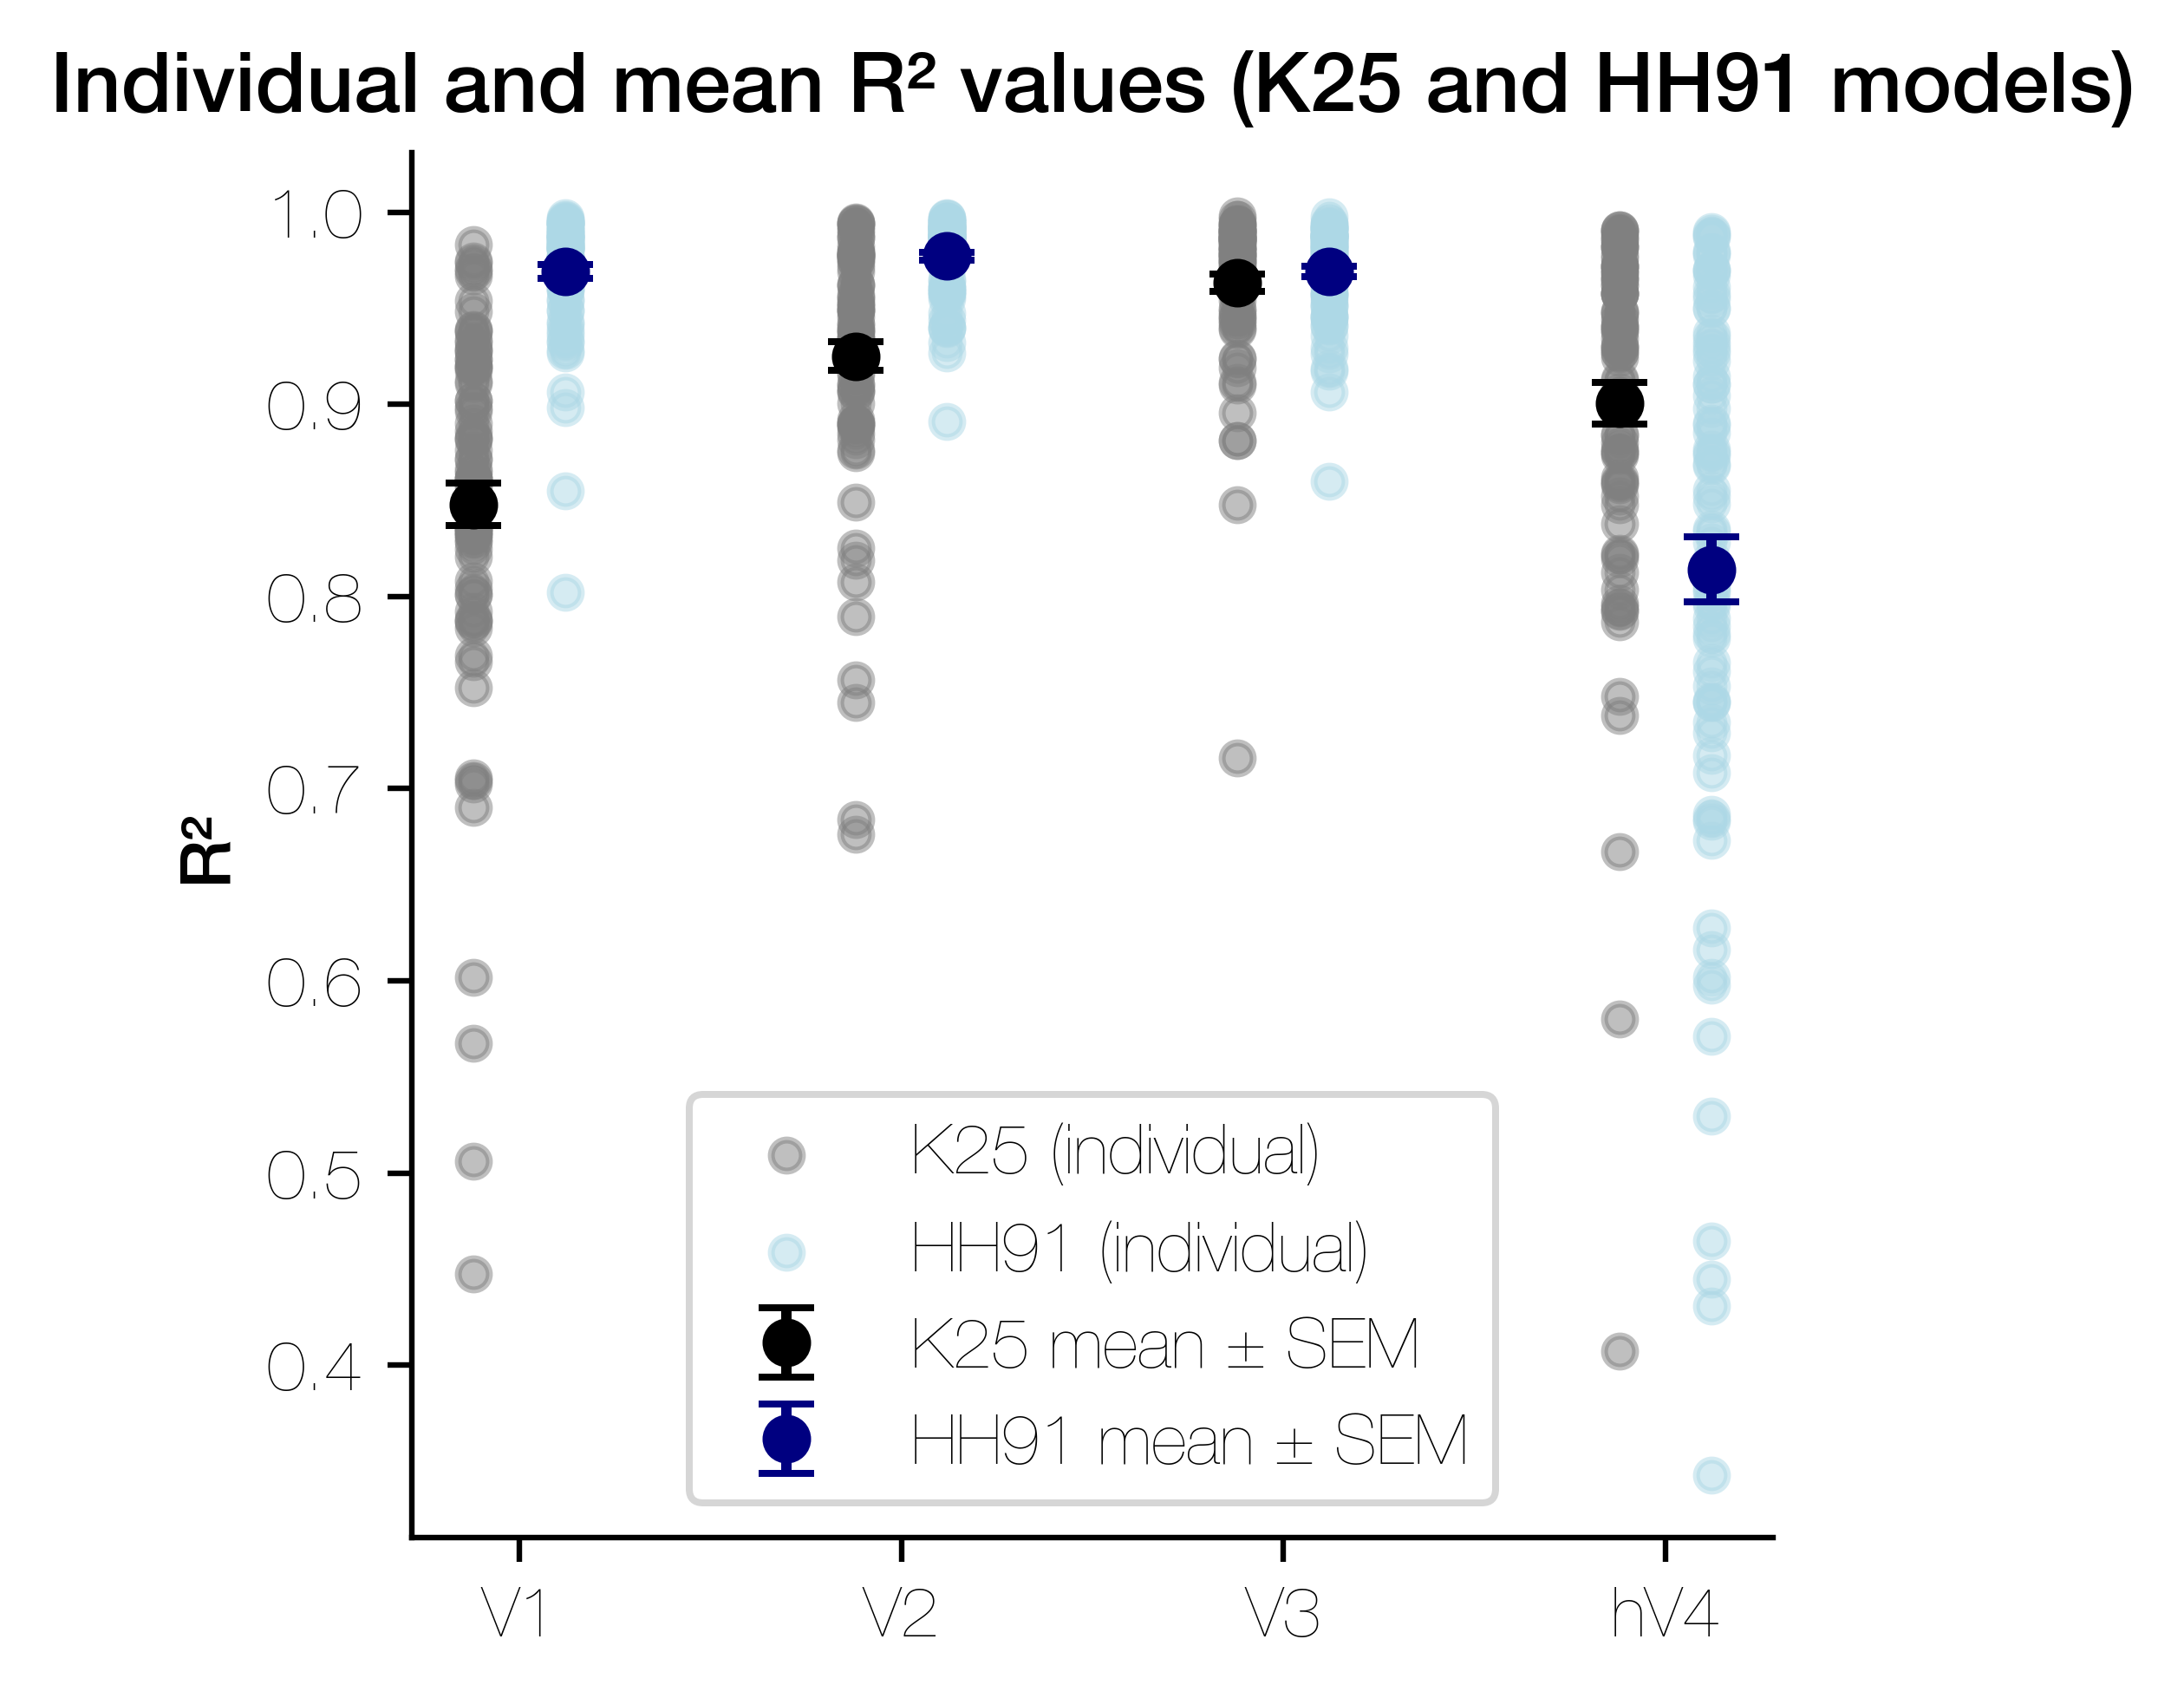

In [64]:
areas = ['V1', 'V2', 'V3', 'hV4']
labels = [1, 2, 3, 4]  


mean_r2_bouma = []
sem_r2_bouma = []
all_r2_bouma = []

mean_r2_hh91 = []
sem_r2_hh91 = []
all_r2_hh91 = []

for lbl in labels:
    # Bouma R² (from gain_df)
    r2_bouma = gain_df[gain_df['label'] == lbl]['rsq'].values
    r2_bouma = r2_bouma[r2_bouma >= 0.25]    
    all_r2_bouma.append(r2_bouma)
    mean_r2_bouma.append(np.mean(r2_bouma))
    sem_r2_bouma.append(np.std(r2_bouma) / np.sqrt(len(r2_bouma)))

    # HH91 R² (from hh91_df)
    r2_hh = hh91_df[hh91_df['label'] == lbl]['rsq_hh91'].values
    r2_hh = r2_hh[r2_hh >= 0.25]           
    all_r2_hh91.append(r2_hh)
    mean_r2_hh91.append(np.mean(r2_hh))
    sem_r2_hh91.append(np.std(r2_hh) / np.sqrt(len(r2_hh)))


mean_r2_bouma = np.array(mean_r2_bouma)
sem_r2_bouma = np.array(sem_r2_bouma)
mean_r2_hh91  = np.array(mean_r2_hh91)
sem_r2_hh91   = np.array(sem_r2_hh91)

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=72*8)

x = np.arange(len(areas))
offset = 0.12  

for i in range(len(areas)):
    r2_b = all_r2_bouma[i]
    ax.scatter(np.full_like(r2_b, x[i] - offset), r2_b,
               color='gray', alpha=0.5, s=20, label='K23 (individual)' if i == 0 else None)

    r2_h = all_r2_hh91[i]
    ax.scatter(np.full_like(r2_h, x[i] + offset), r2_h,
               color='lightblue', alpha=0.5, s=20, label='HH91 (individual)' if i == 0 else None)

# Plot mean ± SEM for each model
ax.errorbar(x - offset, mean_r2_bouma, yerr=sem_r2_bouma, fmt='o',
            capsize=4, linewidth=1.5, markersize=6, color='black', label='K23 mean ± SEM')
ax.errorbar(x + offset, mean_r2_hh91, yerr=sem_r2_hh91, fmt='o',
            capsize=4, linewidth=1.5, markersize=6, color='navy', label='HH91 mean ± SEM')

ax.set_xticks(x)
ax.set_xticklabels(areas)
ax.set_ylabel('R²')
#ax.set_xlabel('Visual area')
ax.set_title('Individual and mean R² values (K23 and HH91 models)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

plt.tight_layout()
plt.show()


## check the quality of the fits

In [113]:
# using bouma for v4 and hh91 for v1-v3
# save for all subjects
import os

save_dir = os.path.expanduser('~/for_crowding_figures_inv_Bouma_for_V4_update')
os.makedirs(save_dir, exist_ok=True)

for sid in sids_orig:

    hh91_fits = HH91_params[HH91_params['sid'] == sid]
    fig, axs = plt.subplots(4, 2, figsize=(7, 7), dpi=72*8,
                            sharex=True, sharey=True)

    for i, lbl in enumerate([1, 2, 3, 4]):   # V1, V2, V3, hV4
        for j, hemi in enumerate(['lh', 'rh']):
            ax = axs[i, j]

            # HH91 parameter row
            hfit_row = hh91_fits[
                (hh91_fits['label'] == lbl) &
                (hh91_fits['h'] == hemi)
            ]
            if len(hfit_row) == 0:
                continue

            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]

            # empirical cumulative area
            ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
            if ecc is None or len(ecc) == 0:
                continue

            ii = np.argsort(ecc)
            ecc = ecc[ii]
            srf = srf[ii]
            cum_area = np.cumsum(srf)

            # Choose model: V1–V3 HH91, V4 inverse Bouma
            if lbl in (1, 2, 3):
                cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
                model_label = "Best Fit Model"
            else:
                gain_row = gain_df[
                    (gain_df['sid'] == sid) &
                    (gain_df['hemi'] == hemi) &
                    (gain_df['label'] == lbl)
                ]
                if len(gain_row) == 0:
                    continue
                gain = gain_row['gain'].values[0]
                cumarea_fit = gain * inverse_Bouma_cumarea(ecc)
                model_label = "Best Fit Model"

            ax.plot(ecc, cumarea_fit / 100, color='blue', label=model_label)
            ax.plot(ecc, cum_area / 100,    color='gray', label="Cumulative Surface Area")

            ax.set_ylabel(r"Surface Area [cm$^2$]")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    axs[0, 1].legend()
    axs[3, 0].set_xlabel("Eccentricity [deg]")
    axs[3, 1].set_xlabel("Eccentricity [deg]")

    plt.tight_layout()

    # Save figure for this subject
    fig_path = os.path.join(save_dir, f"fits_qc_{sid}.png")
    fig.savefig(fig_path, dpi=300)
    plt.close(fig)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [34]:
#single subject below

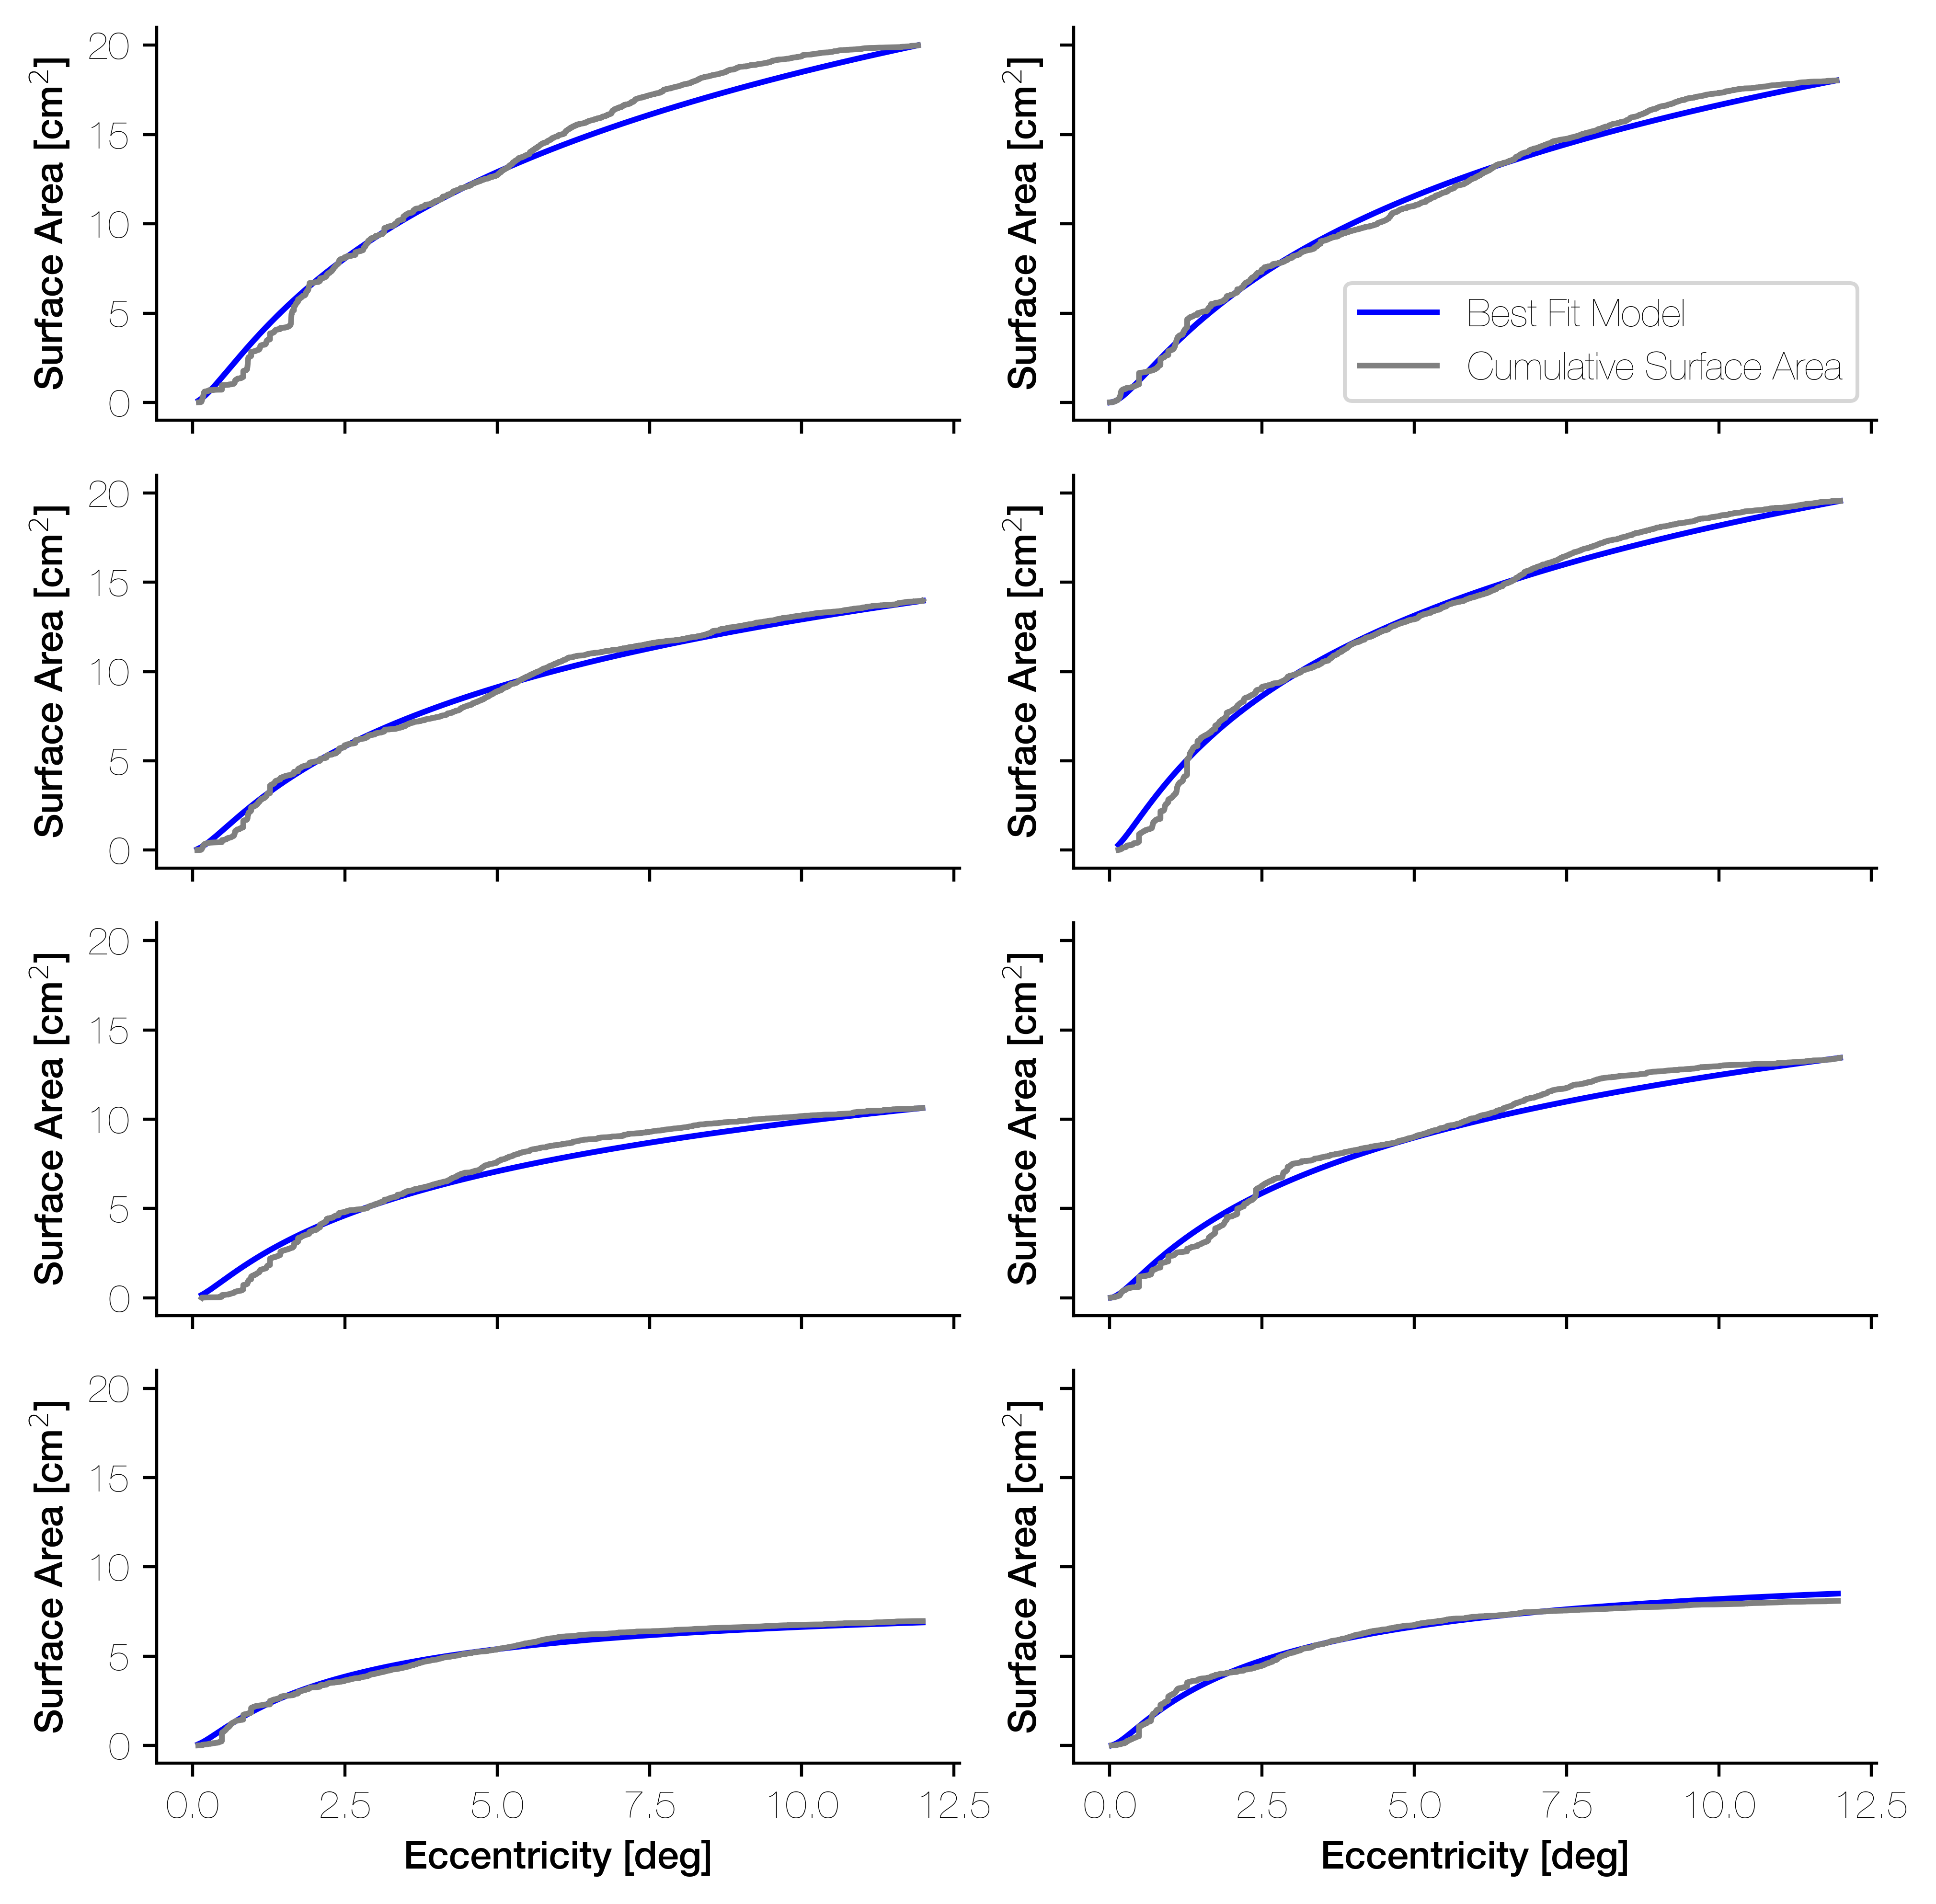

In [65]:
sid = sids_orig[1]  

hh91_fits = HH91_params[HH91_params['sid'] == sid]
fig, axs = plt.subplots(4, 2, figsize=(7, 7), dpi=72*8, sharex=True, sharey=True)

for i, lbl in enumerate([1, 2, 3, 4]): 
    for j, hemi in enumerate(['lh', 'rh']):
        ax = axs[i, j]

        hfit_row = hh91_fits[
            (hh91_fits['label'] == lbl) &
            (hh91_fits['h'] == hemi)
        ]
        if len(hfit_row) == 0:
            continue

        a = hfit_row['a'].values[0]
        b = hfit_row['b'].values[0]

        ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
        ii = np.argsort(ecc)
        ecc = ecc[ii]
        srf = srf[ii]
        cum_area = np.cumsum(srf)

        # Decide which model to plot
        if lbl in (1, 2, 3):   # V1–V3: HH91 model
            cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
            model_label = "Best Fit Model"

        else:  # V4: inverse-Bouma-based cumulative model using gain_df
            gain_row = gain_df[
                (gain_df['sid'] == sid) &
                (gain_df['hemi'] == hemi) &
                (gain_df['label'] == lbl)
            ]
            if len(gain_row) == 0:
                continue

            gain = gain_row['gain'].values[0]

            cumarea_fit = gain * inverse_Bouma_cumarea(ecc)
            model_label = "Best Fit Model"

        # Plot model vs empirical
        ax.plot(ecc, cumarea_fit / 100, label=model_label, color='blue')
        ax.plot(ecc, cum_area / 100, label="Cumulative Surface Area", color='gray')
        ax.set_ylabel(r"Surface Area [cm$^2$]")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


axs[0, 1].legend()
axs[3, 0].set_xlabel("Eccentricity [deg]")
axs[3, 1].set_xlabel("Eccentricity [deg]")

plt.tight_layout()
plt.show()


In [67]:
def norm_curve(cum):
    """Normalize a cumulative curve to go from 0 to 100."""
    return 100 * (cum - cum[0]) / (cum[-1] - cum[0])

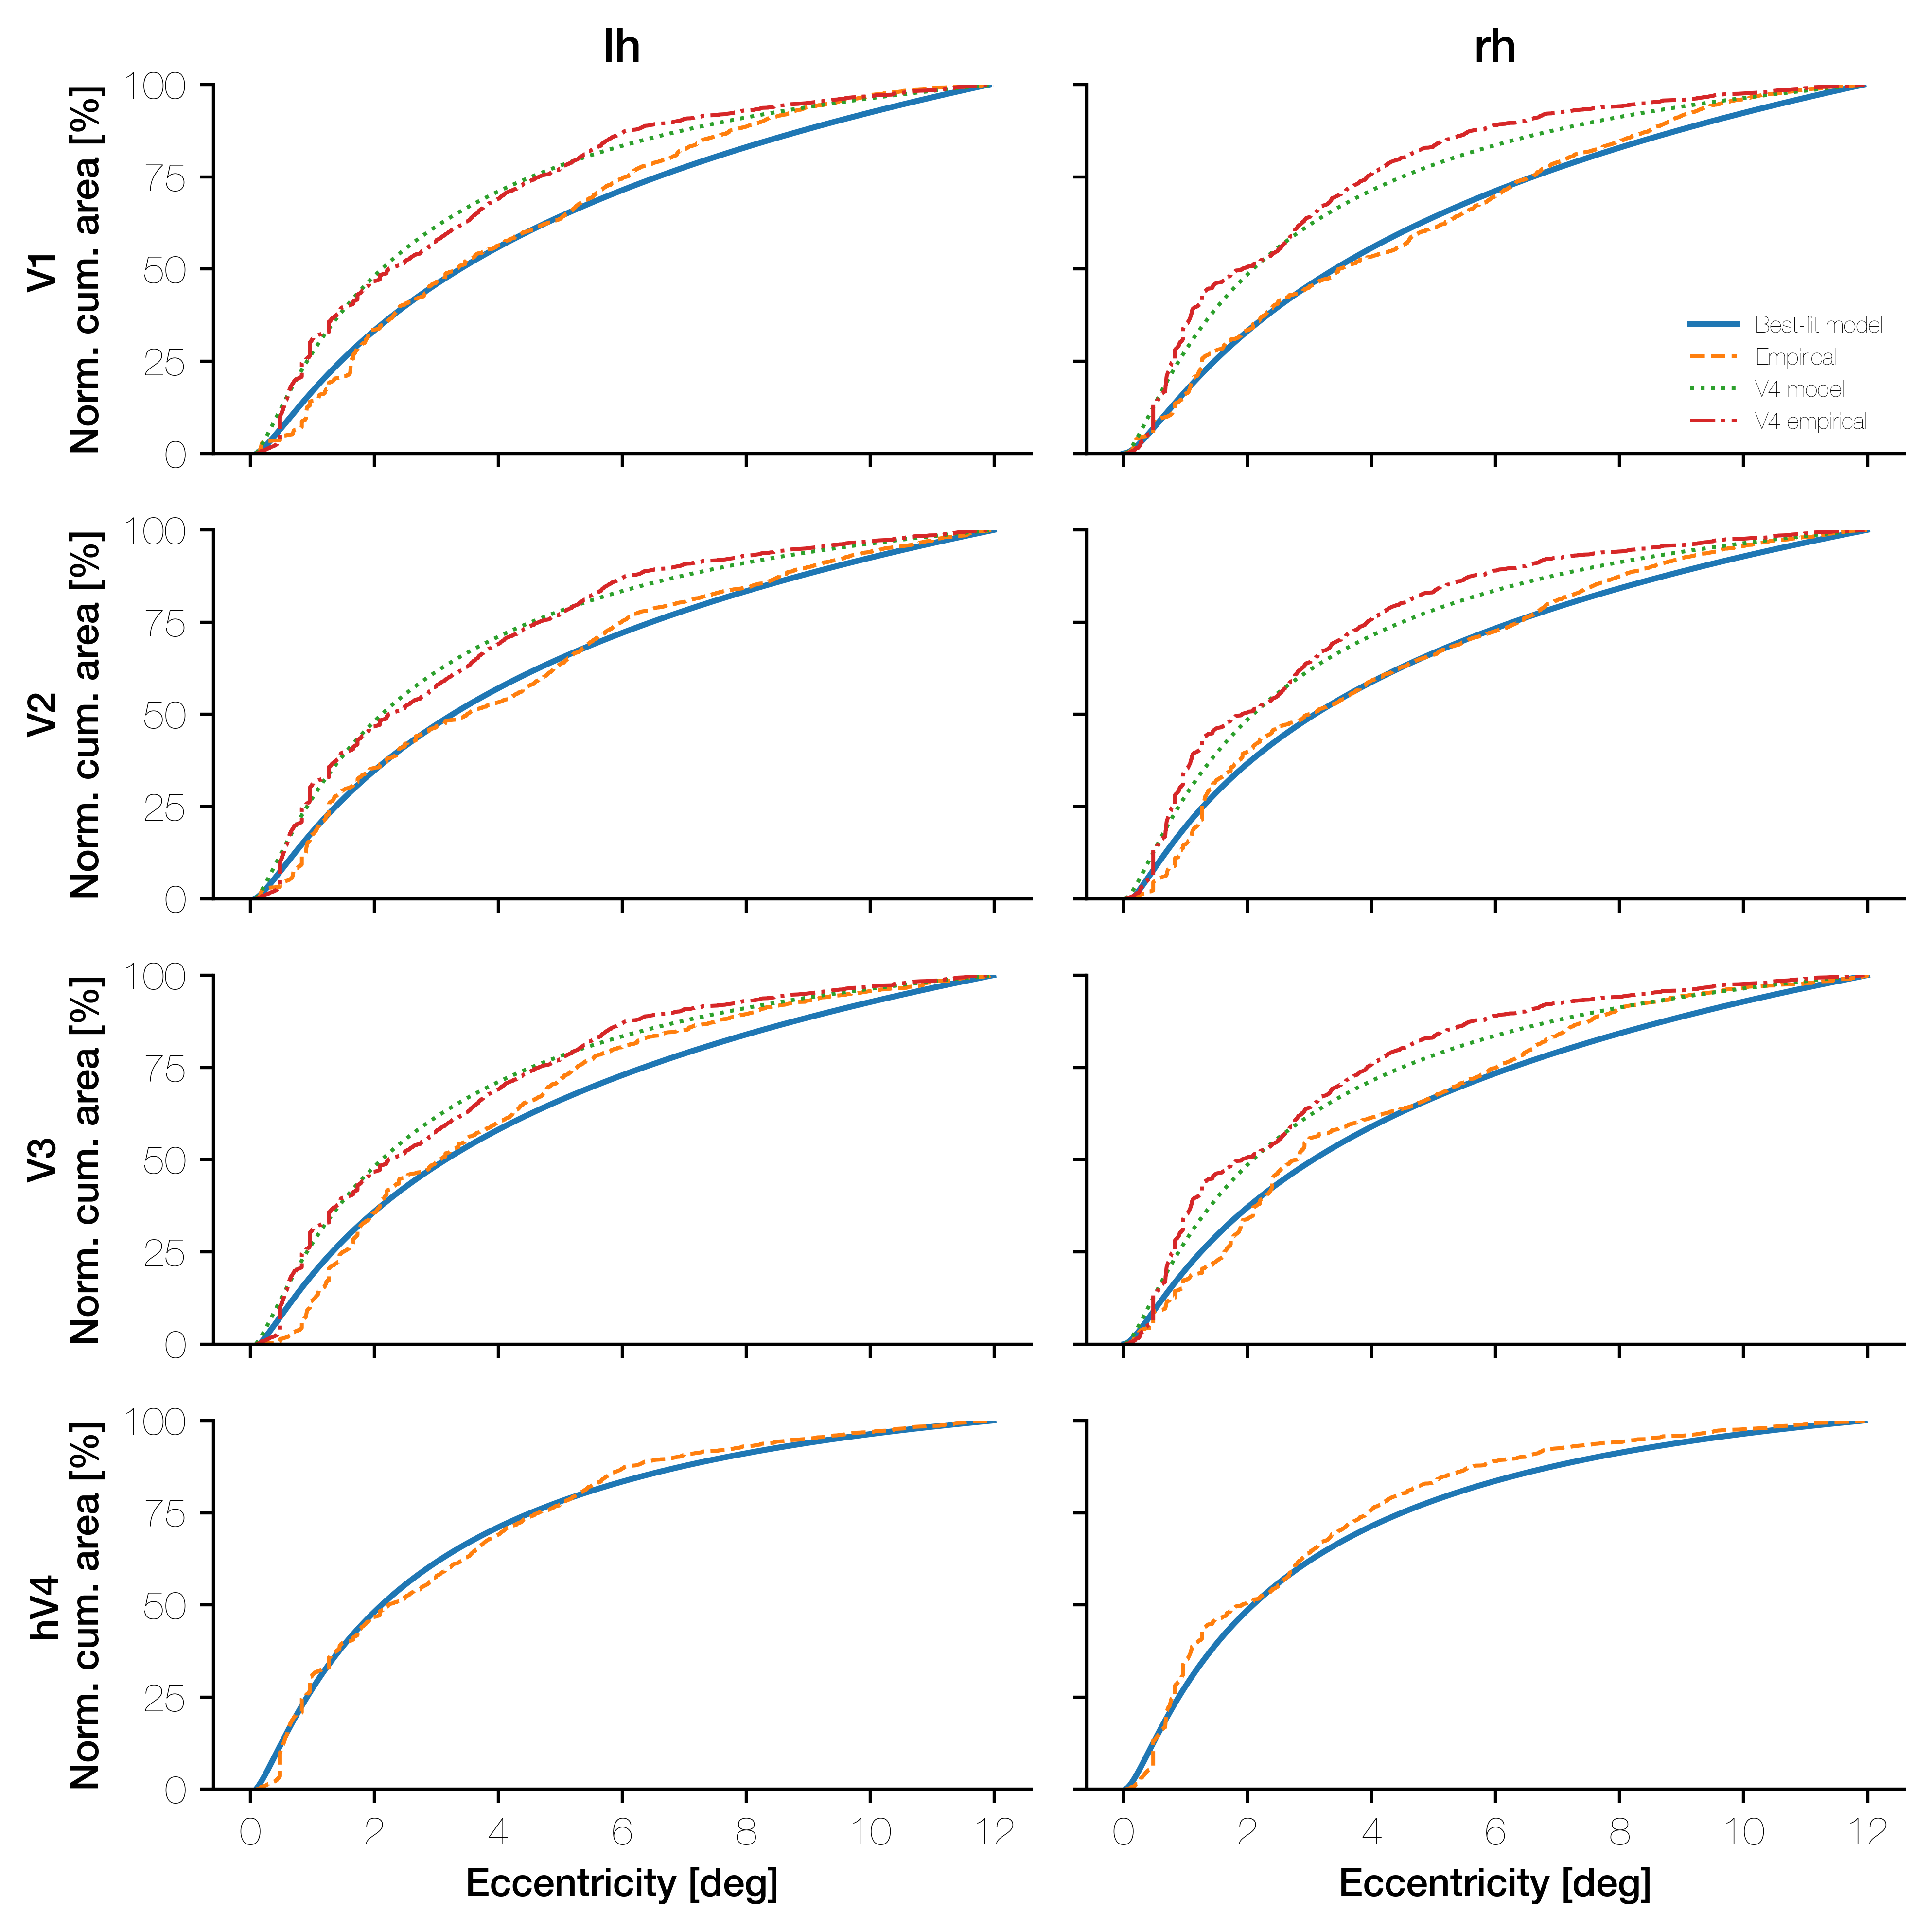

In [68]:

# def norm_curve(cum):
#     # Guard in case of degenerate curves
#     if cum[-1] == cum[0]:
#         return np.zeros_like(cum)
#     return 100 * (cum - cum[0]) / (cum[-1] - cum[0])


# Choose subject
sid = sids_orig[1]

# Get HH91 params for this subject
hh91_fits = HH91_params[HH91_params['sid'] == sid]

# Precompute V4 curves (empirical + model), normalized 0–100
v4_curves = {}  # key = 'lh'/'rh', value = dict with ecc, emp, model

for hemi in ['lh', 'rh']:
    # Get V4 surface area profile
    ecc_v4, srf_v4 = cc.cmag.cmag_basics(sid, hemi, 4)
    if ecc_v4 is None or len(ecc_v4) == 0:
        continue

    ii = np.argsort(ecc_v4)
    ecc_v4 = ecc_v4[ii]
    srf_v4 = srf_v4[ii]
    cum_v4 = np.cumsum(srf_v4)

    # Model: inverse-Bouma cumulative area scaled by gain
    gain_row = gain_df[
        (gain_df['sid'] == sid) &
        (gain_df['hemi'] == hemi) &
        (gain_df['label'] == 4)
    ]
    if len(gain_row) == 0:
        continue

    gain = gain_row['gain'].values[0]
    cumfit_v4 = gain * inverse_Bouma_cumarea(ecc_v4)

    # Normalize both curves to 0–100
    v4_emp_norm   = norm_curve(cum_v4)
    v4_model_norm = norm_curve(cumfit_v4)

    v4_curves[hemi] = {
        "ecc":   ecc_v4,
        "emp":   v4_emp_norm,
        "model": v4_model_norm,
    }


# Plotting
fig, axs = plt.subplots(4, 2, figsize=(7, 7),
                        dpi=72*8, sharex=True, sharey=True)

area_labels = {1: "V1", 2: "V2", 3: "V3", 4: "hV4"}

for i, lbl in enumerate([1, 2, 3, 4]):
    for j, hemi in enumerate(['lh', 'rh']):
        ax = axs[i, j]

        # Get fit row for this ROI & hemisphere
        hfit_row = hh91_fits[
            (hh91_fits['label'] == lbl) &
            (hh91_fits['h'] == hemi)
        ]
        if len(hfit_row) == 0:
            continue

        # Get eccentricity and surface area for this ROI
        ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
        if ecc is None or len(ecc) == 0:
            continue

        ii = np.argsort(ecc)
        ecc = ecc[ii]
        srf = srf[ii]
        cum_area = np.cumsum(srf)

        # Decide which model to use
        if lbl in (1, 2, 3):  # V1–V3: HH91 model
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]
            cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)

        else:  # V4: inverse-Bouma-based model
            gain_row = gain_df[
                (gain_df['sid'] == sid) &
                (gain_df['hemi'] == hemi) &
                (gain_df['label'] == lbl)
            ]
            if len(gain_row) == 0:
                continue
            gain = gain_row['gain'].values[0]
            cumarea_fit = gain * inverse_Bouma_cumarea(ecc)

        # Normalize empirical + model to 0–100
        cum_area_norm   = norm_curve(cum_area)
        cumarea_fit_norm = norm_curve(cumarea_fit)

        # Plot empirical + model for this ROI
        ax.plot(ecc, cumarea_fit_norm,
                label="Best-fit model", lw=1.5)
        ax.plot(ecc, cum_area_norm,
                label="Empirical", lw=1.0, linestyle='--')

        # Overlay V4 curves on V1–V3
        if lbl in (1, 2, 3) and hemi in v4_curves:
            v4 = v4_curves[hemi]
            ax.plot(v4["ecc"], v4["model"],
                    linestyle=':', lw=1.0,
                    label="V4 model")
            ax.plot(v4["ecc"], v4["emp"],
                    linestyle='-.', lw=1.0,
                    label="V4 empirical")

        # Cosmetics
        ax.set_ylim(0, 100)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if j == 0:
            ax.set_ylabel(f"{area_labels[lbl]}\nNorm. cum. area [%]")

        if i == 0:
            ax.set_title(f"{hemi}")

# Shared x-labels
axs[3, 0].set_xlabel("Eccentricity [deg]")
axs[3, 1].set_xlabel("Eccentricity [deg]")

# Only one legend (top-right panel)
axs[0, 1].legend(fontsize=6, frameon=False)

plt.tight_layout()
plt.show()


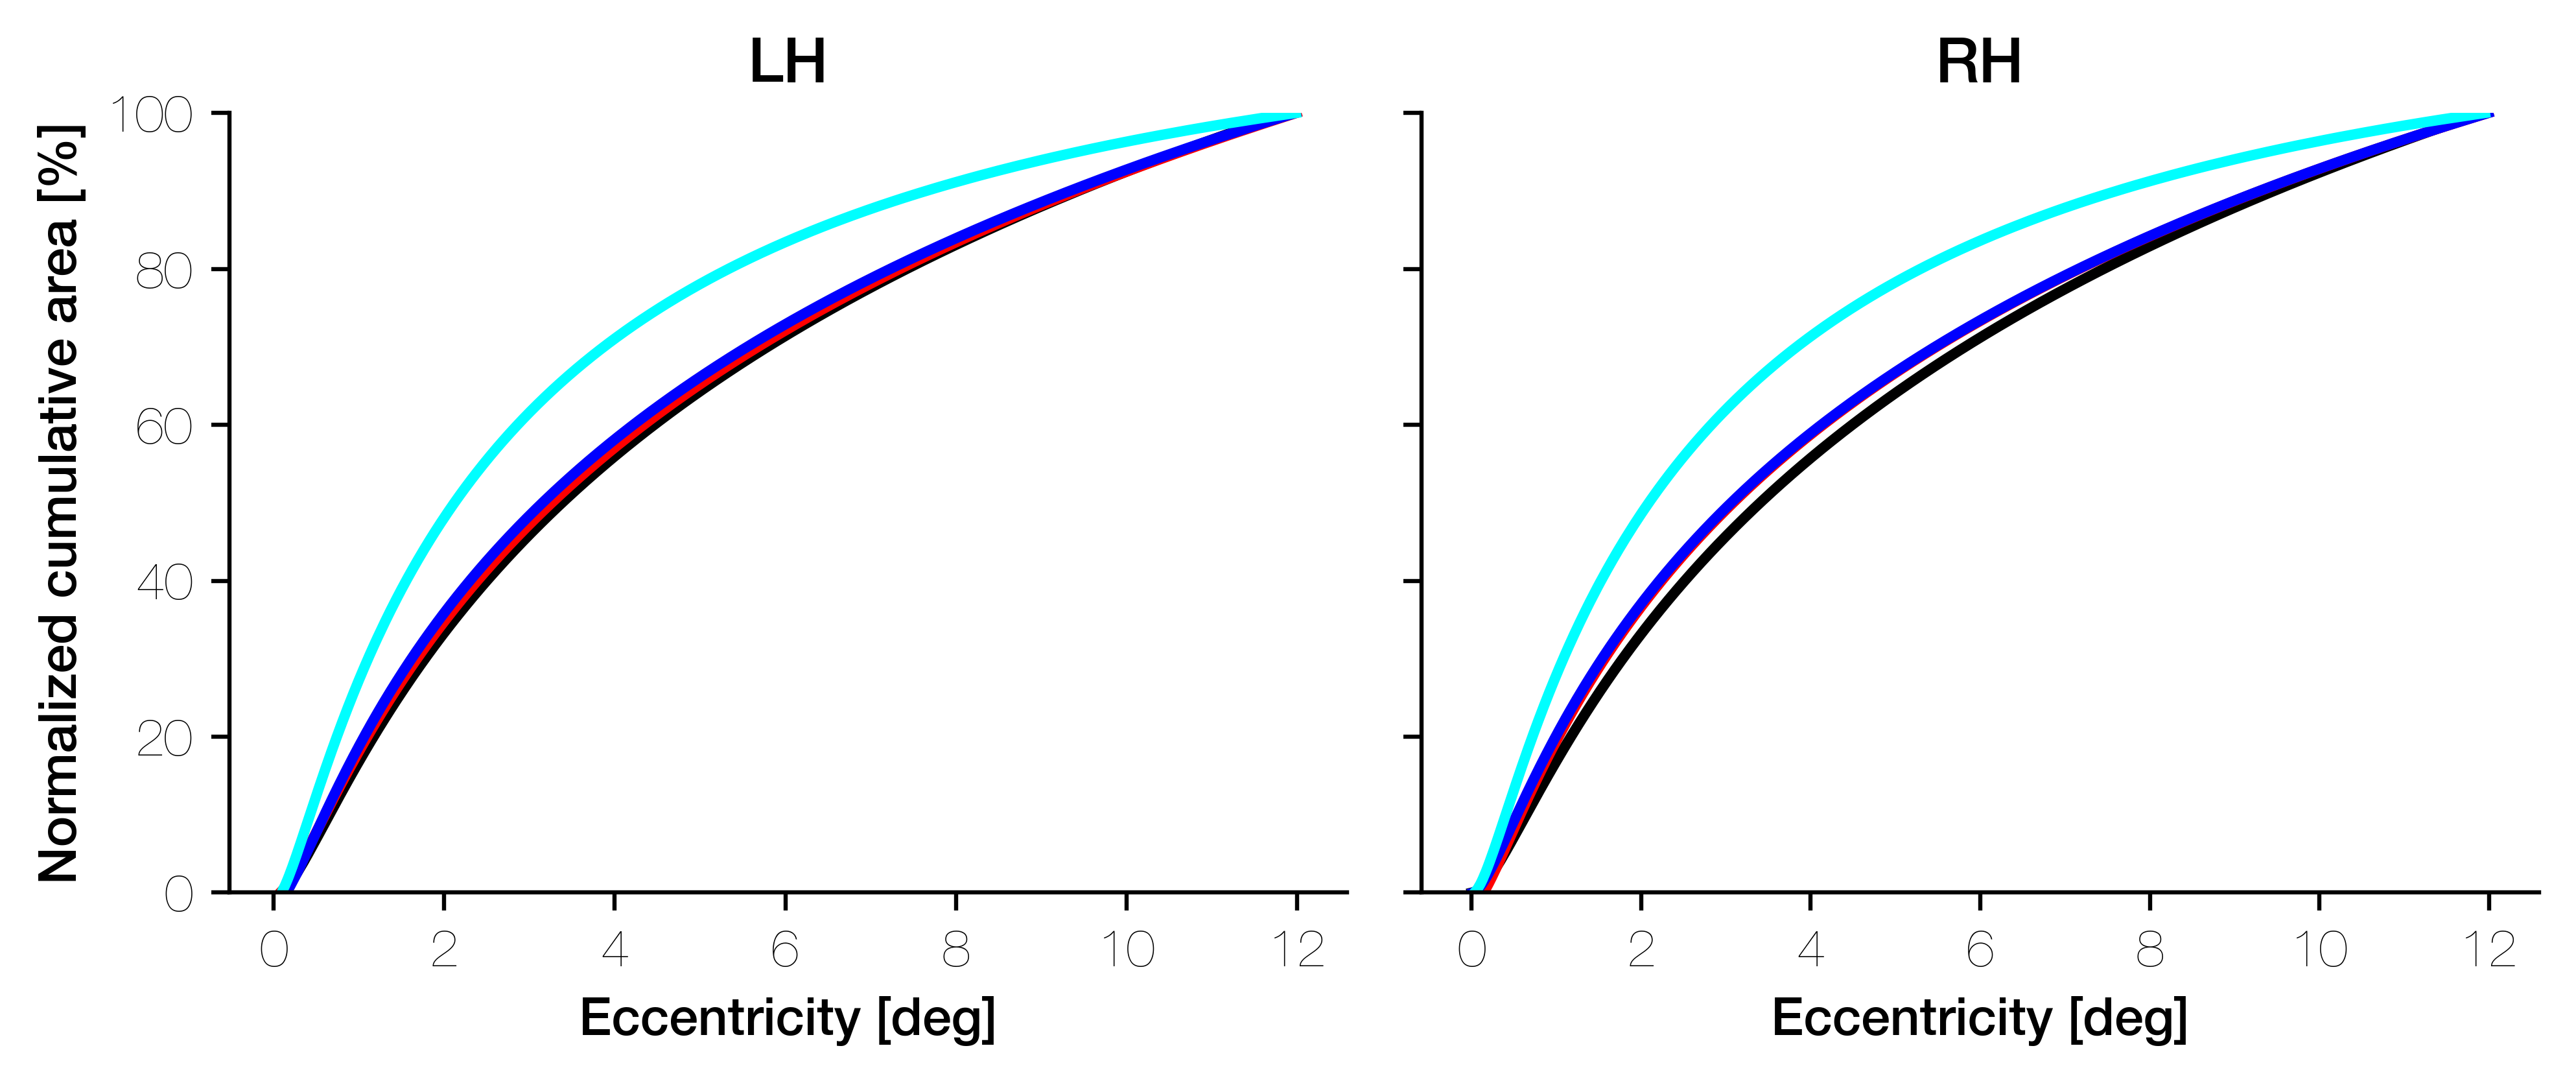

In [85]:
def norm_curve(cum):
    """Normalize a cumulative curve to go from 0 to 100."""
    return 100 * (cum - cum[0]) / (cum[-1] - cum[0])


sid = sids_orig[1]
hh91_fits = HH91_params[HH91_params['sid'] == sid]

# Color + label maps
area_labels = {1: "V1", 2: "V2", 3: "V3", 4: "hV4"}
area_colors = {1: "black", 2: "red", 3: "blue", 4: "cyan"}

fig, axs = plt.subplots(1, 2, figsize=(7, 3), dpi=72*8, sharey=True)

for j, hemi in enumerate(['lh', 'rh']):
    ax = axs[j]

    for lbl in [1, 2, 3, 4]:

        # -- get model parameters --
        hfit_row = hh91_fits[
            (hh91_fits['label'] == lbl) &
            (hh91_fits['h'] == hemi)
        ]
        if len(hfit_row) == 0:
            continue

        # -- load measured cumulative area --
        ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
        if ecc is None or len(ecc) == 0:
            continue

        ii = np.argsort(ecc)
        ecc = ecc[ii]
        srf = srf[ii]
        cum_area = np.cumsum(srf)

        # -- model logic --
        if lbl in (1, 2, 3):  # HH91 for V1–V3
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]
            cumfit = cc.cmag.HH91_integral(ecc, a, b)
        else:                # inverse Bouma for V4
            gain_row = gain_df[
                (gain_df['sid'] == sid) &
                (gain_df['hemi'] == hemi) &
                (gain_df['label'] == lbl)
            ]
            if len(gain_row) == 0:
                continue
            gain = gain_row['gain'].values[0]
            cumfit = gain * inverse_Bouma_cumarea(ecc)

        # -- normalize model curve --
        cumfit_norm = norm_curve(cumfit)

        # -- plot model only, with custom color --
        ax.plot(
            ecc, cumfit_norm,
            lw=2,
            color=area_colors[lbl],
            label=area_labels[lbl]
        )

    ax.set_title(hemi.upper())
    ax.set_xlabel("Eccentricity [deg]")
    ax.set_ylim(0, 100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].set_ylabel("Normalized cumulative area [%]")

# Legend only on right panel
#axs[1].legend(title="Area", fontsize=10)

plt.tight_layout()
plt.show()


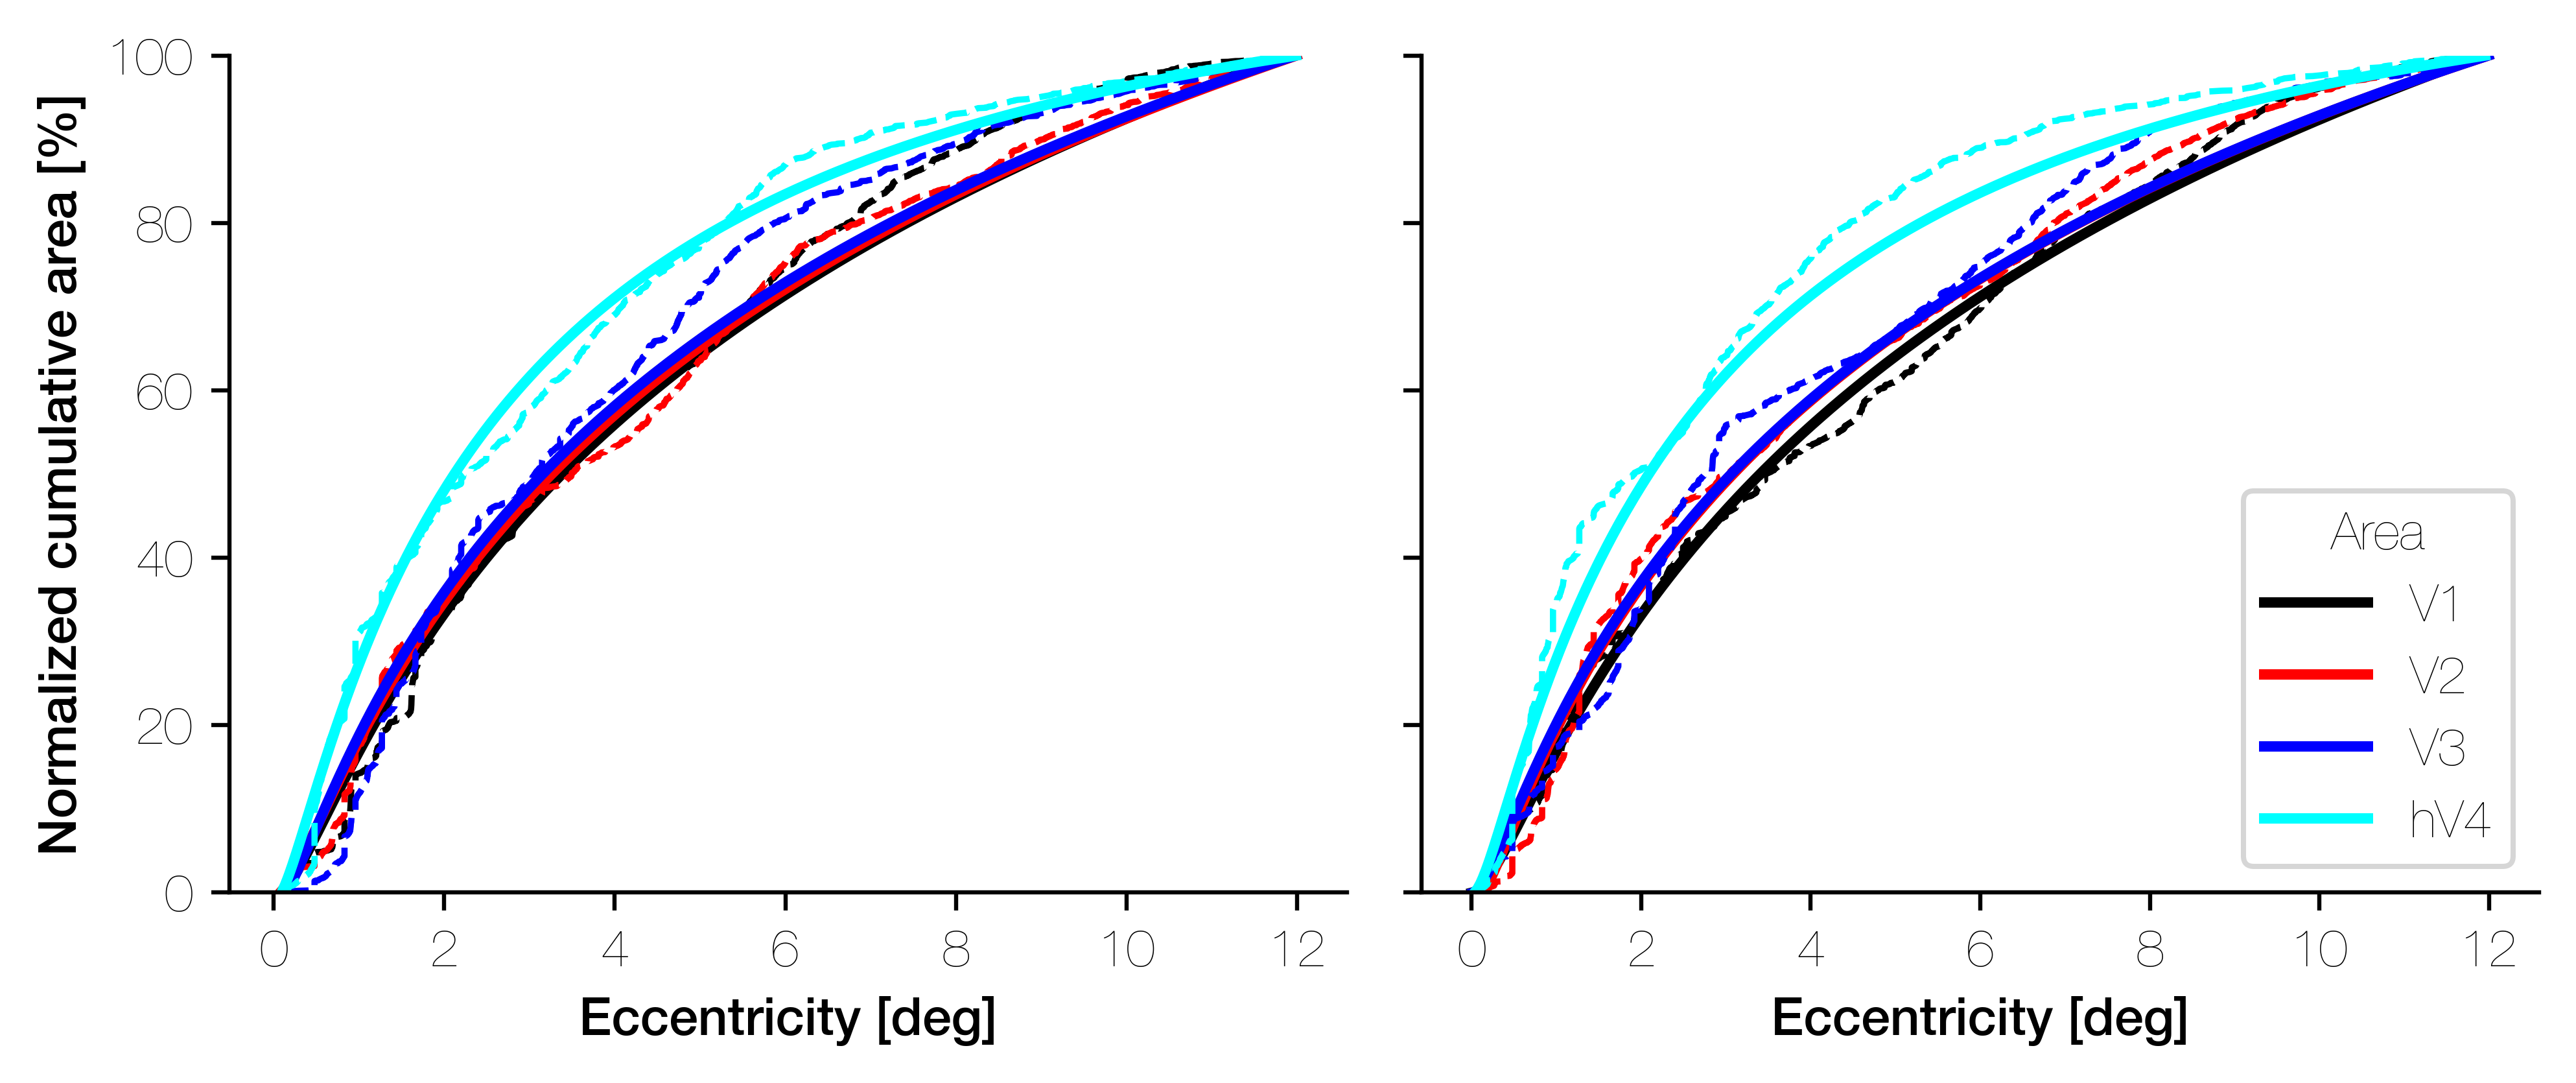

In [83]:

def norm_curve(cum):
    return 100 * (cum - cum[0]) / (cum[-1] - cum[0]) if cum[-1] != cum[0] else np.zeros_like(cum)


sid = sids_orig[1]
hh91_fits = HH91_params[HH91_params['sid'] == sid]


area_colors = {
    1: "black",
    2: "red",
    3: "blue",
    4: "cyan",
}
area_labels = {
    1: "V1",
    2: "V2",
    3: "V3",
    4: "hV4",
}

fig, axs = plt.subplots(1, 2, figsize=(7, 3), dpi=72*8, sharey=True)

for j, hemi in enumerate(["lh", "rh"]):
    ax = axs[j]

    for lbl in [1, 2, 3, 4]:

        # get HH91 params if available
        hfit_row = hh91_fits[
            (hh91_fits["label"] == lbl) &
            (hh91_fits["h"] == hemi)
        ]
        if len(hfit_row) == 0:
            continue

        # load surface area data
        ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
        if ecc is None or len(ecc) == 0:
            continue

        # sort by eccentricity
        ii = np.argsort(ecc)
        ecc = ecc[ii]
        srf = srf[ii]
        cum_area = np.cumsum(srf)
        cum_area_norm = norm_curve(cum_area)

        # Model
        if lbl in (1, 2, 3):   # HH91
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]
            cumfit = cc.cmag.HH91_integral(ecc, a, b)

        else:  # V4 inverse Bouma
            gain_row = gain_df[
                (gain_df["sid"] == sid) &
                (gain_df["hemi"] == hemi) &
                (gain_df["label"] == lbl)
            ]
            if len(gain_row) == 0:
                continue

            gain = gain_row['gain'].values[0]
            cumfit = gain * inverse_Bouma_cumarea(ecc)

        cumfit_norm = norm_curve(cumfit)

        # ----- Plot -----
        color = area_colors[lbl]

        # Model = solid
        ax.plot(ecc, cumfit_norm,
                color=color, lw=2,
                label=area_labels[lbl] if j == 1 else None)

        # Empirical = dashed
        ax.plot(ecc, cum_area_norm,
                color=color, lw=1.2, linestyle="--")

    # Axis cosmetics
    #ax.set_title(f"{hemi.upper()}", fontsize=12)
    ax.set_xlabel("Eccentricity [deg]")
    ax.set_ylim(0, 100)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axs[0].set_ylabel("Normalized cumulative area [%]")
axs[1].legend(title="Area", fontsize=10)

plt.tight_layout()
plt.show()


In [32]:
# sid = sids_orig[1]  # choose subject
# sid_idx = list(sids_orig).index(sid)

# hh91_fits = HH91_params[HH91_params['sid'] == sid]
# fig, axs = plt.subplots(4, 2, figsize=(7, 7), dpi=72*8, sharex=True, sharey=True)

# for i, lbl in enumerate([1, 2, 3, 4]):  # V1–V4
#     for j, hemi in enumerate(['lh', 'rh']):
#         ax = axs[i, j]
#         hfit_row = hh91_fits[
#             (hh91_fits['label'] == lbl) &
#             (hh91_fits['h'] == hemi)
#         ]
#         if len(hfit_row) == 0:
#             continue

#         # --- HH91 params ---
#         a = hfit_row['a'].values[0]
#         b = hfit_row['b'].values[0]

#         # --- empirical data ---
#         ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
#         ii = np.argsort(ecc)
#         ecc = ecc[ii]
#         srf = srf[ii]
#         cum_area = np.cumsum(srf)

#         # --- choose model ---
#         if lbl in (1, 2, 3):   # V1–V3: HH91
#             cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
#             panel_text = "model: Horton & Hoyt"
#         else:                  # V4: Bouma inverse model
#             gain_row = gain_df[
#                 (gain_df['sid'] == sid) &
#                 (gain_df['hemi'] == hemi) &
#                 (gain_df['label'] == lbl)
#             ]
#             if len(gain_row) == 0:
#                 continue
#             gain = gain_row['gain'].values[0]
#             cumarea_fit = gain * cmag_bouma_form(ecc)
#             panel_text = "model: inverse-Bouma"

#         # --- Plot ---
#         ax.plot(ecc, cumarea_fit / 100, color='blue', label="Best Fit Model")
#         ax.plot(ecc, cum_area / 100, color='gray', label="Cumulative Surface Area")

#         ax.set_ylabel(r"Surface Area [cm$^2$]")
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)

#         # --- Add panel text (blue, 10-pt font) ---
#         ax.text(
#             0.05, 0.90,
#             panel_text,
#             transform=ax.transAxes,
#             fontsize=10,
#             color='blue'
#         )

# # global legend (only once)
# handles, labels = axs[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', fontsize=10)

# axs[3,0].set_xlabel("Eccentricity [deg]")
# axs[3,1].set_xlabel("Eccentricity [deg]")

# plt.tight_layout()
# plt.show()


In [77]:
res_mix = {'lh': [[], [], [], []], 'rh': [[], [], [], []]}
std_ecc = np.linspace(1, 12, 100)

for sid in sids_orig:
    hh91_fits = HH91_params[HH91_params['sid'] == sid]

    for i, lbl in enumerate([1, 2, 3, 4]):  
        for hemi in ['lh', 'rh']:
            hfit_row = hh91_fits[
                (hh91_fits['label'] == lbl) &
                (hh91_fits['h'] == hemi)
            ]
            if len(hfit_row) == 0:
                continue

            # HH91 params
            a = hfit_row['a'].values[0]
            b = hfit_row['b'].values[0]

            # cum area data
            ecc, srf = cc.cmag.cmag_basics(sid, hemi, lbl)
            ii = np.argsort(ecc)
            ecc = ecc[ii]
            srf = srf[ii]
            cum_area = np.cumsum(srf)

            if lbl in (1, 2, 3):  # V1–V3: HH91 model
                cumarea_fit = cc.cmag.HH91_integral(ecc, a, b)
            else:  # V4: crowding-based 
                gain_row = gain_df[
                    (gain_df['sid'] == sid) &
                    (gain_df['hemi'] == hemi) &
                    (gain_df['label'] == lbl)
                ]

                gain = gain_row['gain'].values[0]
                cumarea_fit = gain * inverse_Bouma_cumarea(ecc)

            # resample both onto common eccentricity grid
            cum_area_std    = np.interp(std_ecc, ecc, cum_area)
            cumarea_fit_std = np.interp(std_ecc, ecc, cumarea_fit)

            # percent error relative to model
            percent_err = (cumarea_fit_std - cum_area_std) / cumarea_fit_std * 100
            percent_err[std_ecc > np.max(ecc)] = np.nan  

            res_mix[hemi][lbl - 1].append(percent_err)

diffs_mix = {h: np.array(dat) for (h, dat) in res_mix.items()}


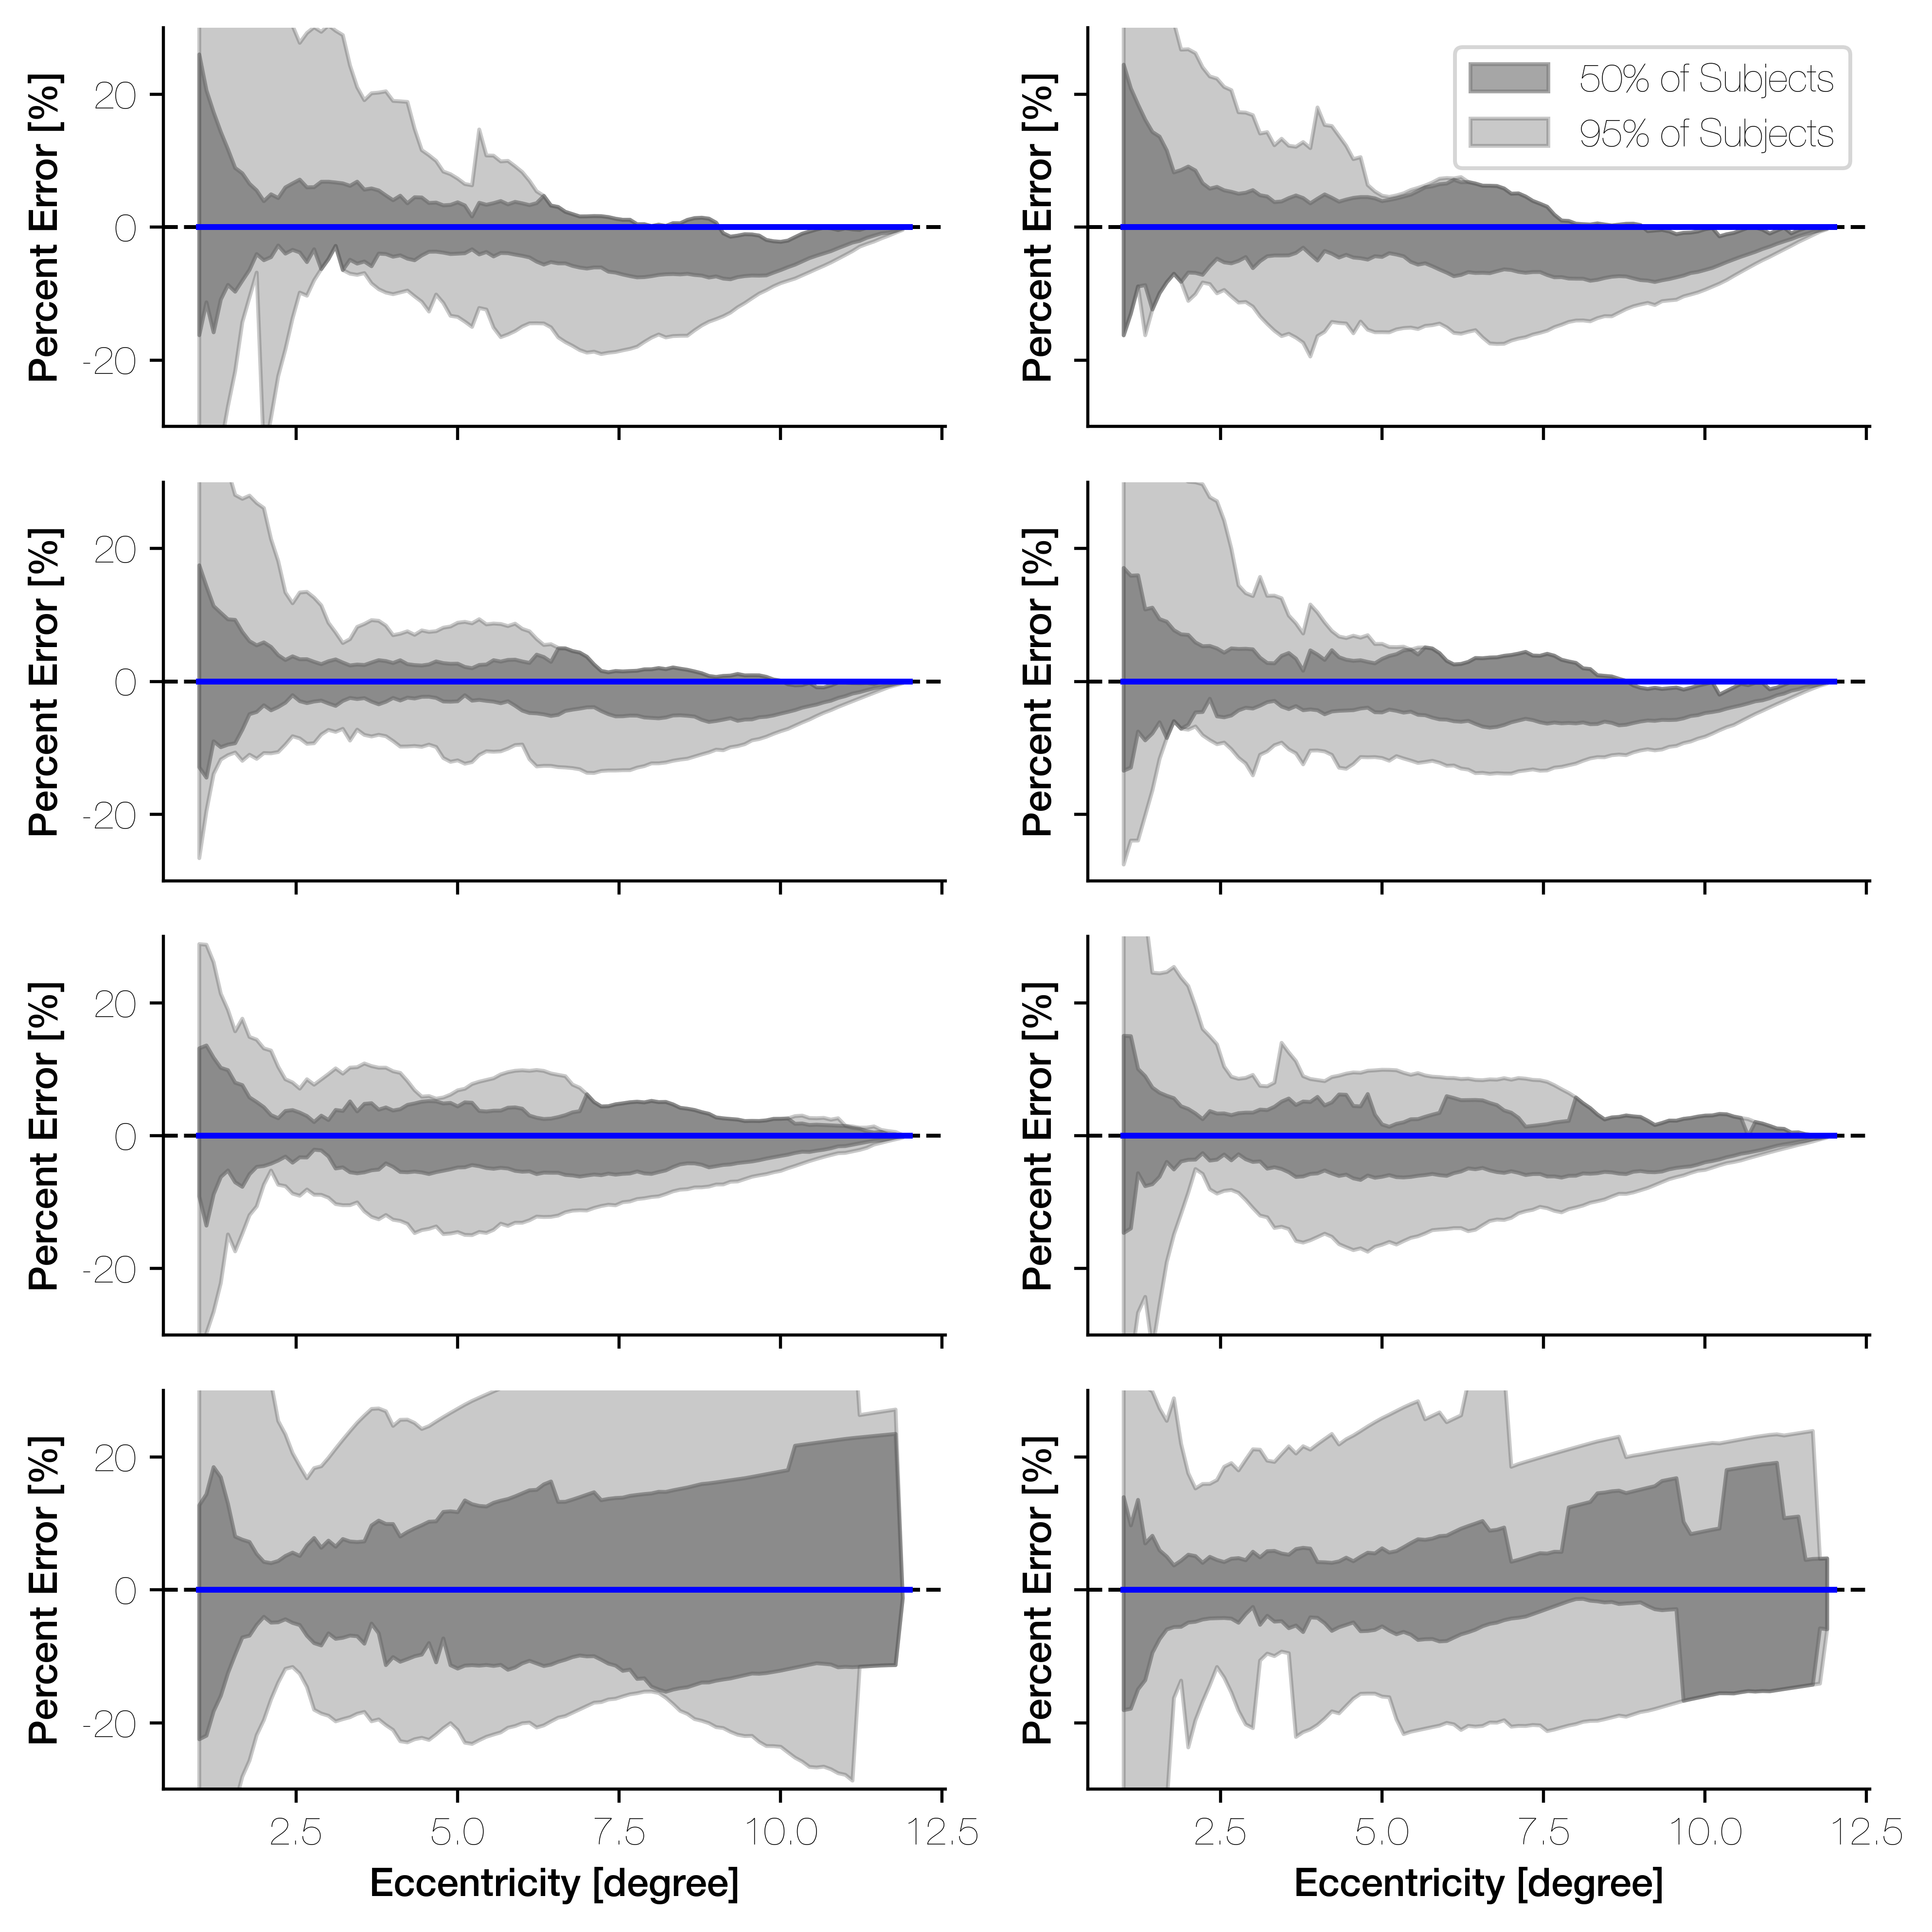

In [78]:
fig, axs = plt.subplots(4, 2, figsize=(7, 7), dpi=72*8,
                        sharex=True, sharey=True)

for i, lbl in enumerate([1, 2, 3, 4]):    
    for j, hemi in enumerate(['lh', 'rh']):  
        ax = axs[i, j]

        diff_mtx = diffs_mix[hemi][lbl - 1]  
        diff_mtx = np.where(np.isfinite(diff_mtx), diff_mtx, np.nan)

        med_low, med_high = cc.cmag.signed_bounds_from_abs_ranking(diff_mtx, 50)
        p95_low, p95_high = cc.cmag.signed_bounds_from_abs_ranking(diff_mtx, 95)

        ax.axhline(0, linestyle='--', color='black', linewidth=1)

        ax.fill_between(std_ecc, med_low, med_high,
                        color='0.5', alpha=0.7, label='50% of Subjects')
        ax.fill_between(std_ecc, p95_low, p95_high,
                        color='0.3', alpha=0.3, label='95% of Subjects')
        ax.plot(std_ecc, np.zeros_like(std_ecc), color='blue')

        ax.set_ylabel(r'Percent Error [%]')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([-30, 30])

        if i == 0 and j == 1:
            ax.legend(fontsize=10, loc='upper right')

axs[3, 0].set_xlabel('Eccentricity [degree]')
axs[3, 1].set_xlabel('Eccentricity [degree]')

plt.tight_layout()
plt.show()


## bootstrap on C.Mag fits and plot C.Mag against eccentricity

In [86]:
# mean a,b fits per label
mean_params = HH91_params.groupby('label')[['a', 'b']].mean().reset_index()
np.round(mean_params,2)

label      a     b
0      1  16.13  0.94
1      2  13.62  0.51
2      3  10.71  0.27
3      4   6.54  0.17

In [87]:
x = np.linspace(0.5, 11, 1000)
cmag_per_label = {}

# fitted Cmag for each area v1-v3
for _, row in mean_params.iterrows():
    label = row['label']
    a = row['a']
    b = row['b']
    cmag_r = (a / (b + x))**2
    cmag_per_label[label] = cmag_r


In [88]:
# also calculate std of a,b parameters
np.round(HH91_params.groupby('label')[['a', 'b']].agg(['mean', 'std']).reset_index(),2)

label      a           b      
          mean   std  mean   std
0     1  16.13  2.22  0.94  0.68
1     2  13.62  1.73  0.51  0.28
2     3  10.71  1.46  0.27  0.18
3     4   6.54  1.83  0.17  0.27

In [89]:
gain_v4_vals = gain_df[gain_df['label'] == 4]['gain'].values
mean_gain_v4 = np.mean(np.sqrt(gain_v4_vals))
# Bouma-based cmag for hV4
cmag_v4_bouma = mean_gain_v4/ Bouma(x)

cmag_per_label[4] = cmag_v4_bouma


In [90]:
num_bootstrap_samples = 10000
bootstrap_cmag_per_label = {}

for lbl in [1, 2, 3, 4]:

    if lbl in [1, 2, 3]:
        # ---- HH91 bootstrap ----
        df_lbl = HH91_params[HH91_params['label']==lbl]
        a_values = df_lbl['a'].values
        b_values = df_lbl['b'].values
        n = len(a_values)
    
        boot_curves = []
        for _ in range(num_bootstrap_samples):
            idx = np.random.choice(n, size=n, replace=True)
            mean_a = np.mean(a_values[idx])
            mean_b = np.mean(b_values[idx])
            cmag_boot = (mean_a / (mean_b + x))**2
            boot_curves.append(cmag_boot)

        bootstrap_cmag_per_label[lbl] = np.array(boot_curves)

    else:
        # ---- V4: Bouma bootstrap ----
        gain_values = gain_df[gain_df['label']==4]['gain'].values
        n = len(gain_values)
        
        boot_curves = []
        for _ in range(num_bootstrap_samples):
            idx = np.random.choice(n, size=n, replace=True)
            mean_gain = np.mean(np.sqrt(gain_values[idx]))
            cmag_boot = mean_gain / Bouma(x)
            boot_curves.append(cmag_boot)

        bootstrap_cmag_per_label[lbl] = np.array(boot_curves)


In [91]:
bootstrapped_v1 = bootstrap_cmag_per_label[1]
bootstrapped_v2 = bootstrap_cmag_per_label[2]
bootstrapped_v3 = bootstrap_cmag_per_label[3]
bootstrapped_v4 = bootstrap_cmag_per_label[4]

In [92]:
confidence_interval_v1 = np.percentile(bootstrapped_v1, [2.5, 97.5], axis=0)
confidence_interval_v2 = np.percentile(bootstrapped_v2, [2.5, 97.5], axis=0)
confidence_interval_v3 = np.percentile(bootstrapped_v3, [2.5, 97.5], axis=0)
confidence_interval_v4 = np.percentile(bootstrapped_v4, [2.5, 97.5], axis=0)

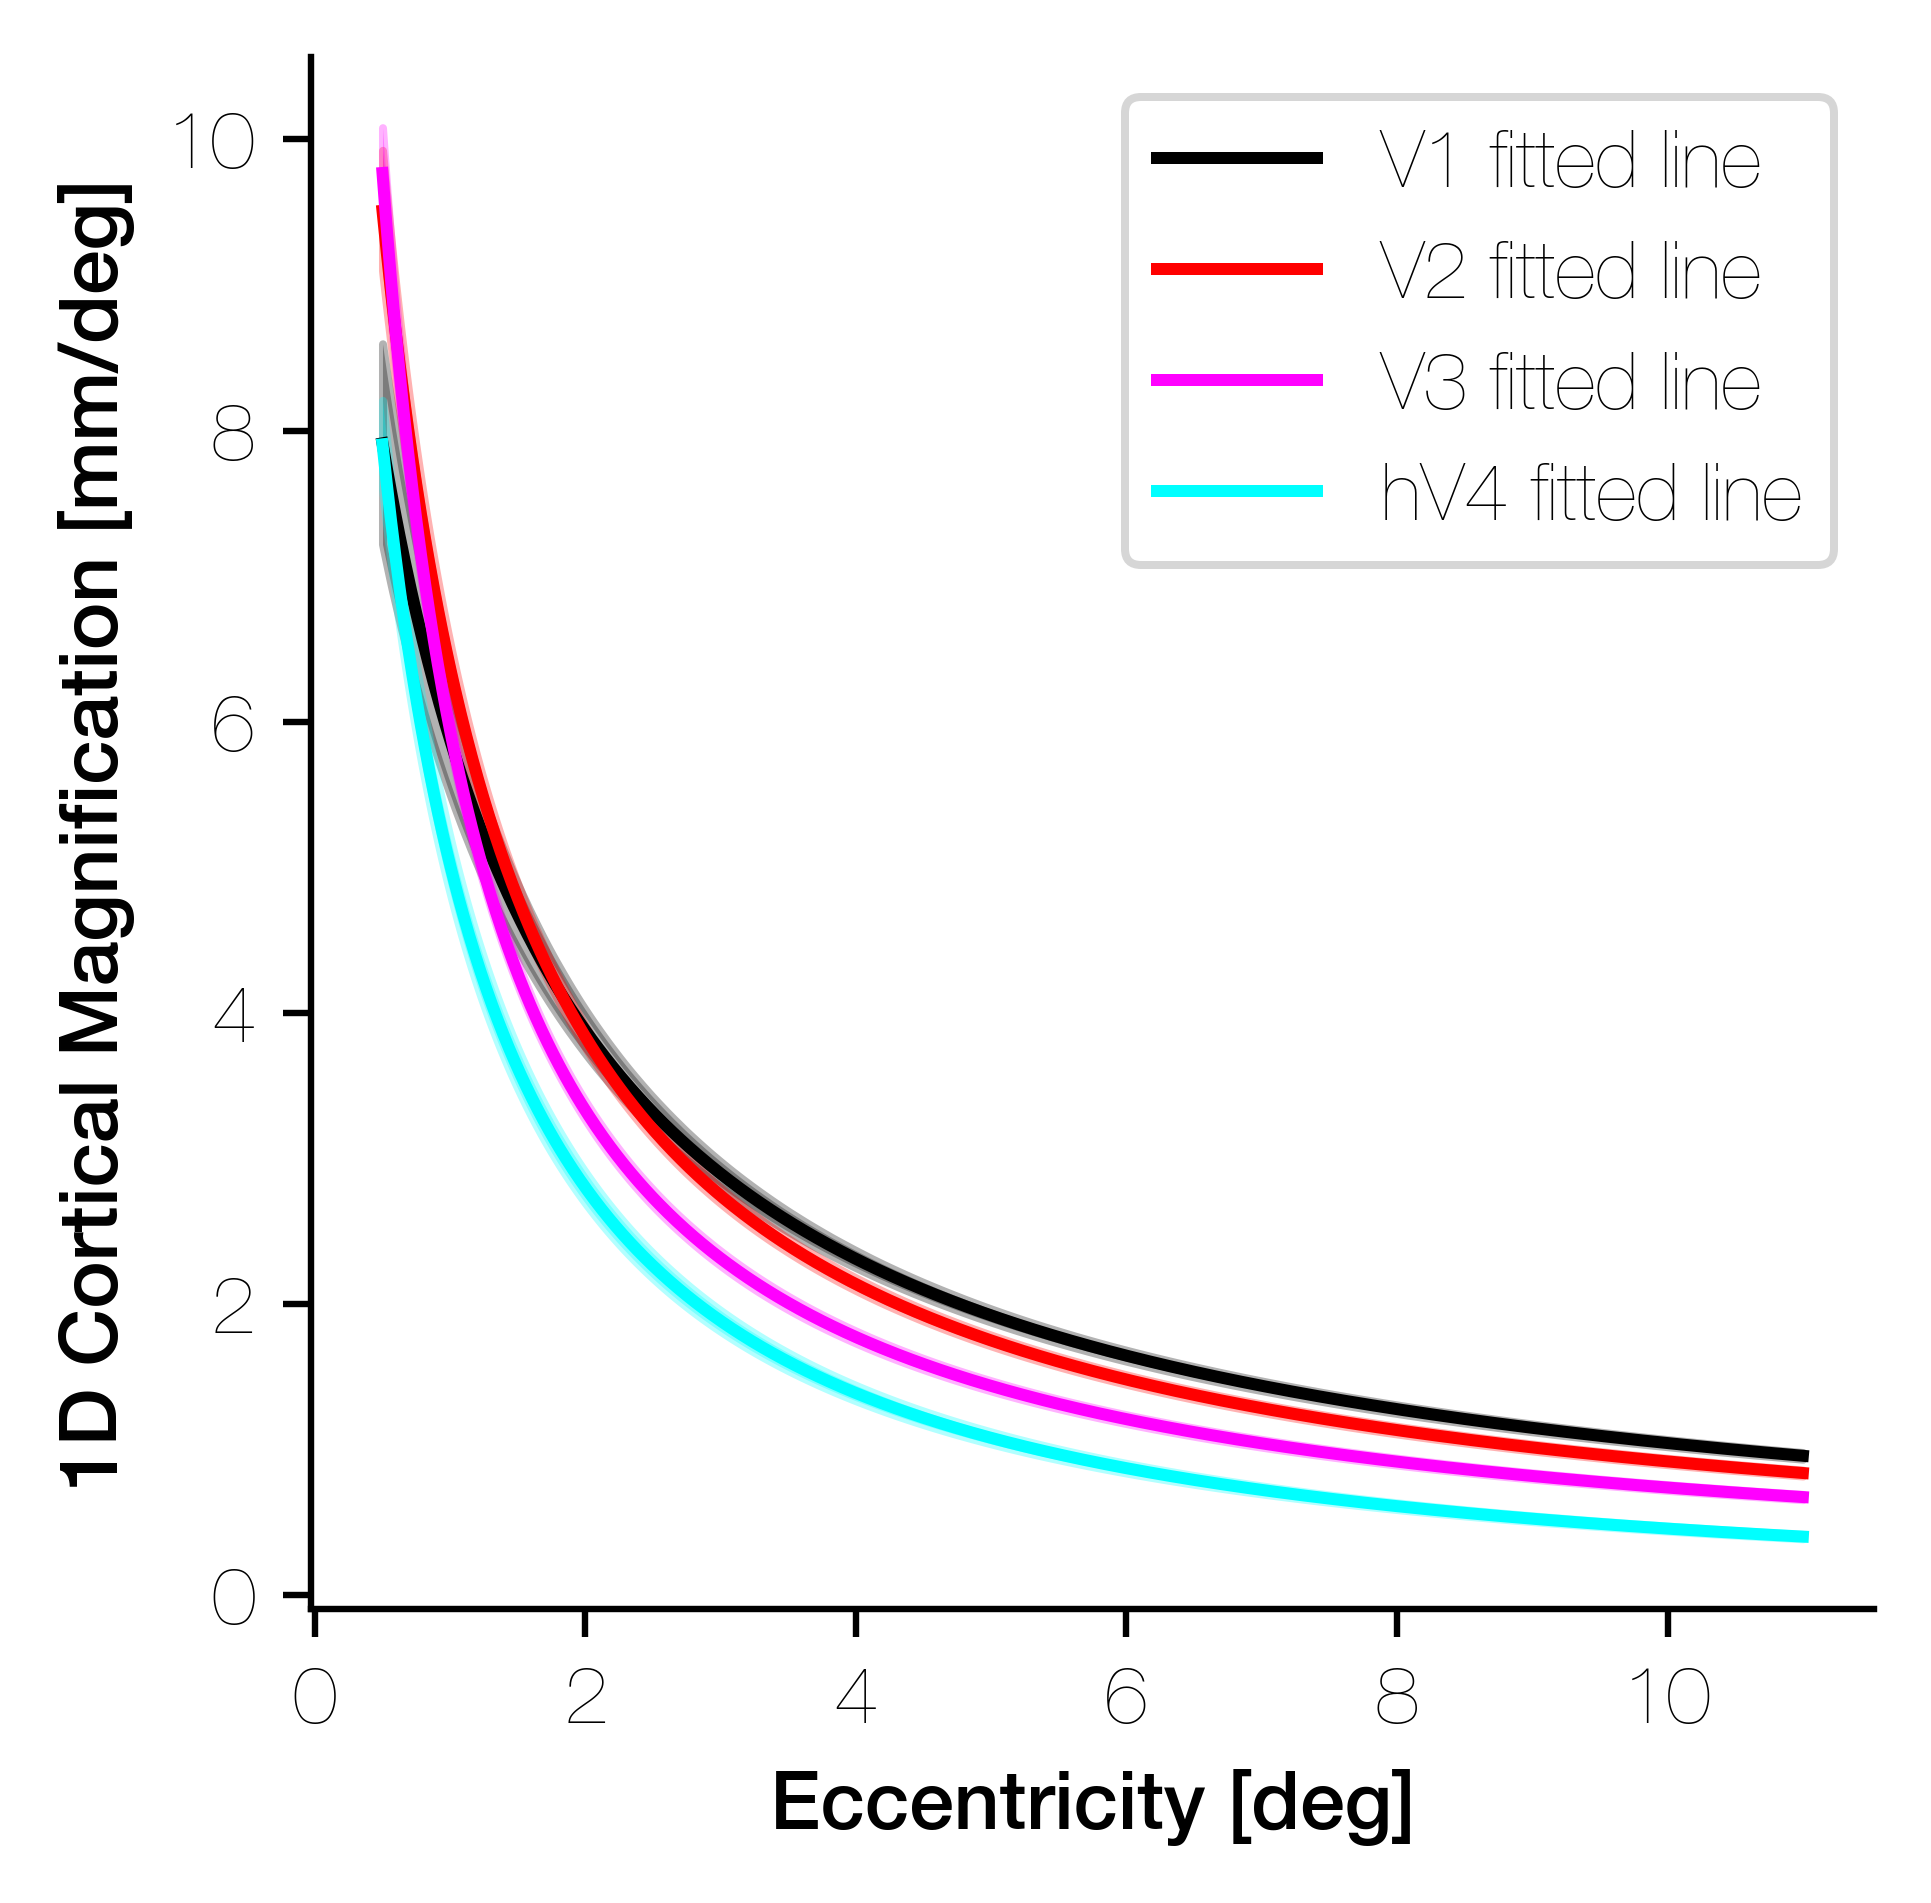

In [152]:
x = np.linspace(0.5, 11, 1000)
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5), dpi=72*8)

# Plotting the fitted lines for each visual area
ax.plot(x, np.sqrt(cmag_per_label[1]/2), 'black', label='V1 fitted line')
ax.plot(x, np.sqrt(cmag_per_label[2]/2), 'red', label='V2 fitted line')
ax.plot(x, np.sqrt(cmag_per_label[3]/2), 'magenta', label='V3 fitted line') #blue before
ax.plot(x, cmag_per_label[4], 'cyan', label='hV4 fitted line')

# Plotting the confidence intervals for each visual area
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v1[0]/2),
                 np.sqrt(confidence_interval_v1[1]/2),
                 color='black', alpha=0.3)
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v2[0]/2),
                 np.sqrt(confidence_interval_v2[1]/2),
                 color='red', alpha=0.3)
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v3[0]/2),
                 np.sqrt(confidence_interval_v3[1]/2),
                 color='magenta', alpha=0.3)
ax.fill_between(x, 
                 confidence_interval_v4[0],
                 confidence_interval_v4[1],
                 color='cyan', alpha=0.3)

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Eccentricity [deg]")
ax.set_ylabel("1D Cortical Magnification [mm/deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

## cortical crowding distance (ccd) and coefficent of variation for ccd

In [95]:
bootstrapped_ccd_1 = []
bootstrapped_ccd_2 = []
bootstrapped_ccd_3 = []
bootstrapped_ccd_4 = []

# Iterate through 10000 bootstrapped samples
for i in range(10000):
    ccd_v1 = bootstrapped[i] * np.sqrt(bootstrapped_v1[i] / 2)
    bootstrapped_ccd_1.append(ccd_v1)
    
    ccd_v2 = bootstrapped[i] * np.sqrt(bootstrapped_v2[i] / 2)
    bootstrapped_ccd_2.append(ccd_v2)
    
    ccd_v3 = bootstrapped[i] * np.sqrt(bootstrapped_v3[i] / 2)
    bootstrapped_ccd_3.append(ccd_v3)
    
    ccd_v4 = bootstrapped[i] * bootstrapped_v4[i]
    bootstrapped_ccd_4.append(ccd_v4)

bootstrapped_ccd_1 = np.array(bootstrapped_ccd_1)
bootstrapped_ccd_2 = np.array(bootstrapped_ccd_2)
bootstrapped_ccd_3 = np.array(bootstrapped_ccd_3)
bootstrapped_ccd_4 = np.array(bootstrapped_ccd_4)

# Calculate the mean of bootstrapped CCD values for each visual area
ccd1 = np.mean(bootstrapped_ccd_1, axis=0)
ccd2 = np.mean(bootstrapped_ccd_2, axis=0)
ccd3 = np.mean(bootstrapped_ccd_3, axis=0)
ccd4 = np.mean(bootstrapped_ccd_4, axis=0)

# Calculate the confidence interval for bootstrapped CCD values for each visual area
confidence_interval_ccd_1 = np.percentile(bootstrapped_ccd_1,  [16, 84], axis=0)
confidence_interval_ccd_2 = np.percentile(bootstrapped_ccd_2,  [16, 84], axis=0)
confidence_interval_ccd_3 = np.percentile(bootstrapped_ccd_3,  [16, 84], axis=0)
confidence_interval_ccd_4 = np.percentile(bootstrapped_ccd_4,  [16, 84], axis=0)

In [96]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(ccd1)
std_ccd_1 = np.std(ccd1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 3)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(ccd2)
std_ccd_2 = np.std(ccd2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 3)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(ccd3)
std_ccd_3 = np.std(ccd3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 3)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(ccd4)
std_ccd_4 = np.std(ccd4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 3)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

Coefficient of Variation (CCD 1): 0.198
Coefficient of Variation (CCD 2): 0.148
Coefficient of Variation (CCD 3): 0.113
Coefficient of Variation (CCD 4): 0.0


In [97]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(ccd1)
std_ccd_1 = np.std(ccd1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 3)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(ccd2)
std_ccd_2 = np.std(ccd2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 3)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(ccd3)
std_ccd_3 = np.std(ccd3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 3)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(ccd4)
std_ccd_4 = np.std(ccd4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 3)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

Coefficient of Variation (CCD 1): 0.198
Coefficient of Variation (CCD 2): 0.148
Coefficient of Variation (CCD 3): 0.113
Coefficient of Variation (CCD 4): 0.0


In [98]:
bootstrapped_cv_1 = cc.corticalcrowding.bootstrap_cv(ccd1)
ci_1 = np.percentile(bootstrapped_cv_1, [2.5, 97.5])

bootstrapped_cv_2 = cc.corticalcrowding.bootstrap_cv(ccd2)
ci_2 = np.percentile(bootstrapped_cv_2, [2.5, 97.5])

bootstrapped_cv_3 = cc.corticalcrowding.bootstrap_cv(ccd3)
ci_3 = np.percentile(bootstrapped_cv_3, [2.5, 97.5])

bootstrapped_cv_4 = cc.corticalcrowding.bootstrap_cv(ccd4)
ci_4 = np.percentile(bootstrapped_cv_4, [2.5, 97.5])

In [99]:
cv_ccd_1 = bootstrapped_cv_1.mean()
cv_ccd_2 = bootstrapped_cv_2.mean()
cv_ccd_3 = bootstrapped_cv_3.mean()
cv_ccd_4 = bootstrapped_cv_4.mean()
print([cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]) 

[0.19764910751415932, 0.14772981916687622, 0.11332499883613363, 4.494189236909782e-16]


In [100]:
print(mean_ccd_1,mean_ccd_2,mean_ccd_3,mean_ccd_4)

2.708979833506792 2.483653423497959 2.058385552200768 1.4833410044811262


In [101]:
print(np.round(ci_1, 3))
print(np.round(ci_2, 3))
print(np.round(ci_3, 3))
print(np.round(ci_4, 3))

[0.191 0.205]
[0.143 0.152]
[0.11  0.116]
[0. 0.]


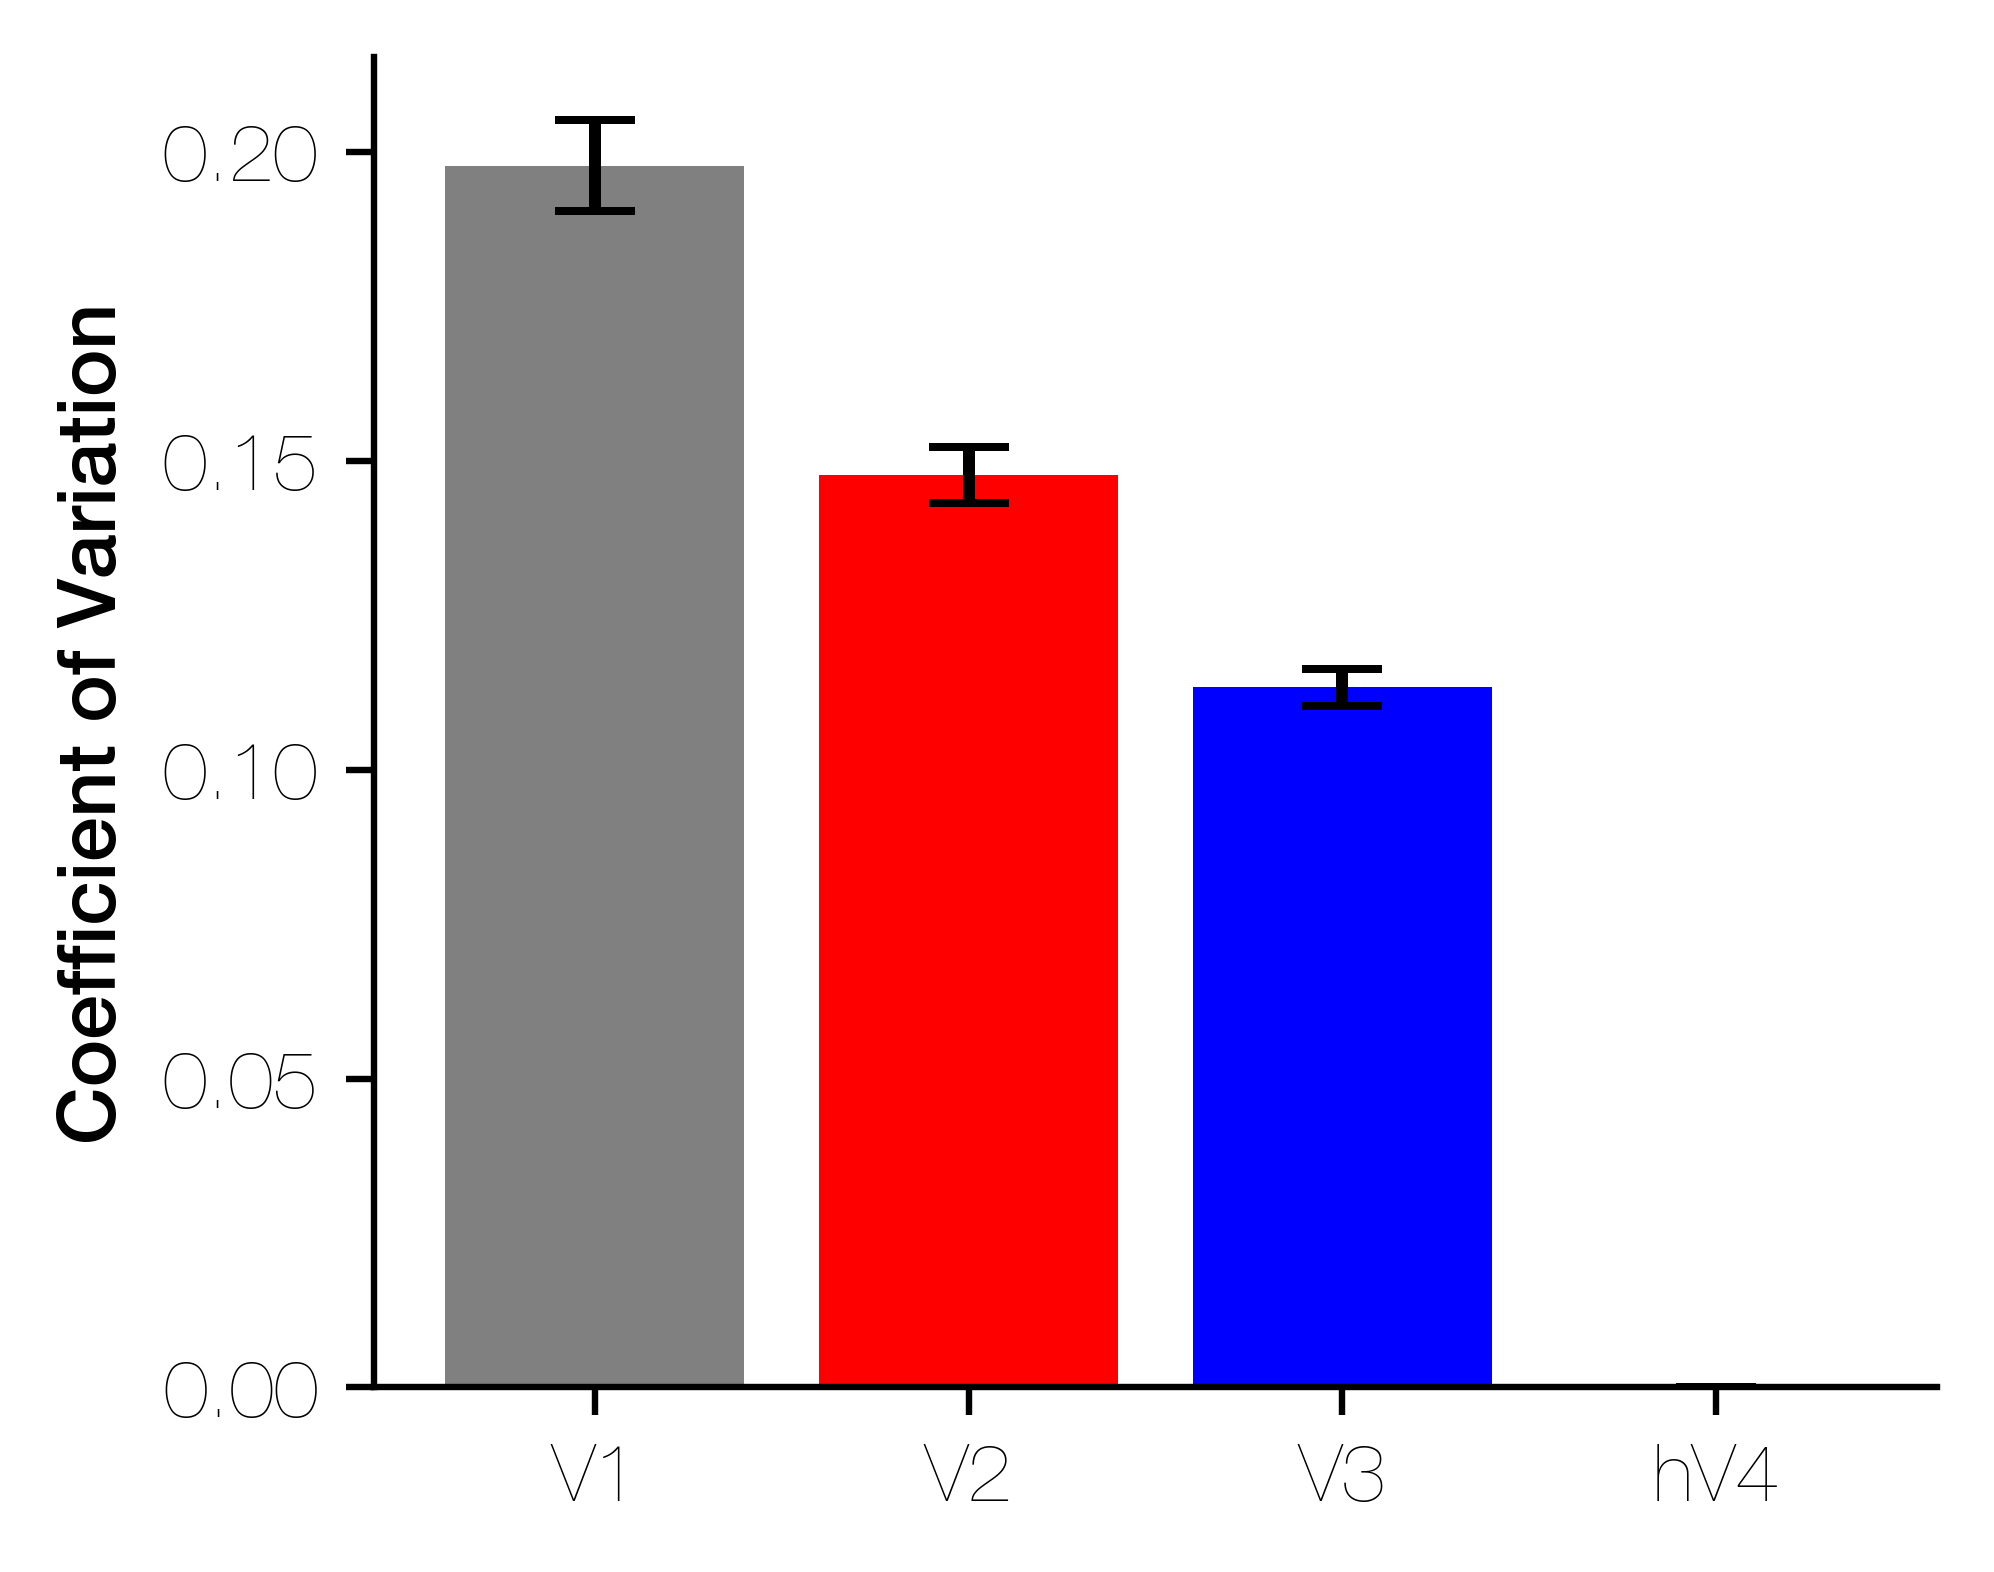

In [137]:
cv_ccd_values = [cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]
ccd_labels = ['V1', 'V2', 'V3', 'hV4']
cv_ci_list = [(ci_1[0], ci_1[1]), (ci_2[0], ci_2[1]), (ci_3[0], ci_3[1]),(ci_4[0], ci_4[1])]

lower_bound = [ci[0] for ci in cv_ci_list]
upper_bound = [ci[1] for ci in cv_ci_list]

yerr = [[cv_ccd_values[i] - lower_bound[i] for i in range(len(cv_ccd_values))],
        [upper_bound[i] - cv_ccd_values[i] for i in range(len(cv_ccd_values))]]

plt.figure(figsize=(3.5, 3))
plt.bar(ccd_labels, cv_ccd_values, yerr=yerr, capsize=5, color=['gray', 'red', 'blue', 'cyan'])

#plt.xlabel('Visual Areas')
plt.ylabel('Coefficient of Variation')
#plt.title('Coefficient of Variation for Cortical Crowding Distance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

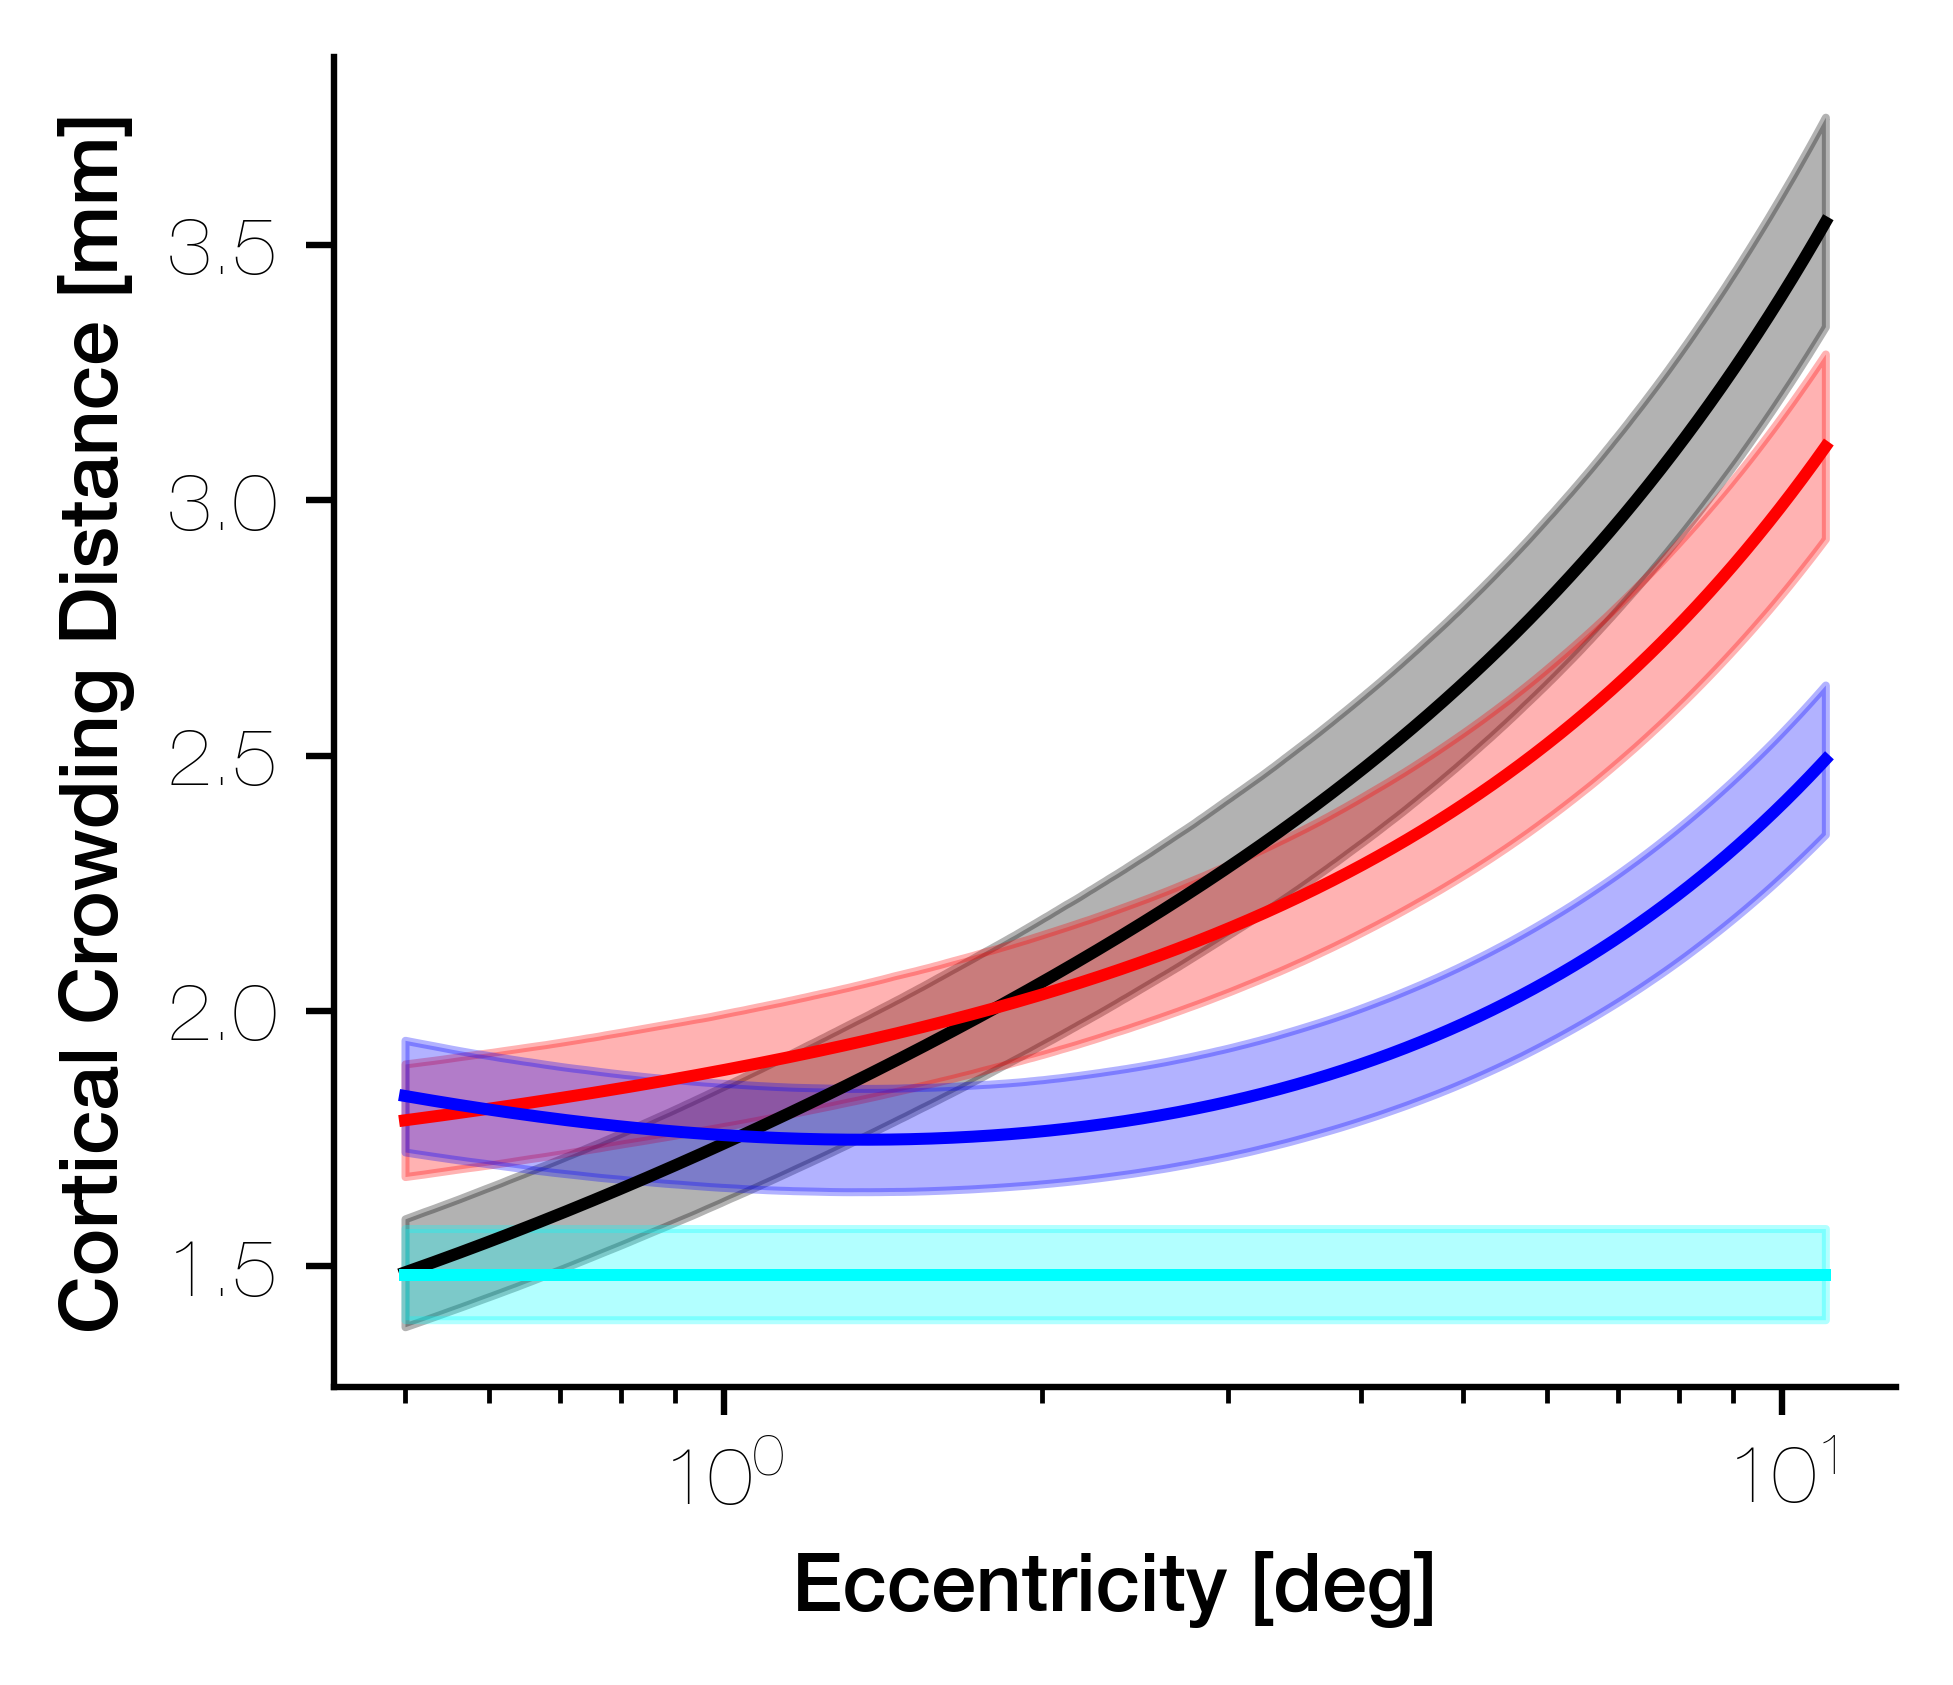

In [103]:
# plot the mean cortical crowding distance of each area
plt.figure(figsize=(3.5, 3))
plt.plot(x, ccd1, label='Cortical crowding distance in V1', color='black')
plt.plot(x, ccd2, label='Cortical crowding distance in V2', color='red')
plt.plot(x, ccd3, label='Cortical crowding distance in V3', color='blue')
plt.plot(x, ccd4, label='Cortical crowding distance in hV4', color='cyan')

plt.fill_between(x, confidence_interval_ccd_1[0], confidence_interval_ccd_1[1], color='black', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_2[0], confidence_interval_ccd_2[1], color='red', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_3[0], confidence_interval_ccd_3[1], color='blue', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_4[0], confidence_interval_ccd_4[1], color='cyan', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Eccentricity [deg]')
plt.ylabel('Cortical Crowding Distance [mm]')
plt.xscale('log')
plt.show()

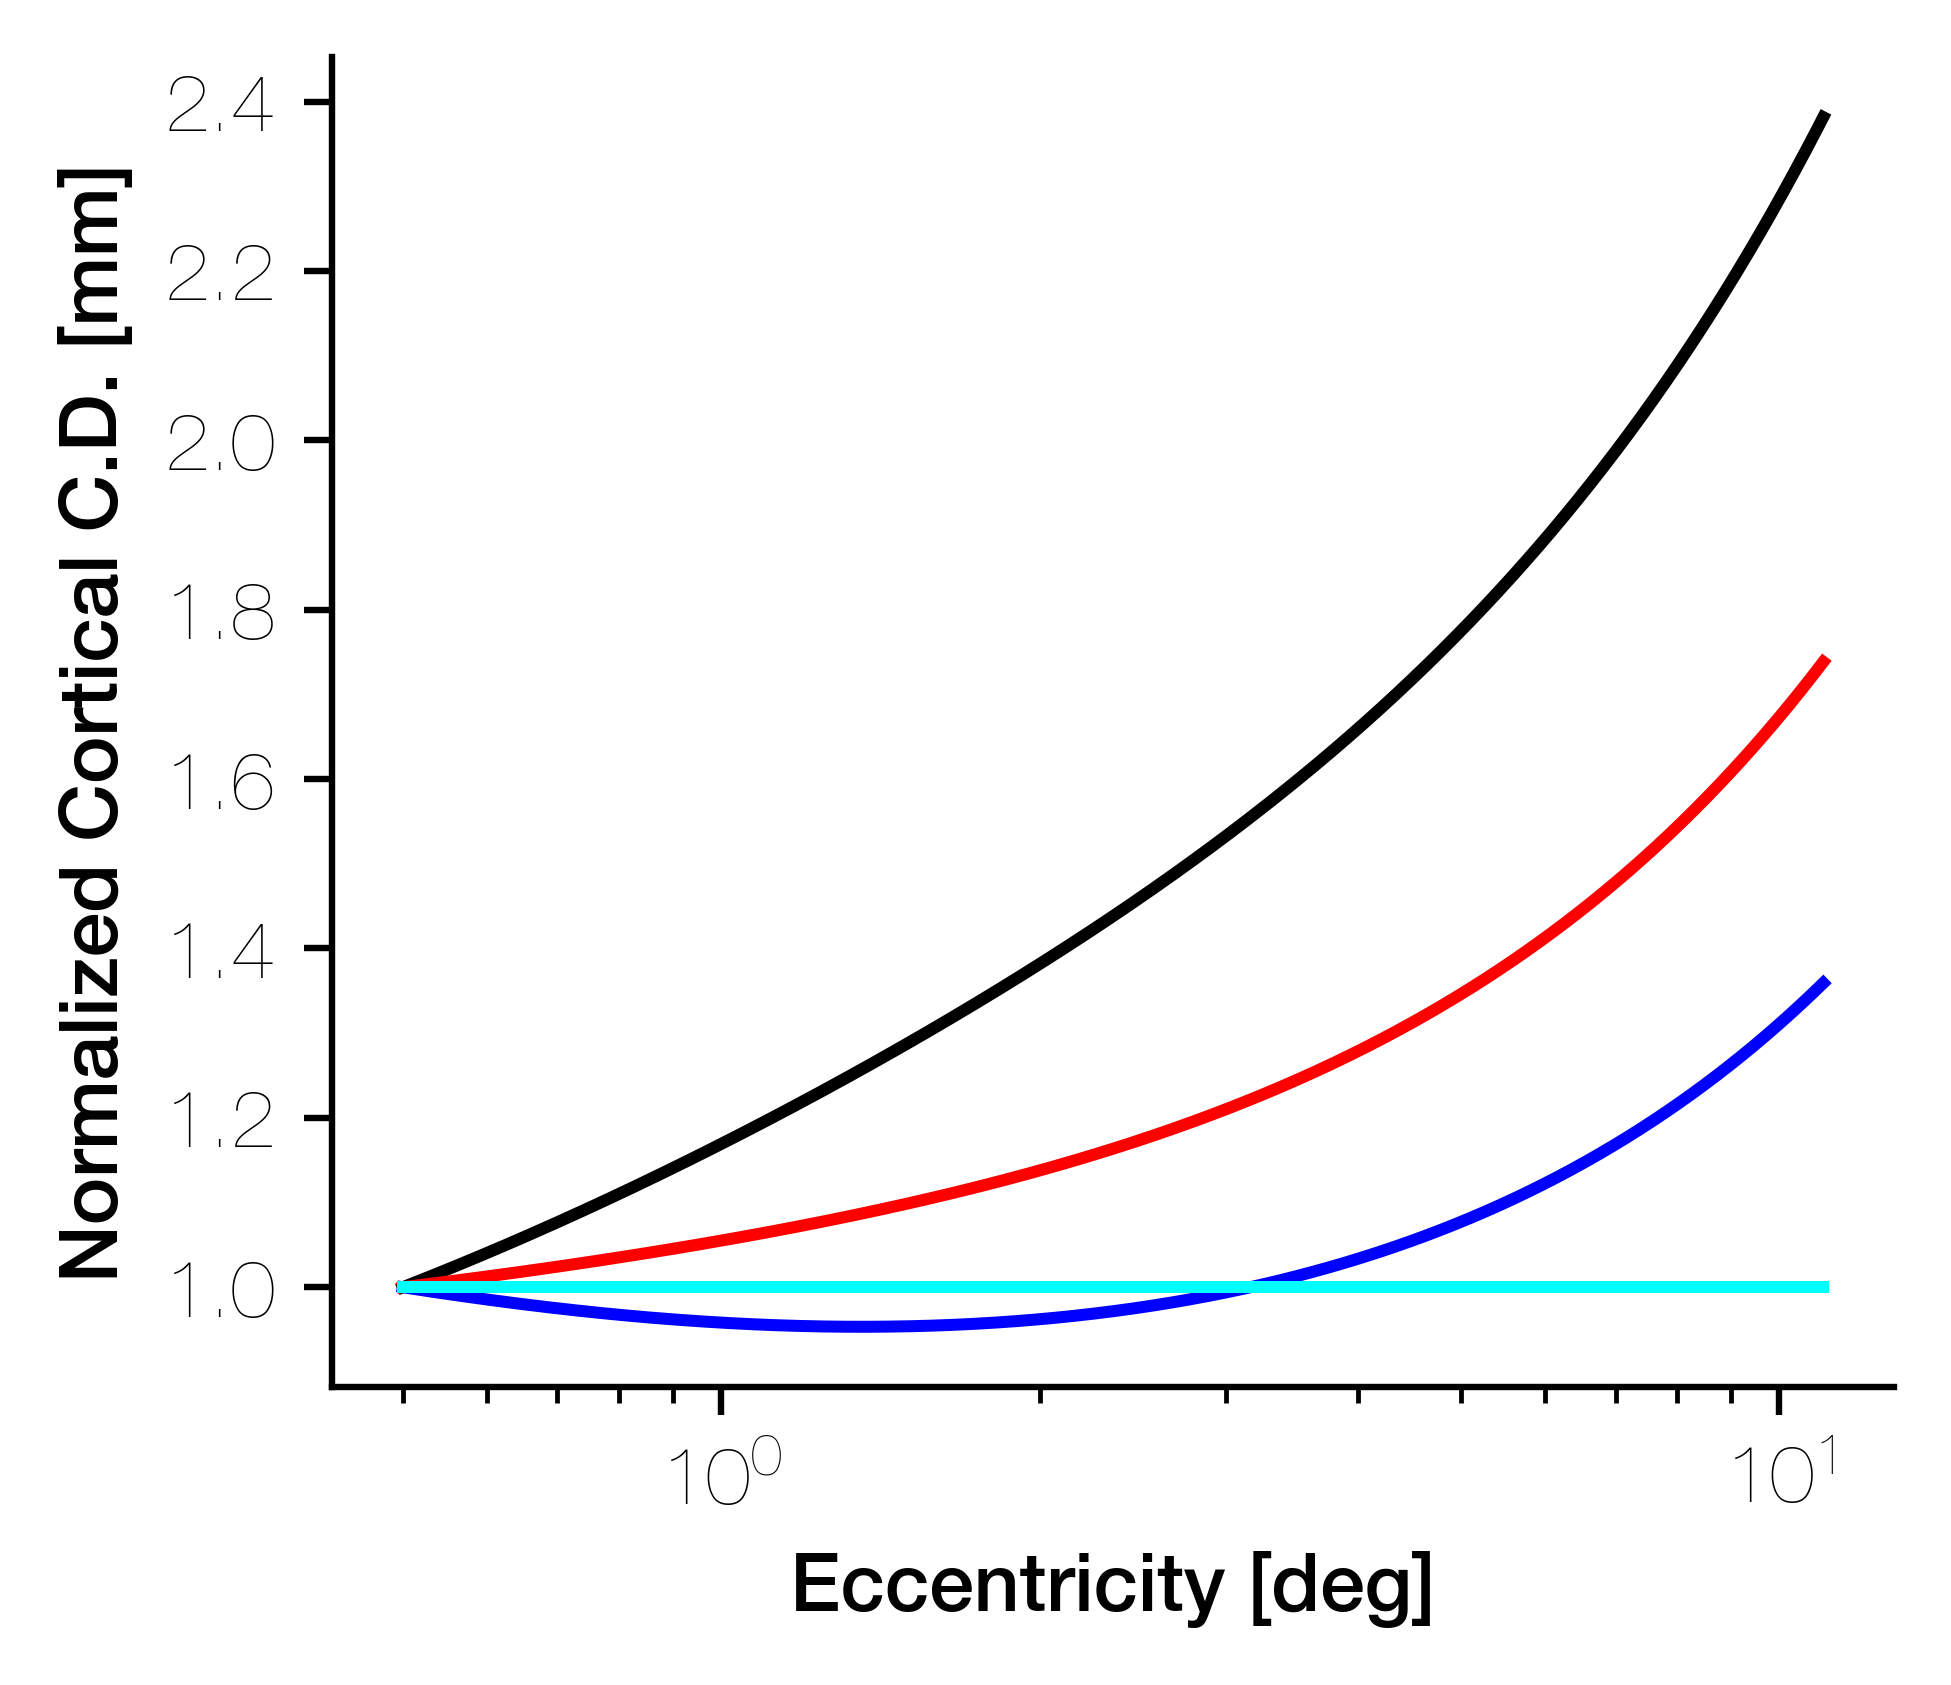

In [104]:
# normalize the cortical crowding distance
plt.figure(figsize=(3.5, 3))
plt.plot(x, ccd1/ccd1[0], color='black')
plt.plot(x, ccd2/ccd2[0], color='red')
plt.plot(x, ccd3/ccd3[0], color='blue')
plt.plot(x, ccd4/ccd4[0], color='cyan')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Eccentricity [deg]')
plt.ylabel('Normalized Cortical C.D. [mm]')
#plt.xticks([2.5, 5, 10])
plt.xscale('log')
plt.show()

## linear regression: predict crowding distance based on vmag_fit

In [123]:
# average parameter values across hemispheres for each subject and label
HH91_params_bi = HH91_params.groupby(
    ['sid', 'label'], as_index=False
    ).agg({
    'a': 'mean',
    'b': 'mean',
    'loss': 'mean'
})

In [124]:
df_mean = HH91_params_bi.merge(
    pd.DataFrame(dict(RadialEccentricity=[2.5, 5.0, 10.0])),
    how='cross')

a = df_mean['a']
b = df_mean['b']
ecc = df_mean['RadialEccentricity']
# calculate cmag based on a,b params from HH91_params_bi
df_mean['cmag_fit'] = (a / (ecc + b))**2
# add 1d visual magnification
df_mean['vmag1d_fit'] = np.sqrt(1 / df_mean['cmag_fit'])
df_mean['cmag_rad_fit'] = np.sqrt(df_mean['cmag_fit'] / 2)
df_mean['vmag_rad_fit'] = 1.0 / df_mean['cmag_rad_fit']

In [125]:
# rename columns of crowding distance df
mean_cd = mean_cd.rename(columns={"ID": "sid"})

In [126]:
df_mean = df_mean.merge(mean_cd, on=['sid', 'RadialEccentricity'])

In [127]:
df_mean #15 subjects with both crowding distance and fMRI data

sid  label          a         b         loss  \
0    sub-wlsubj070      1  16.739913  0.905964  5350.803463   
1    sub-wlsubj070      1  16.739913  0.905964  5350.803463   
2    sub-wlsubj070      1  16.739913  0.905964  5350.803463   
3    sub-wlsubj070      2  15.428800  0.811273  6295.717070   
4    sub-wlsubj070      2  15.428800  0.811273  6295.717070   
..             ...    ...        ...       ...          ...   
175  sub-wlsubj158      3  10.365791  0.248794  2438.172775   
176  sub-wlsubj158      3  10.365791  0.248794  2438.172775   
177  sub-wlsubj158      4   5.820677  0.055905   690.614745   
178  sub-wlsubj158      4   5.820677  0.055905   690.614745   
179  sub-wlsubj158      4   5.820677  0.055905   690.614745   

     RadialEccentricity   cmag_fit  vmag1d_fit  cmag_rad_fit  vmag_rad_fit  \
0                   2.5  24.156069    0.203464      3.475347      0.287741   
1                   5.0   8.033870    0.352807      2.004229      0.498945   
2                  10.0   2.356016    0.651495      1.085361      0.921353   
3                   2.5  21.710719    0.214616      3.294747      0.303513   
4                   5.0   7.048905    0.376651      1.877353      0.532665   
..                  ...        ...         ...           ...           ...   
175                 5.0   3.900191    0.506357      1.396458      0.716097   
176                10.0   1.022962    0.988713      0.715179      1.398251   
177                 2.5   5.186301    0.439108      1.610326      0.620992   
178                 5.0   1.325407    0.868611      0.814066      1.228402   
179                10.0   0.335046    1.727618      0.409296      2.443220   

     CrowdingDistance  
0            0.593743  
1            1.013120  
2            3.076970  
3            0.593743  
4            1.013120  
..                ...  
175          1.126178  
176          2.900924  
177          0.467451  
178          1.126178  
179          2.900924  

[180 rows x 11 columns]

In [128]:
df_mean['v4_cmag_rad'] = np.nan
df_mean['v4_vmag'] = np.nan

for sid in df_mean['sid'].unique():

    # get subject's V4 gains (both hemispheres)
    gains_v4 = gain_df[(gain_df['sid'] == sid) &
                       (gain_df['label'] == 4)]['gain'].values

    # compute mean sqrt(gain)
    mean_gain_v4 = np.mean(np.sqrt(gains_v4))

    # mask for this subject's V4 rows in df_mean
    mask = (df_mean['sid'] == sid) & (df_mean['label'] == 4)

    # get eccentricities for this subject & V4
    ecc_vals = df_mean.loc[mask, 'RadialEccentricity'].values

    # Bouma denominator (0.43 + r + 0.06 r^2)
    bouma_vals_v4 = Bouma(ecc_vals)

    # V4 cortical magnification (radial)
    v4_cmag_vals = mean_gain_v4 / bouma_vals_v4

    # assign new values
    df_mean.loc[mask, 'v4_cmag_rad'] = v4_cmag_vals

    # corresponding visual magnification = 1 / cortical_magnification
    df_mean.loc[mask, 'v4_vmag'] = 1.0 / v4_cmag_vals



In [135]:
res = {1: [], 2: [], 3: [], 4: []}
slopes = {1: [], 2: [], 3: [], 4: []}

for subject, subject_data in df_mean.groupby(['sid']):
    for lbl in [1, 2, 3, 4]:

        ssdf = subject_data[subject_data['label'] == lbl]

        if lbl in [1, 2, 3]:  
            # V1–V3: classical visual magnification
            x = ssdf['vmag_rad_fit'].values  

        else:  
            # V4: Bouma-derived visual magnification
            x = ssdf['v4_vmag'].values  

        y = ssdf['CrowdingDistance'].values

        # run regression (RSS + slope)
        rss, slope = cc.regression.fit_and_evaluate(x, y)

        res[lbl].append(rss)
        slopes[lbl].append(slope)

# compute summary stats
mean_rss = [np.mean(res[l]) for l in [1, 2, 3, 4]]
std_rss  = [np.std(res[l])  for l in [1, 2, 3, 4]]

n_subjects = len(df_mean['sid'].unique())
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

print("Mean RSS:", mean_rss)
print("SEM RSS:", sem_rss)


Mean RSS: [0.33281026628357335, 0.23703798176017798, 0.19393559800072996, 0.0647677502481933]
SEM RSS: [0.09185836 0.06812855 0.05966598 0.02133946]


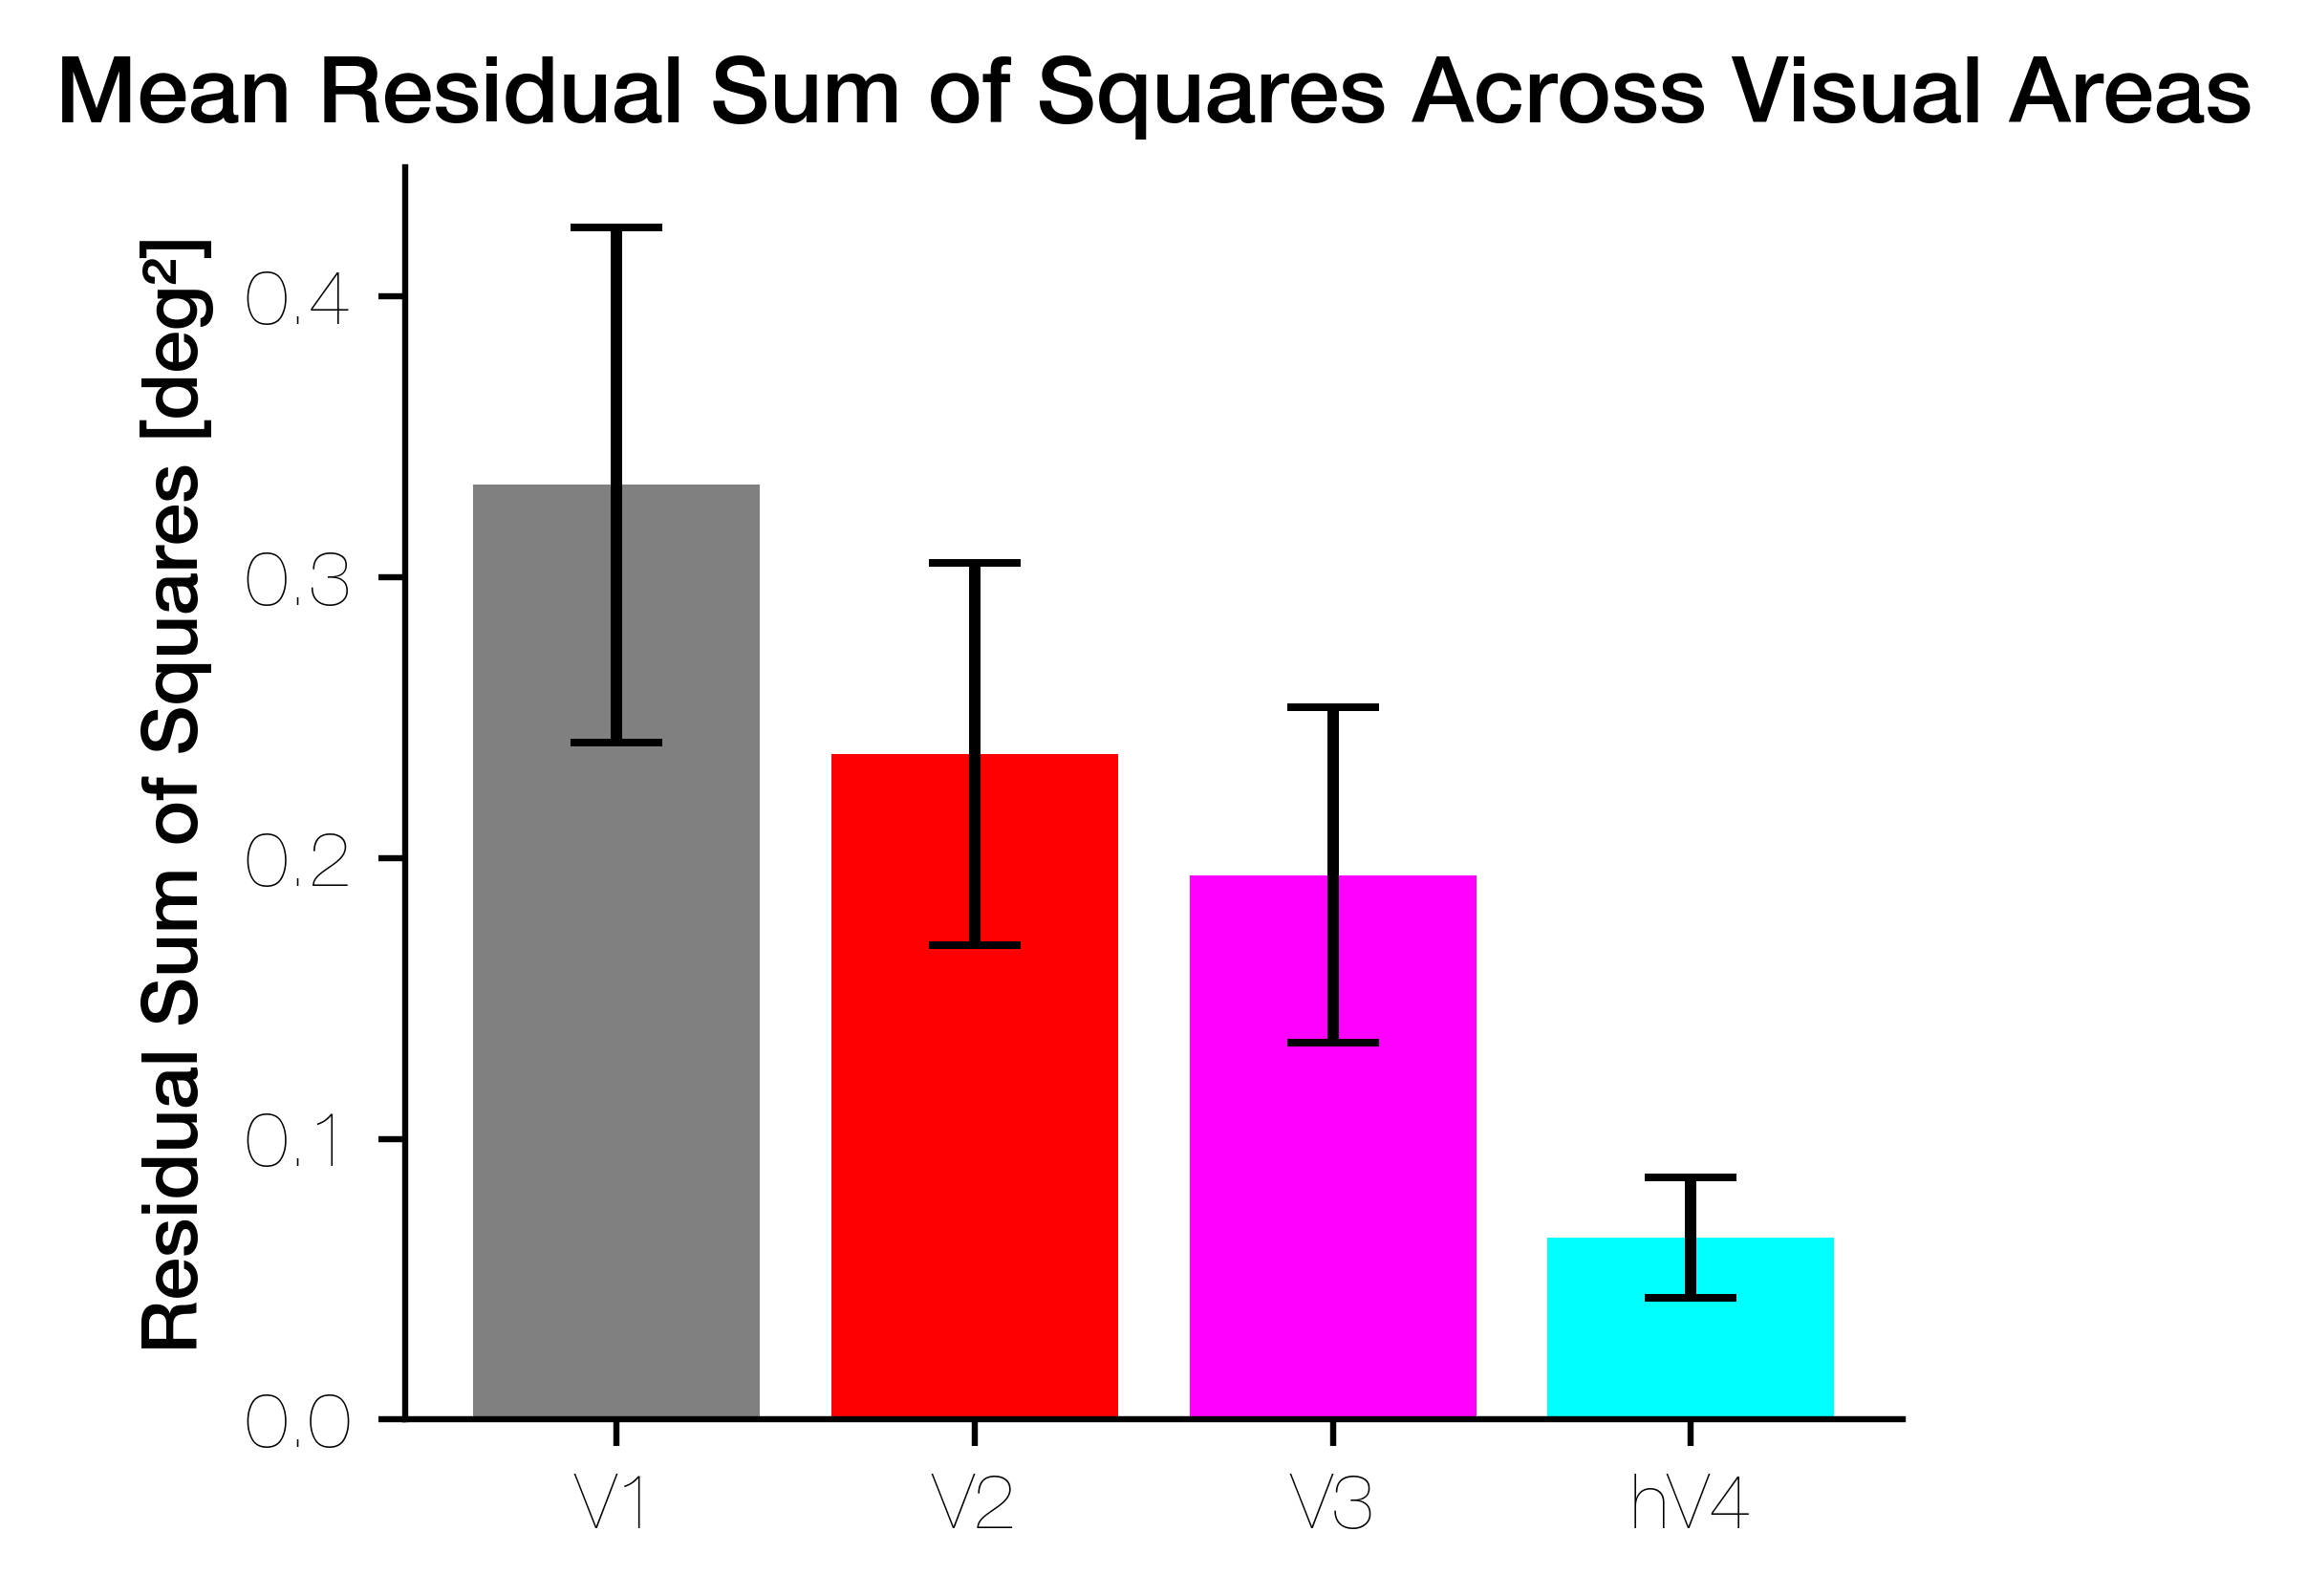

In [153]:
labels = ['V1', 'V2', 'V3', 'hV4']
colors = ['grey', 'red', 'magenta', 'cyan'] #blue

plt.figure(figsize=(3.5, 3))
plt.bar(labels, mean_rss, yerr=sem_rss, color=colors, capsize=6)

plt.ylabel("Residual Sum of Squares [deg²]")
plt.title("Mean Residual Sum of Squares Across Visual Areas")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [140]:
gain_df[gain_df['label']==3]

sid hemi  label      gain       rsq
4    sub-wlsubj070   lh      3  4.211768  0.978147
5    sub-wlsubj070   rh      3  3.845578  0.962765
12   sub-wlsubj114   lh      3  3.374621  0.909839
13   sub-wlsubj114   rh      3  4.260453  0.939111
20   sub-wlsubj121   lh      3  3.409155  0.988805
..             ...  ...    ...       ...       ...
301  sub-wlsubj174   rh      3  4.372121  0.985723
308  sub-wlsubj175   lh      3  4.273956  0.943770
309  sub-wlsubj175   rh      3  4.154605  0.957703
316  sub-wlsubj176   lh      3  3.121499  0.991846
317  sub-wlsubj176   rh      3  2.647551  0.984332

[80 rows x 5 columns]

In [142]:
gain_df[gain_df['label']==4]

sid hemi  label      gain       rsq
6    sub-wlsubj070   lh      4  1.202051  0.786847
7    sub-wlsubj070   rh      4  2.162538  0.904633
14   sub-wlsubj114   lh      4  2.486401  0.990404
15   sub-wlsubj114   rh      4  3.070877  0.989447
22   sub-wlsubj121   lh      4  1.392719  0.792321
..             ...  ...    ...       ...       ...
303  sub-wlsubj174   rh      4  2.800085  0.927305
310  sub-wlsubj175   lh      4  2.322889  0.883809
311  sub-wlsubj175   rh      4  3.140152  0.822508
318  sub-wlsubj176   lh      4  2.599209  0.941224
319  sub-wlsubj176   rh      4  1.682996  0.927203

[80 rows x 5 columns]

In [131]:
df_mean['v3_cmag_rad'] = np.nan
df_mean['v3_vmag'] = np.nan

for sid in df_mean['sid'].unique():

    # get subject's V3 gains (both hemispheres)
    gains_v3 = gain_df[(gain_df['sid'] == sid) &
                       (gain_df['label'] == 3)]['gain'].values

    # compute mean sqrt(gain)
    mean_gain_v3 = np.mean(np.sqrt(gains_v3))

    mask = (df_mean['sid'] == sid) & (df_mean['label'] == 3)

    # get eccentricities for this subject & V3
    ecc_vals = df_mean.loc[mask, 'RadialEccentricity'].values

    # Bouma denominator (0.43 + r + 0.06 r^2)
    bouma_vals_v3 = Bouma(ecc_vals)

    # V3 cortical magnification (radial)
    v3_cmag_vals = mean_gain_v3 / bouma_vals_v3

    # assign new values
    df_mean.loc[mask, 'v3_cmag_rad'] = v3_cmag_vals

    # corresponding visual magnification = 1 / cortical_magnification
    df_mean.loc[mask, 'v3_vmag'] = 1.0 / v3_cmag_vals



In [143]:
v3_gain_summary = []  # list of dicts

for sid in df_mean['sid'].unique():

    gains_v3 = gain_df[(gain_df['sid'] == sid) &
                       (gain_df['label'] == 3)]['gain'].values

    mean_gain_v3 = np.mean(np.sqrt(gains_v3))

    mask = (df_mean['sid'] == sid) & (df_mean['label'] == 3)
    ecc_vals = df_mean.loc[mask, 'RadialEccentricity'].values
    bouma_vals_v3 = Bouma(ecc_vals)
    v3_cmag_vals = mean_gain_v3 / bouma_vals_v3

    df_mean.loc[mask, 'v3_cmag_rad'] = v3_cmag_vals
    df_mean.loc[mask, 'v3_vmag'] = 1.0 / v3_cmag_vals

    # store info per subject
    v3_gain_summary.append({
        "sid": sid,
        "raw_gains": gains_v3,
        "mean_sqrt_gain": mean_gain_v3
    })


In [144]:
# all raw gains from summary
all_raw_from_summary = np.concatenate([d["raw_gains"] for d in v3_gain_summary])
all_raw_from_gain_df = gain_df[gain_df['label'] == 3]['gain'].values


In [133]:
res = {1: [], 2: [], 3: [], 4: []}
slopes = {1: [], 2: [], 3: [], 4: []}

for subject, subject_data in df_mean.groupby(['sid']):
    for lbl in [1, 2, 3, 4]:

        ssdf = subject_data[subject_data['label'] == lbl]


        if lbl in [1, 2]:
            x = ssdf['vmag_rad_fit'].values
        elif lbl == 3:
            x = ssdf['v3_vmag'].values
        else:  # lbl == 4
            x = ssdf['v4_vmag'].values

        y = ssdf['CrowdingDistance'].values

        # run regression (RSS + slope)
        rss, slope = cc.regression.fit_and_evaluate(x, y)

        res[lbl].append(rss)
        slopes[lbl].append(slope)

# compute summary stats
mean_rss = [np.mean(res[l]) for l in [1, 2, 3, 4]]
std_rss  = [np.std(res[l])  for l in [1, 2, 3, 4]]

n_subjects = len(df_mean['sid'].unique())
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

print("Mean RSS:", mean_rss)
print("SEM RSS:", sem_rss)


Mean RSS: [0.33281026628357335, 0.23703798176017798, 0.06476775024819327, 0.0647677502481933]
SEM RSS: [0.09185836 0.06812855 0.02133946 0.02133946]


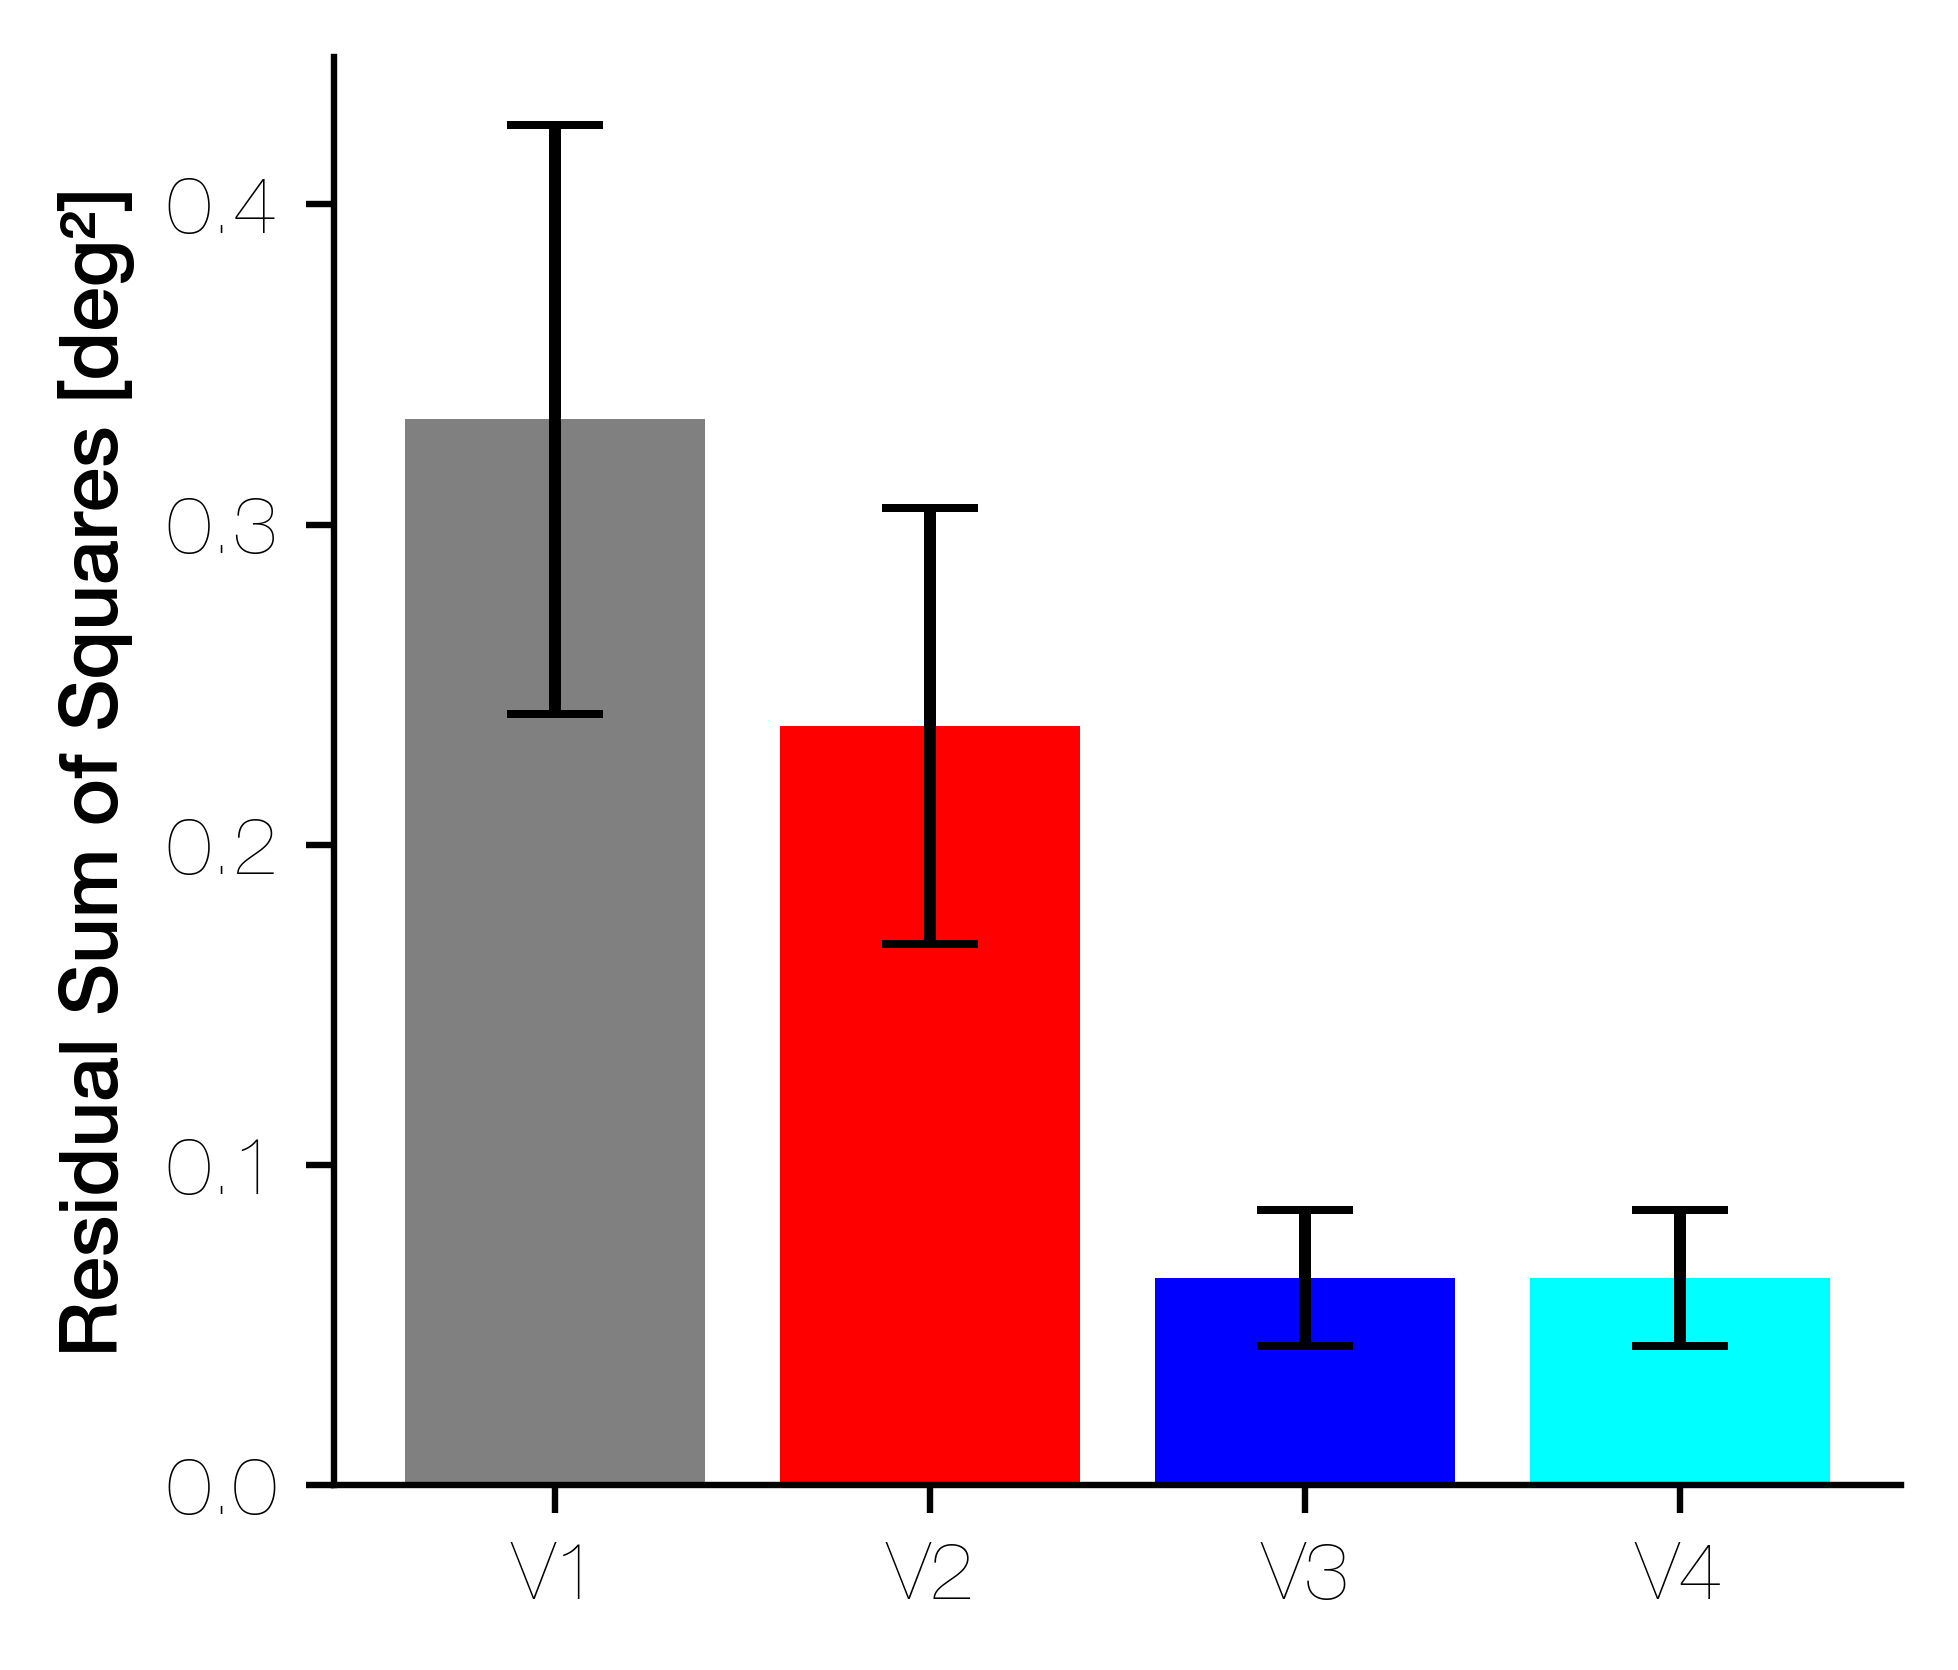

In [134]:
labels = ['V1', 'V2', 'V3', 'V4']
colors = ['grey', 'red', 'blue', 'cyan']

plt.figure(figsize=(3.5, 3))
plt.bar(labels, mean_rss, yerr=sem_rss, color=colors, capsize=6)

plt.ylabel("Residual Sum of Squares [deg²]")
#plt.title("Mean Residual Sum of Squares Across Visual Areas")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# previous code used in VSS24

### bootstrap crowding distance

In [ ]:
def func_cd(x, b):
    return np.log10((0.43 + x + 0.06*(x**2)) * b)

# the number of bootstrap samples
num_bootstrap_samples = 1000
x = np.linspace(0.5,10,1000)
eccentricities = [2.5, 5, 10]

# sid_df.shape=(480,)
sid_df = df['Observer'].values
x_ecc = np.array(x_ecc)
cd = np.array(cd_list)

def bootstrap_fit(sids, xdata, ydata, x):
    # unique_sids : 20 numbers
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # each bootstrap, sample 20 subjects with replacement
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        # 20 by 24 = 480, 480 x values and y values each
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        b, _ = curve_fit(func_cd, x_boot, np.log10(y_boot), p0=0.15)
        y = (0.43 + x + 0.06*(x**2)) * b
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

bootstrapped = bootstrap_fit(sid_df, x_ecc, cd, x)

# Calculate confidence interval
confidence_interval_cd = np.percentile(bootstrapped, [2.5, 97.5], axis=0)

In [ ]:
x = np.linspace(0.5, 10, 1000)
# Fitted value without bootstrap
plt.plot(x, (0.43 + x + 0.06*(x**2)) * b, 'k-', label='Fitted Crowding Distance')

# Plot individual data
plt.plot(mean_x_ecc, mean_cd_list, 'ko', alpha=0.1, label='Individual Crowding Distance')

# Plot error bars
plt.errorbar(eccentricities, mean_values, yerr=std_values, fmt='o', color='red', label='Mean ± Std')
plt.fill_between(x, confidence_interval_cd[0], confidence_interval_cd[1], color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Crowding distance (deg)')
plt.yscale('log')
plt.ylim(bottom=0.1)  # Set lower limit to 0.1 (10^-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### bootstrap C.Mag

In [ ]:
# calculate cmag
all_cmag_v1 = []
all_cmag_v2 = []
all_cmag_v3 = []
all_cmag_v4 = []
all_eccen_v1 = []
all_eccen_v2 = []
all_eccen_v3 = []
all_eccen_v4 = []
eccen = np.linspace(1, 11, 1000)
subjects_added = []  
all_mask = ('variance_explained', 0.04, 1)

for sid in sids:
    try:
        sub = load_subject(sid)

        # Calculate cmag for the subject for V1
        v1_mask = {'and': [('visual_area', 1), all_mask]}
        eccen_v1, cmag_v1 = ring_cmag(sub, eccen=None, mask=v1_mask)
        all_eccen_v1.append(eccen_v1)
        all_cmag_v1.append(cmag_v1)

        # Calculate cmag for the subject for V2
        v2_mask = {'and': [('visual_area', 2), all_mask]}
        eccen_v2, cmag_v2 = ring_cmag(sub, eccen=None, mask=v2_mask)
        all_eccen_v2.append(eccen_v2)
        all_cmag_v2.append(cmag_v2)

        # Calculate cmag for the subject for V3
        v3_mask = {'and': [('visual_area', 3), all_mask]}
        eccen_v3, cmag_v3 = ring_cmag(sub, eccen=None, mask=v3_mask)
        all_eccen_v3.append(eccen_v3)
        all_cmag_v3.append(cmag_v3)
        
        # Calculate cmag for the subject for V4
        v4_mask = {'and': [('visual_area', 4), all_mask]}
        eccen_v4, cmag_v4 = ring_cmag(sub, eccen=None, mask=v4_mask)
        all_eccen_v4.append(eccen_v4)
        all_cmag_v4.append(cmag_v4)
        
        subjects_added.append(sid)  # Add subject to the list of subjects added
    
    except Exception as e:
        print(f"Error calculating cmag for subject {sid}: {e}")


# Convert lists to arrays
# all_cmag_v1 = np.array(all_cmag_v1)
# all_cmag_v2 = np.array(all_cmag_v2)
# all_cmag_v3 = np.array(all_cmag_v3)
# all_cmag_v4: len=35, each array has diff shape
all_flatcmag_v4 = np.concatenate(all_cmag_v4)
all_flateccen_v4 = np.concatenate(all_eccen_v4)

In [ ]:
eccen = np.linspace(1,11, 1000)

def func(x, a, b):
    return (a / (b + x))**2
# use all_cmag_v1 contains cmag for v1 for 29 subjects
subjects_added = np.array(subjects_added)
x_data = np.array(eccen)
cmag_v1 = np.array(all_cmag_v1)
cmag_v2 = np.array(all_cmag_v2)
cmag_v3 = np.array(all_cmag_v3)
cmag_v4 = np.array(all_cmag_v4)

def bootstrap_fit_cmag(sids, xdata, ydata, x, p0):
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # Sample subjects
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        popt, _ = curve_fit(func, x_boot.flatten(), y_boot.flatten(),p0=p0)
        # store the function value
        y = (popt[0] / (popt[1] + x))**2
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

all_eccen = np.array([x_data]*len(subjects_added))

bootstrapped_v1 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v1, eccen, p0=[17.3, 0.75])
bootstrapped_v2 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v2, eccen, p0=[17.3, 0.75])
bootstrapped_v3 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v3, eccen, p0=[17.3, 0.75])
bootstrapped_v4 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v4, eccen, p0=[17.3, 0.75])

# Calculate confidence interval
confidence_interval_v1 = np.percentile(bootstrapped_v1, [2.5, 97.5], axis=0)
confidence_interval_v2 = np.percentile(bootstrapped_v2, [2.5, 97.5], axis=0)
confidence_interval_v3 = np.percentile(bootstrapped_v3, [2.5, 97.5], axis=0)
confidence_interval_v4 = np.percentile(bootstrapped_v4, [2.5, 97.5], axis=0)

In [ ]:
fig, ax = plt.subplots()

# Plotting the average data for each visual area
ax.plot(eccen, np.sqrt(average_cmag_v1/2), 'k:', label='V1')
ax.plot(eccen, np.sqrt(average_cmag_v2/2), 'r:', label='V2')
ax.plot(eccen, np.sqrt(average_cmag_v3/2), 'm:', label='V3')
ax.plot(eccen, np.sqrt(average_cmag_v4/2), 'g:', label='hV4')

# Plotting the fitted lines for each visual area
ax.plot(eccen, np.sqrt((popt1[0]/(eccen+popt1[1]))**2/2), 'k', label='V1 fitted line')
ax.plot(eccen, np.sqrt((popt2[0]/(eccen+popt2[1]))**2/2), 'r', label='V2 fitted line')
ax.plot(eccen, np.sqrt((popt3[0]/(eccen+popt3[1]))**2/2), 'm', label='V3 fitted line')
ax.plot(eccen, np.sqrt((popt4[0]/(eccen+popt4[1]))**2/2), 'g', label='hV4 fitted line')

# Plotting the confidence intervals for each visual area
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v1[0]/2),
                 np.sqrt(confidence_interval_v1[1]/2),
                 color='k', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v2[0]/2),
                 np.sqrt(confidence_interval_v2[1]/2),
                 color='r', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v3[0]/2),
                 np.sqrt(confidence_interval_v3[1]/2),
                 color='m', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v4[0]/2),
                 np.sqrt(confidence_interval_v4[1]/2),
                 color='g', alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Eccentricity (deg)")
ax.set_ylabel("Radial Cortical Magnification (mm/deg)")
ax.set_title("Average Radial Cortical Magnification for V1, V2, V3, hV4")
ax.legend()
plt.show()

### using bootstrapped fits to get cortical crowding distance

In [ ]:
# lists to store bootstrapped CCD values for each visual area
bootstrapped_ccd_1 = []
bootstrapped_ccd_2 = []
bootstrapped_ccd_3 = []
bootstrapped_ccd_4 = []

# "bootstrapped" here refers to crowding distance result
for i in range(len(bootstrapped)):
    # Calculate bootstrapped CCD for visual area 1
    ccd_v1 = bootstrapped[i] * np.sqrt(bootstrapped_v1[i] / 2)
    bootstrapped_ccd_1.append(ccd_v1)
    
    # Calculate bootstrapped CCD for visual area 2
    ccd_v2 = bootstrapped[i] * np.sqrt(bootstrapped_v2[i] / 2)
    bootstrapped_ccd_2.append(ccd_v2)
    
    # Calculate bootstrapped CCD for visual area 3
    ccd_v3 = bootstrapped[i] * np.sqrt(bootstrapped_v3[i] / 2)
    bootstrapped_ccd_3.append(ccd_v3)
    
    # Calculate bootstrapped CCD for visual area 4
    ccd_v4 = bootstrapped[i] * np.sqrt(bootstrapped_v4[i] / 2)
    bootstrapped_ccd_4.append(ccd_v4)

# Convert lists to arrays
bootstrapped_ccd_1 = np.array(bootstrapped_ccd_1)
bootstrapped_ccd_2 = np.array(bootstrapped_ccd_2)
bootstrapped_ccd_3 = np.array(bootstrapped_ccd_3)
bootstrapped_ccd_4 = np.array(bootstrapped_ccd_4)

# Calculate the mean of bootstrapped CCD values for each visual area
xx1 = np.mean(bootstrapped_ccd_1, axis=0)
xx2 = np.mean(bootstrapped_ccd_2, axis=0)
xx3 = np.mean(bootstrapped_ccd_3, axis=0)
xx4 = np.mean(bootstrapped_ccd_4, axis=0)

# Calculate the confidence interval for bootstrapped CCD values for each visual area
confidence_interval_ccd_1 = np.percentile(bootstrapped_ccd_1,  [16, 84], axis=0)
confidence_interval_ccd_2 = np.percentile(bootstrapped_ccd_2,  [16, 84], axis=0)
confidence_interval_ccd_3 = np.percentile(bootstrapped_ccd_3,  [16, 84], axis=0)
confidence_interval_ccd_4 = np.percentile(bootstrapped_ccd_4,  [16, 84], axis=0)

### coefficient of variation for cortical crowding distance at each area

In [ ]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(xx1)
std_ccd_1 = np.std(xx1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 2)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(xx2)
std_ccd_2 = np.std(xx2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 2)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(xx3)
std_ccd_3 = np.std(xx3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 2)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(xx4)
std_ccd_4 = np.std(xx4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 2)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

In [ ]:
def bootstrap_cv(data, num_samples):
    """
    Perform bootstrapping to compute the coefficient of variation (CV).

    Parameters:
        data (numpy.ndarray)
        num_samples (int): Number of bootstrap samples to generate.

    Returns:
        numpy.ndarray: Array containing the bootstrapped CV values.
    """
    bootstrapped_cv = []
    n = len(data)
    for _ in range(num_samples):
        sample_indices = np.random.choice(range(n), size=n, replace=True)
        bootstrapped_sample = data[sample_indices]
        mean_sample = np.mean(bootstrapped_sample)
        std_sample = np.std(bootstrapped_sample)
        cv_sample = std_sample / mean_sample
        bootstrapped_cv.append(cv_sample)
    return np.array(bootstrapped_cv)

# Perform bootstrap on CCD 1
bootstrapped_cv_1 = bootstrap_cv(xx1, num_samples=1000)
ci_1 = np.percentile(bootstrapped_cv_1, [2.5, 97.5])

# Perform bootstrap on CCD 2
bootstrapped_cv_2 = bootstrap_cv(xx2, num_samples=1000)
ci_2 = np.percentile(bootstrapped_cv_2, [2.5, 97.5])

# Perform bootstrap on CCD 3
bootstrapped_cv_3 = bootstrap_cv(xx3, num_samples=1000)
ci_3 = np.percentile(bootstrapped_cv_3, [2.5, 97.5])

# Perform bootstrap on CCD 4
bootstrapped_cv_4 = bootstrap_cv(xx4, num_samples=1000)
ci_4 = np.percentile(bootstrapped_cv_4, [2.5, 97.5])

In [ ]:
cv_ccd_1 = bootstrapped_cv_1.mean()
cv_ccd_2 = bootstrapped_cv_2.mean()
cv_ccd_3 = bootstrapped_cv_3.mean()
cv_ccd_4 = bootstrapped_cv_4.mean()

In [ ]:
# a list of mean CV in each area
cv_ccd_values = [cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]
ccd_labels = ['V1', 'V2', 'V3', 'V4']

# a list of CI in each area
cv_ci_list = [(ci_1[0], ci_1[1]), (ci_2[0], ci_2[1]), (ci_3[0], ci_3[1]),(ci_4[0], ci_4[1])]

# lower and upper bounds of CI
lower_bound = [ci[0] for ci in cv_ci_list]
upper_bound = [ci[1] for ci in cv_ci_list]

yerr = [[cv_ccd_values[i] - lower_bound[i] for i in range(len(cv_ccd_values))],
        [upper_bound[i] - cv_ccd_values[i] for i in range(len(cv_ccd_values))]]

# bar plot with error bars
plt.bar(ccd_labels, cv_ccd_values, yerr=yerr, capsize=5, color=['grey', 'red', 'magenta', 'green'])

plt.xlabel('Visual Areas')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation for Cortical Crowding Distance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Plot cortical crowding distance vs eccen
x = np.linspace(0.5, 10, 1000)
plt.plot(x, xx1, label='Cortical crowding distance in V1', color='black')
plt.plot(x, xx2, label='Cortical crowding distance in V2', color='red')
plt.plot(x, xx3, label='Cortical crowding distance in V3', color='magenta')
plt.plot(x, xx4, label='Cortical crowding distance in hV4', color='green')

# Confidence intervals
plt.fill_between(x, confidence_interval_ccd_1[0], confidence_interval_ccd_1[1], color='black', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_2[0], confidence_interval_ccd_2[1], color='red', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_3[0], confidence_interval_ccd_3[1], color='magenta', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_4[0], confidence_interval_ccd_4[1], color='green', alpha=0.3)

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Cortical Crowding Distance (mm)')
#plt.legend()
plt.show()